# Simple Introduction to Deep Equilibrium Nets
## Notebook 3: Exercise / Coding session on [Deep Equilibirium Nets](https://onlinelibrary.wiley.com/doi/full/10.1111/iere.12575)

Notebook by [Marlon Azinovic](https://sites.google.com/view/marlonazinovic/home?authuser=0), [Luca Gaegauf](https://www.phd-finance.uzh.ch/en/People/phd-candidates/luca-gaegauf.html), and [Simon Scheidegger](https://sites.google.com/site/simonscheidegger/home), August 2023.
### Purpose of the notebook and economic model  
This notebook builds on the previous two notebooks in class.  
We will go through four exercises:  
1. The model of Notebook 2, stochastic BM model
2. Endogenous labor supply (introducing an additional, intra-temporal Euler equation to the loss function)
3. Endogenous labor supply with time constraints (introducing occasionally binding constraints)
4. A small overlapping generations model (introducing OLG models)

### Exercise 1
We start implementing the exact same model as in Notebook 2.  
The model is repeated here for convenience.  

The planner aims to maximize his time-separable life time utility subject to her budget constraint:
\begin{align}
&\max_{\left\{c_{t}\right\}_{t=0}^{\infty}} \sum_{t=0}^{\infty} \beta^{t}E\left[ \ln\left(C_{t}\right) \right]\\
\text{s.t.} \quad & K_{t+1} + C_{t} = Y_t + (1 - \delta) K_t
\end{align}
where 
\begin{align}
Y_t &= z_t K_{t} ^ \alpha \\
\log(z_t) &= \rho \log(z_{t - 1}) + \sigma \epsilon_t\\
\epsilon_t &\sim N(0, 1).
\end{align}
The difference to the previous notebook is that production now depends on a random variable, $z_t$, which (in logs) follows an AR(1) process with persistence $\rho$ and with a standard deviation of innovations given by $\sigma$.

The above problem can again be formulated recursively, where the Bellman equation is given by
\begin{align}
V(z_t, K_t) &= \max_{K_{t+1}} \ln\left(C_{t}\right)+\beta E\left[V(z_{t+1}, K_{t+1})\right]\\
\text{subject to: }C_t &= Y_t + (1 - \delta) K_t - K_{t+1}
\end{align}
the **state** of the economy is now 2-dimensional and given by $\mathbf{X}_t = [z_t, K_t]$ as before the **policy** is 1-dimensional and dented with $f(\mathbf{X}_t) = K_{t+1}$.

We are interested in approximating the policy $f(\cdot)$ with a neural network $\mathcal{N}(\cdot)$, such that $\mathcal{N}(\mathbf{X}_t) = \mathcal{N}([z_t, K_t]) \approx f(\mathbf{X}_t) = K_{t+1} $.  
Taking the first order condition with respect to $K_{t+1}$, we obtain and applying the [Envelope theorem](https://en.wikipedia.org/wiki/Envelope_theorem) (we follow the same steps as in Notebook 1), we obtain
\begin{align}
0 &= -\frac{1}{C_t} + \beta E\left[\frac{1}{C_{t+1}}\left(1 - \delta + r_{t+1}\right)\right]
\end{align}
where 
\begin{align}
Y_t &= z_t K_{t} ^ \alpha\\
r_{t} &= \alpha z_{t} K_{t}^{\alpha - 1}\\
C_t &= Y_t + (1 - \delta) K_t - K_{t+1}\\
\log(z_{t+1}) &= \rho \log(z_{t}) + \sigma \epsilon_t+1.
\end{align}  

The difference to the equation derived in the precvious notebook is the expectation operator on the right hand side, with the terms inside the expecation potentially varying with the realiztion of $z_{t+1}$.

Our goal is again to find a policy function $f(\cdot)$, such that this equation is fullfilled for $K_{t+1}= f(\mathbf{X}_t)$ and $K_{t+2}= f(\mathbf{X}_{t+1})$.  
In order to be able to interpret the remaining errors in the equilibrium condition, we again reformulate it such that deviations from 0 can be interpreted as relative consumption errors:
\begin{align}
0 &= -\frac{1}{C_t} + \beta E\left[\frac{1}{C_{t+1}}\left(1 - \delta + r_{t+1}\right)\right]\\
\Leftrightarrow C_t &= \frac{1}{\beta E\left[\frac{1}{C_{t+1}}\left(1 - \delta + r_{t+1}\right)\right]} \\
\Leftrightarrow 0 &= \frac{1}{C_t \beta E\left[\frac{1}{C_{t+1}}\left(1 - \delta + r_{t+1}\right)\right]} - 1.
\end{align}

We will encode this equation as the **loss function** to train the neural network.  
I.e. we will train the neural network $\mathcal{N}(\cdot)$ such that the implied policy fullfills the equation above for given states $\mathbf{X}$.  

In [1]:
# Import necessary liblaries
import numpy as np
import math
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams["font.size"] = 15

%matplotlib inline

print("Version of tensorflow is {}".format(tf.__version__))

2023-08-23 11:43:55.712910: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Version of tensorflow is 2.12.0


### Evaluating the expectation operator
In this section we define the integration nodes and weights we will use to evaluate the expectation operator.  
We choose ```n_int``` integration points, denote the integration nodes by ```x_int_norm```, and the weights by ```w_int``` and obtain them using [```np.polynomial.hermite.hermgauss```](https://numpy.org/doc/stable/reference/generated/numpy.polynomial.hermite.hermgauss.html).  
The actual integration nodes we use later will be multiplied with the standard deviation of the innovations.

2023-08-23 11:56:46.360213: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-23 11:56:46.360269: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


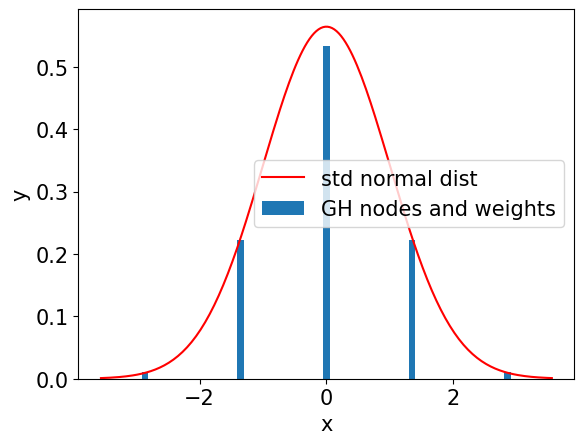

sum(w_int) =  1.0000001


In [2]:
n_int = 5 # integration nodes
x_int_norm, w_int = np.polynomial.hermite.hermgauss(n_int) # obtain standard GH nodes and weights
w_int = w_int / np.sqrt(np.pi) # divide the weights by sqrt(pi)
x_int_norm = x_int_norm * np.sqrt(2) # multiply weights with 2**0.5

#convert to tensorflow
x_int_norm = tf.constant(x_int_norm, dtype = tf.float32)
w_int = tf.constant(w_int, dtype = tf.float32)

# for plotting the normal distribution
x_plot_norm = np.linspace(np.min(x_int_norm) - 0.7, np.max(x_int_norm) + 0.7, 200)
y_plot_norm = np.exp(- 0.5 * x_plot_norm ** 2) / np.sqrt(np.pi)

plt.bar(x_int_norm, w_int, width = 0.1, label = "GH nodes and weights")
plt.plot(x_plot_norm, y_plot_norm, color = "r", label = "std normal dist")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

# we should make sure the weights some to 1
print("sum(w_int) = ", np.sum(w_int))

### Implementing the loss function

We define the economic parameters, which are constant troughout and will be globals in this notebook.

In [3]:
alpha = 0.36  # Capital share in the Cobb-Douglas production function
beta = 0.99  # Discount factor
delta = 0.1 # depreciation of capital
sigma_tfp = 0.04 # std. dev. for tfp process innvoations
rho_tfp = 0.9 # persistence of tfp process
x_int = x_int_norm * sigma_tfp # adjust the integration nodes

#### Deep neural network 

In this section, we define the architecture of the deep neural net.  
Our goal is for the neural network to approximate the savings rate $s_t$, such that $K_{t+1} = Y_t s_t \approx Y_t \mathcal{N}\left(K_t \right)$.  
The neural network input is hence a now 2-dimensional state $\mathbf{X}_t = [z_t, K_t]$ and the output is the 1-dimesnional savings rate $s_t$.


##### Hyper parameters

* Hyper parameter defines the architecture of the deep neural net. 

* Note that the purpose of this notebook is in the demonstration of the deep neural net. Detail analyses of the choice of hyper parameters are omitted and we use a densely connected feed forward neural network with two hidden layers as in [Azinovic et al. (2022)](https://onlinelibrary.wiley.com/doi/full/10.1111/iere.12575). Since we are approximating the savings rate, we want our architecture to ensure that $s_t \in (0, 1)$. We can do this by using a [sigmoid activation function](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6) in the output layer. This is in the spirit of encoding prior knowledge based on economics directly into the neural network architecture (relatedly, [Kahou et al (2021)](https://www.nber.org/papers/w28981) and [Han et al. (2022)](https://arxiv.org/abs/2112.14377) show how symmetry can be encoded into the neural-network architecture and [Azinovic and Žemlička (2023)](https://arxiv.org/abs/2303.14802) introduce market clearing neural network architectures.).  We assume the following structure of layers and activation functions: 
    * Layer 1: the input layer, 2 neurons corresponding to the tfp value $z_t$ and the capital stock $K_t$  
    * Layer 2: the first hidden layer, 50 neurons and is activated by Relu  
    * Layer 3: the second hidden layer, 50 neurons and is activated by Relu  
    * Layer 4: the output layer, 1 neurons corresponding to the savings rate $s_t$, such that $K_{t+1}=(1 - \delta) K_t + Y_t s_t$. We use a [sigmoid activation function](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6), ensuring that $s_t \in (0, 1)$.

In [4]:
# Layer setting
num_input = 2
num_hidden1 = 50
num_hidden2 = 50
num_output = 1
layers_dim = [num_input, num_hidden1, num_hidden2, num_output]
print("Dimensions of each layer are {}".format(layers_dim))

Dimensions of each layer are [2, 50, 50, 1]


##### We define the neural network
We use [Keras](https://www.tensorflow.org/guide/keras) to define the neural network

In [5]:
# we use sigmod in the output layer so output is between 0 and 1
nn = keras.Sequential([
    keras.layers.Dense(num_hidden1, activation='relu', input_shape=(num_input,)),
    keras.layers.Dense(num_hidden2, activation='relu'),
    keras.layers.Dense(num_output, activation = 'sigmoid')
])


In [6]:
print(nn.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                150       
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2,751
Trainable params: 2,751
Non-trainable params: 0
_________________________________________________________________
None


##### The batch dimension
Since neural networks are highly parallelizable, we typically do not want to evaluate the neural network for only a single state $\mathbf{X} \in \mathbb{R}^2$, but for a matrix of $N_{data}$ different states $X \in \mathbb{R}^{N_{data}\times 2}$. The output of the neural network is then a vector $\mathbf{s}\in \mathbb{R}^{N_{data}\times 1}$.  
The convention in deep learning is to have the different data samples on the 0-axis.

In [7]:
# test it
X_test = np.array([[1., 1.], [0.5, 2.]])

print("X_test = ", X_test)
print("nn prediction = ", nn(X_test))

X_test =  [[1.  1. ]
 [0.5 2. ]]
nn prediction =  tf.Tensor(
[[0.5032639 ]
 [0.49860474]], shape=(2, 1), dtype=float32)


#### Implementing the cost function
As outlined above, we want to implement a cost-function which takes a vector of states $\mathbf{X}\in \mathbb{R}^{N_{data}\times 2}$ and a neural network $\mathcal{N}(cdot)$, and then returns avector of errors in the equilibrium conditions implied by the policy, which is encoded by the neural network.  
As explained above, the equilibrium condition is given by
\begin{align}
0 &= \frac{1}{C_t \beta E\left[\frac{1}{C_{t+1}}\left(1 - \delta + r_{t+1}\right)\right]} - 1.
\end{align}
We use the [tf.function decorator](https://www.tensorflow.org/guide/function), which speeds up the evaluation of the cost function.

To compute the expecation operatore we will iterate over the ```n_int``` states in the period $t+1$.
Hence we start out with programming a helper function that takes states $X_{t+1}$ and the neural network as input and returns the term inside the expectation $\frac{1}{C_{t+1}}\left(1 - \delta + r_{t+1}\right)$. 

In [8]:
@tf.function
def get_singleinside(X_tplus1, nn):
    n_data = X_tplus1.shape[0] # number of states is on the axis 0
    dim_state = X_tplus1.shape[1] # dimensionality of the state is on axis 1
    
    
    # read out the state 
    Z_tplus1 = X_tplus1[:, 0 : 1]
    K_tplus1 = X_tplus1[:, 1 : 2]
    
    """ 
    Exercise:
    complete this function to return the term inside the expectation operator:
    ret = (1. / C_tplus1) * (1. - delta + r_tplus1)
    """
    Y_tplus1 = tf.math.exp(Z_tplus1) * K_tplus1 ** alpha
    s_tplus1 = nn(X_tplus1)
    K_tplus2 = s_tplus1 * Y_tplus1
    C_tplus1 = Y_tplus1 + (1 - delta) * K_tplus1 - K_tplus2
    r_tplus1 = alpha * tf.math.exp(Z_tplus1) * K_tplus1 ** (alpha - 1)
    
    """
    Solution:
    """
    ret = (1. / C_tplus1) * (1. - delta + r_tplus1)
    #=====================================================================

    #=====================================================================
    
    return ret

In [9]:
# let's try
X_tplus1 = tf.constant([[1., 1.], [2., 2.], [2., 1.3]])

print("ret = ", get_singleinside(X_tplus1, nn))

ret =  tf.Tensor(
[[0.8947673 ]
 [0.4789576 ]
 [0.73038214]], shape=(3, 1), dtype=float32)


2023-08-23 12:11:43.285547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Now we are ready to compute the cost function.

In [10]:
@tf.function
def compute_cost(X, nn):
    """ 
    Compute the mean squared error in the equilibrium conditions.
    """
    n_data = X.shape[0] # number of states is on the axis 0
    dim_state = X.shape[1] # dimensionality of the state is on axis 1
    
    # read out the state
    Z_t = X[:, 0 : 1]
    K_t = X[:, 1 : 2]
    
    """
    Exercise:
    Compute the following period t terms:
    Y_t, r_t, s_t, C_t
    then obtain:
    K_tplus1
    """
    #=====================================================================
    # compute output today
    Y_t = Z_t * K_t ** alpha
    
    # compute return (not really needed)
    r_t = alpha * Z_t * K_t ** (alpha - 1.)
    
    # use the neural network to predict the savings rate
    s_t = nn(X)

    # get consumption
    C_t = Y_t - Y_t * s_t
        
    # get the implied capital in the next period
    K_tplus1 = (1. - delta) * K_t + Y_t * s_t
    #=====================================================================
    
    # now we have to compute the expectation
    expectation = tf.zeros((n_data, 1))
    
    # we loop over the integration nodes
    for i in range(n_int):
        # integration weight
        weight_i = w_int[i]
        
        # innovation to the AR(1)
        innovation_i = x_int[i]
        
        # construct exogenous shock at t+1
        Z_tplus1 = tf.exp(rho_tfp * tf.math.log(Z_t) + innovation_i)
        
        # construct state at t+1
        X_tplus1 = tf.concat([Z_tplus1, K_tplus1], axis = 1)
        
        # compute term inside the expeectation
        inside_i = get_singleinside(X_tplus1, nn)
        
        # add term to the expectaion with the appropriate weight
        expectation = expectation + weight_i * inside_i

    # now we have all terms to construct the relative Euler error
    
    """
    Exercise:
    Construct errREE, the relative Euler error
    """
    errREE = 1 / (C_t * beta * expectation) - 1
    """
    Solution:
    """
    #=====================================================================
    # Define the relative Euler error

    
    #=====================================================================
    
    # compute the cost, i.e. the mean square error in the equilibrium conditions
    cost = tf.reduce_mean(errREE ** 2)
    
    # we return some more things for plotting
    LHS = 1. / C_t # LHS of Ee
    RHS = beta * expectation # RHS of Ee

    return cost, errREE, C_t, K_tplus1, r_t, LHS, RHS

In [11]:
# let's try
X = tf.constant([[0.5, 1.], [0.9, 2.], [1.1, 3.]])

print("cost = ", compute_cost(X, nn)[0])

2023-08-23 12:15:07.711800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


cost =  tf.Tensor(19.940567, shape=(), dtype=float32)


#### Gradients
Now we define a function that, for given data X, computes the gradient of the loss w.r.t. the neural network parameters.  
This gradient will be used to update the neural network parameters into the direction which decreases the loss function.

In [12]:
def grad(X, nn):
    with tf.GradientTape() as tape:
        loss_value = compute_cost(X, nn)[0]
    return loss_value, tape.gradient(loss_value, nn.trainable_variables)

In [13]:
X = tf.constant([[1., 0.8], [2., 1.3], [0.5, 3.]])

loss, grads = grad(X, nn)

print("loss = ", loss)

2023-08-23 12:15:14.866109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-23 12:15:15.524711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


loss =  tf.Tensor(29.111526, shape=(), dtype=float32)


#### Optimizer
We now define an optimizer, essentially an improved version of SGD

In [14]:
learning_rate = 0.0003
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [15]:
num_episodes = 20001
n_data_per_epi = 128
z_lb = 0.7
z_ub = 1.3
k_lb = 0.9
k_ub = 12.0

## Simulating the model from the policy
Given a policy function, we can simulate the model forward.
Say we start out with a state $\mathbf{X}_t=[z_t, K_t]$.  
We can use the neural network to obtain $K_{t+1} = Y_t \cdot \mathcal{N}(\mathbf{X}_t)$.  
Then, we can draw a random innovation $\epsilon_t\sim N(0, 1)$ using a pseudo-random number generator and obtain $Z_{t+1}=\rho Z_t + \sigma \epsilon_t$.  
Now we have $\mathbf{X}_{t+1}=[Z_{t+1}, K_t+1]$.  
We can repeat the same procedure to obtain $\mathbf{X}_{t+2}$ and so on and so forth.  
Next, we will implement a function that takes a batch of states, a batch of innovations, and the neural network and then simulates the states one period forward baseed on  the policy encoded by the neural network.  
Afterward, we will write a second function to simulate longer sequences.

In [22]:
@tf.function
def simulate_single_step(X_t, eps_tplus1, nn):
    # function simulates the economy one step forward based on the neural network policy and the innovation
    
    n_data = X_t.shape[0] # number of states is on the axis 0
    dim_state = X_t.shape[1] # dimensionality of the state is on axis 1
    
    # read out the state
    Z_t = X_t[:, 0 : 1]
    K_t = X_t[:, 1 : 2]
    
    # get tfp in the next period
    Z_tplus1 = tf.exp(rho_tfp * tf.math.log(Z_t) + sigma_tfp * eps_tplus1) 
    
    """
    Exercise:
    construct K_tplus1
    """
    
    """
    Solution
    """
    #=====================================================================
    Y_t = Z_t * K_t ** alpha
    
    # # compute return (not really needed)
    # r_t = alpha * Z_t * K_t ** (alpha - 1.)
    
    # use the neural network to predict the savings rate
    s_t = nn(X_t)

    # # get consumption
    # C_t = Y_t - Y_t * s_t
        
    # get the implied capital in the next period
    K_tplus1 = (1. - delta) * K_t + Y_t * s_t
    #=====================================================================
   
    # construct the next step
    X_tplus1 = tf.concat([Z_tplus1, K_tplus1], axis = 1)
    
    return X_tplus1

def sim_periods(X_start, nn, num_periods):
    n_tracks = X_start.shape[0] # number of states is on the axis 0
    dim_state = X_start.shape[1] # dimensionality of the state is on axis 1
    
    # create an empty array to store the states
    X_simulation = np.empty((num_periods, n_tracks, dim_state)) # 0 axis: time period, 1 axis: the different trajectories, 2 axis: the different state variables
    
    # draw random innovation
    eps = tf.random.normal((num_periods, n_tracks), dtype = tf.float32)
    
    # set starting state
    X_simulation[0, :, :] = X_start
    
    X_old = X_start
    
    # simulate the periods
    for t in range(1, num_periods):
        eps_use = eps[t, :, tf.newaxis] # newaxis makes sure the shape is n_tracks x 1
        
        X_new = simulate_single_step(X_old, eps_use, nn)
        
        X_simulation[t, :, :] = X_new
        
        X_old = X_new
        
    return X_simulation

In [23]:
# let's pick a starting state
X_start = np.array([[0.5 * (z_ub + z_lb), 0.5 * (k_ub + k_lb)]], dtype = np.float32)

# and simulate it some periods forward using the neural network
num_periods = 50
X_simulation = sim_periods(X_start, nn, num_periods)

2023-08-23 12:40:44.429539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


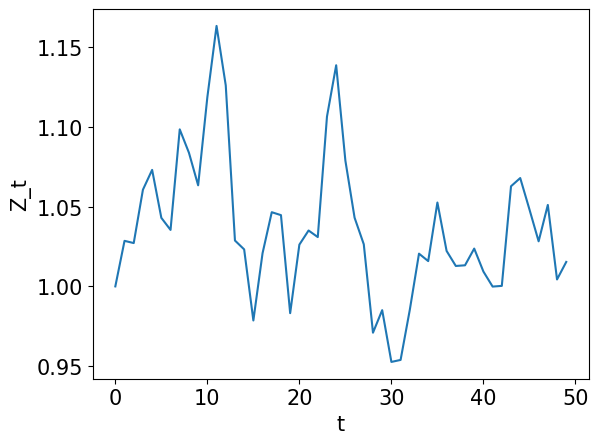

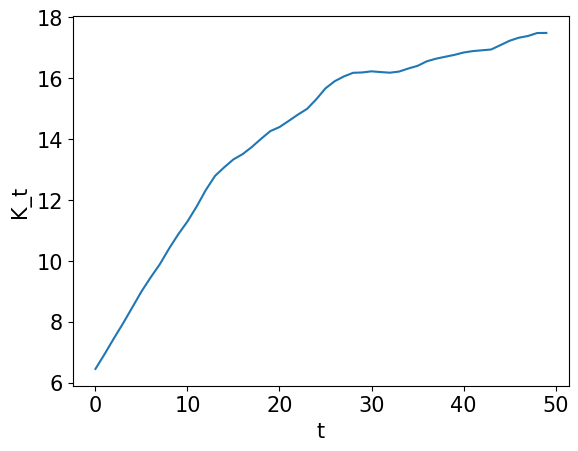

In [24]:
plt.plot(X_simulation[:, 0, 0])
plt.xlabel("t")
plt.ylabel("Z_t")
plt.show()

plt.plot(X_simulation[:, 0, 1])
plt.xlabel("t")
plt.ylabel("K_t")
plt.show()

## Iterating between training and simulation

In [26]:
def get_training_data(z_lb, z_ub, k_lb, k_ub, n_data):
    
    Z = tf.random.uniform(
    shape = [n_data, 1],
    minval=z_lb,
    maxval=z_ub,
    dtype=tf.dtypes.float32)
    
    
    K = tf.random.uniform(
    shape = [n_data, 1],
    minval=k_lb,
    maxval=k_ub,
    dtype=tf.dtypes.float32)
    
    X = tf.concat([Z, K], axis = 1)
    return X

In [27]:
def get_training_data_simulation(X_start, nn, n_periods):
    n_tracks = X_start.shape[0]
    n_dim = X_start.shape[1]
    
    # we simulate the model
    X_simulation = sim_periods(X_start, nn, n_periods)
    
    # we read out the last state (so that we can use it as starting poit for the next simulation)
    X_end = np.float32(X_simulation[-1, :, :])
    
    # we reshape the data into (n_tracks * n_periods) x 2 array 
    X_training = np.float32(np.reshape(X_simulation, (n_tracks * n_periods, n_dim)))
    
    return X_training, X_end 

In [28]:
"""
Exercise:
define a Sequential neural network called 'nn', with input dimension 'num_input', 
'num_hidden1' relu-activated hidden nodes in first hidden layer,
'num_hidden2' relu-activated hidden nodes in second hidden layer,
and 'num_output' sigmoid activated nodes in the output layer.
"""

"""
Solution:
"""
#=====================================================================
# let's get a new neural network
# Layer setting
num_input = 2
num_hidden1 = 50
num_hidden2 = 50
num_output = 1
layers_dim = [num_input, num_hidden1, num_hidden2, num_output]
print("Dimensions of each layer are {}".format(layers_dim))
nn = keras.Sequential([
    keras.layers.Dense(num_hidden1, activation='relu', input_shape=(num_input,)),
    keras.layers.Dense(num_hidden2, activation='relu'),
    keras.layers.Dense(num_output, activation = 'sigmoid')
])

#=====================================================================

n_tracks = 50
n_periods = 3
print("n_tracks = ", n_tracks)
print("n_periods = ", n_periods)

# start from a random state
X_start = get_training_data(z_lb, z_ub, k_lb, k_ub, n_tracks)
print("X_start.shape = ", X_start.shape)

print("With every simulation we get", n_tracks * n_periods, "new states")

X_training, X_end = get_training_data_simulation(X_start, nn, n_periods)
print("X_training.shape = ", X_training.shape)
print("X_end.shape = ", X_end.shape)

learning_rate = 0.0001
print("learning_rate = ", learning_rate)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

print(compute_cost(X_start, nn)[0])

Dimensions of each layer are [2, 50, 50, 1]
n_tracks =  50
n_periods =  3
X_start.shape =  (50, 2)
With every simulation we get 150 new states


2023-08-23 12:44:57.468309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


X_training.shape =  (150, 2)
X_end.shape =  (50, 2)
learning_rate =  0.0001


2023-08-23 12:44:57.717415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


tf.Tensor(20.501413, shape=(), dtype=float32)


n_tracks =  50
n_periods =  3


2023-08-23 12:45:17.113889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-23 12:45:17.939987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


#=================================================================
episode = 0, loss [log10] = 1.2776576280593872


2023-08-23 12:45:19.922765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


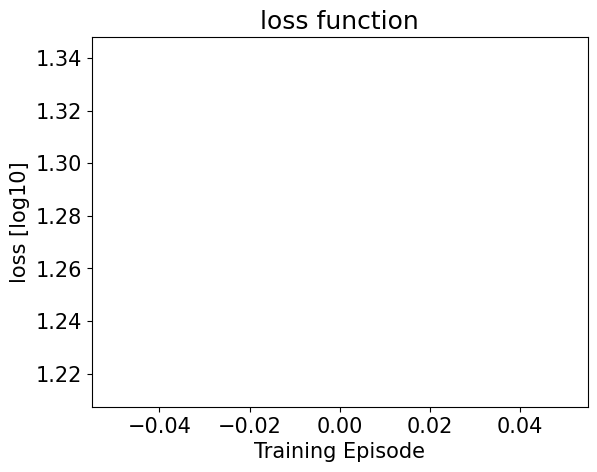

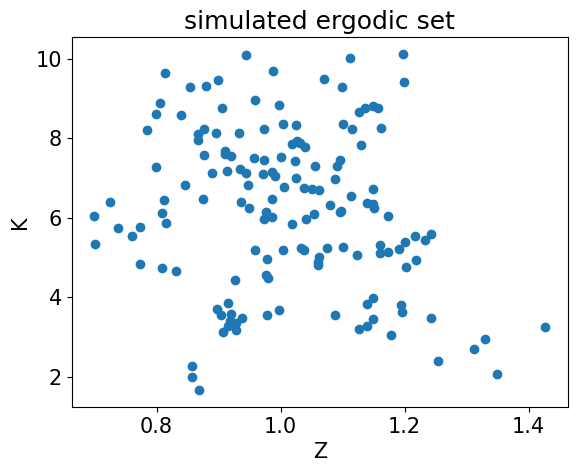

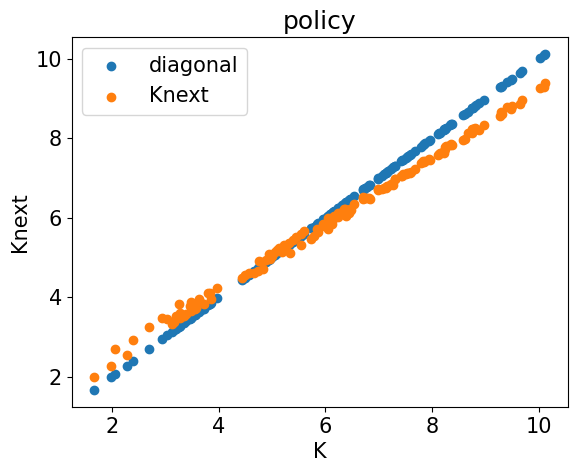

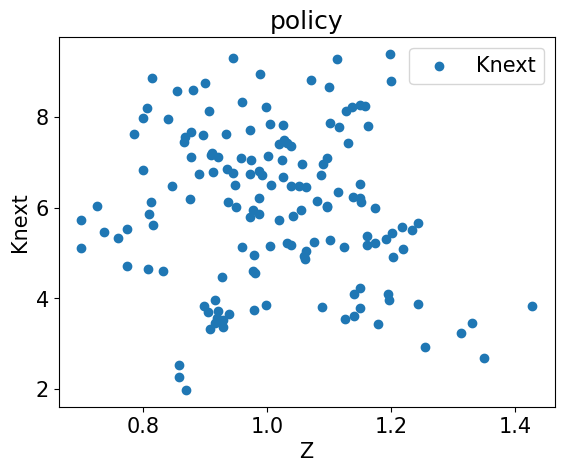

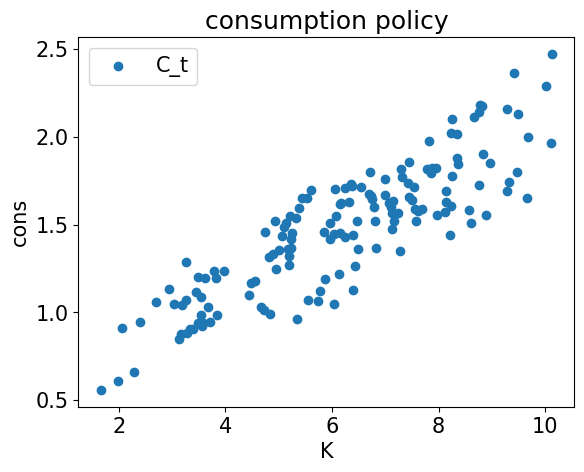

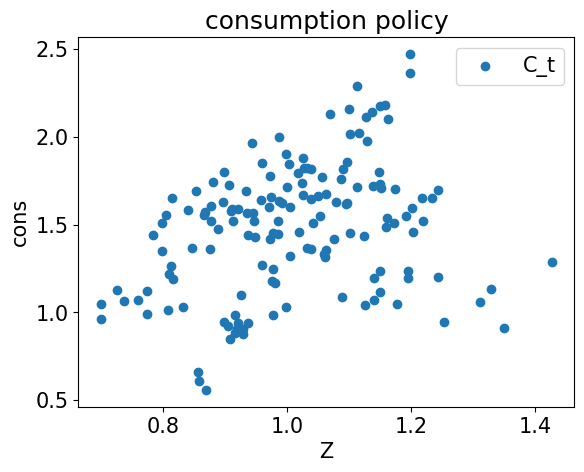

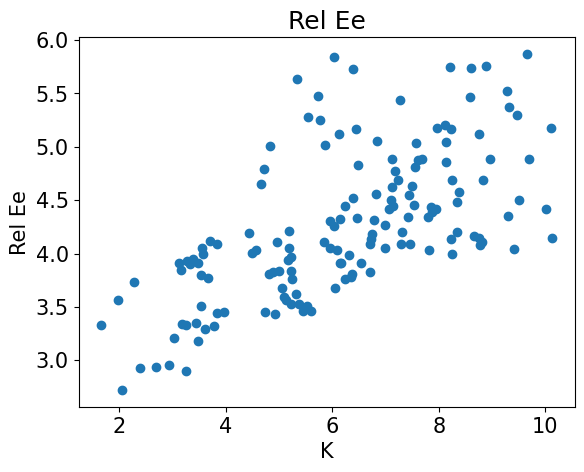

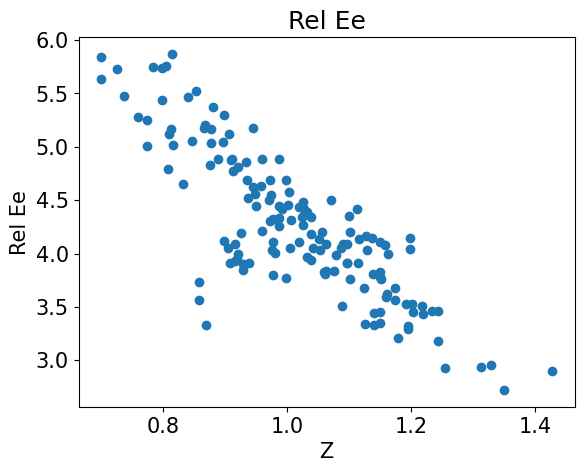

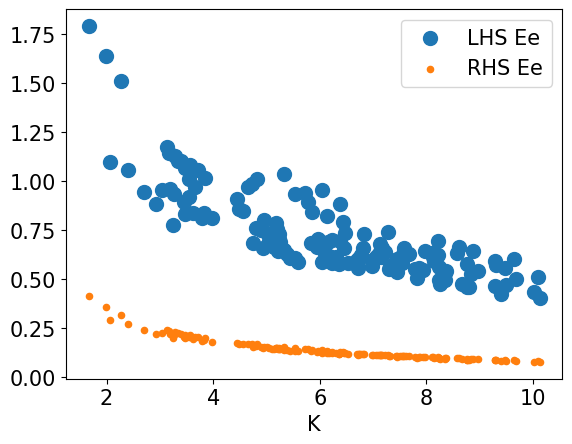

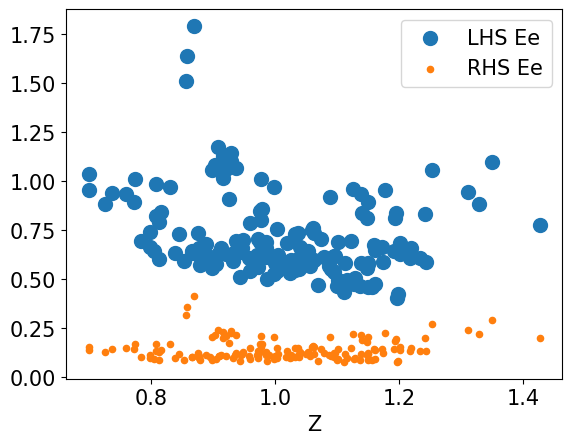

#=================================================================
episode = 1000, loss [log10] = -0.11953352391719818
#=================================================================
episode = 2000, loss [log10] = -0.8893718123435974
#=================================================================
episode = 3000, loss [log10] = -1.3121699094772339
#=================================================================
episode = 4000, loss [log10] = -1.8019587993621826


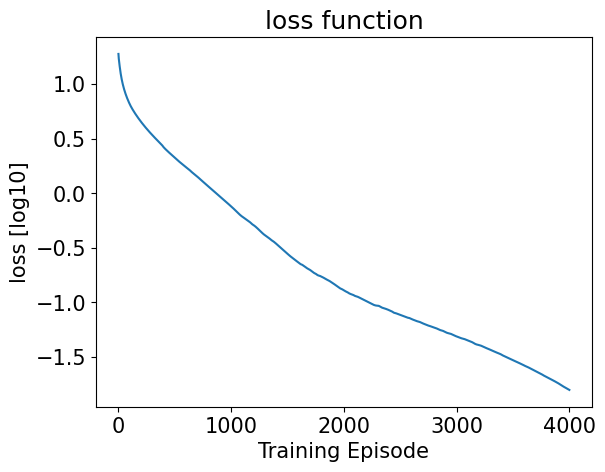

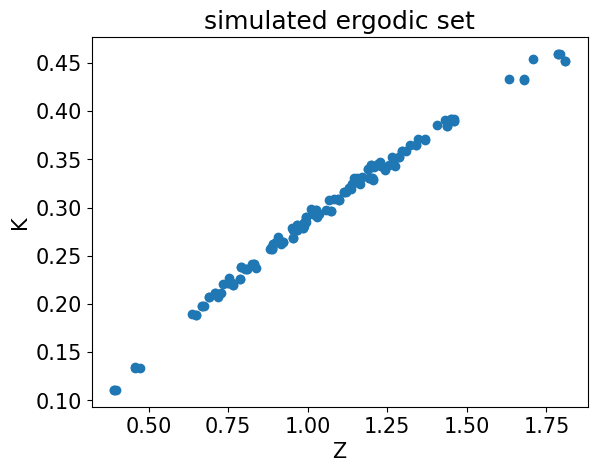

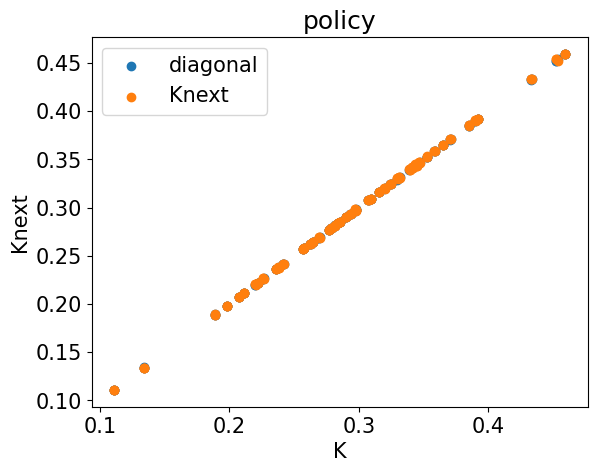

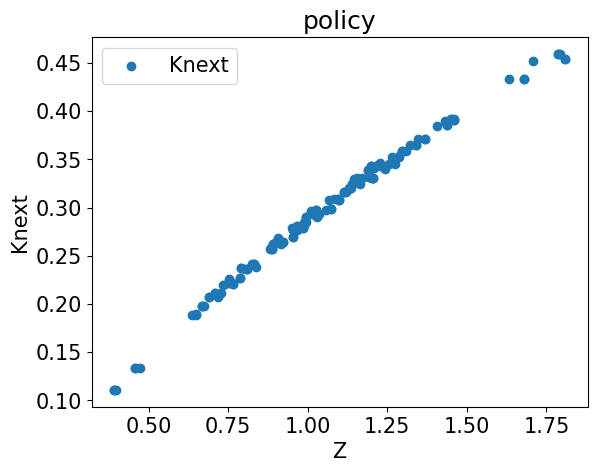

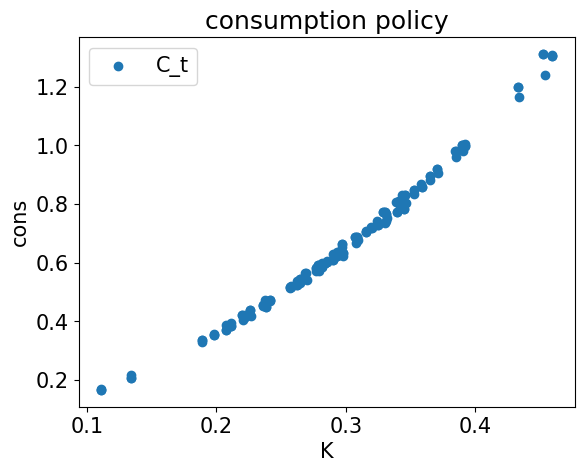

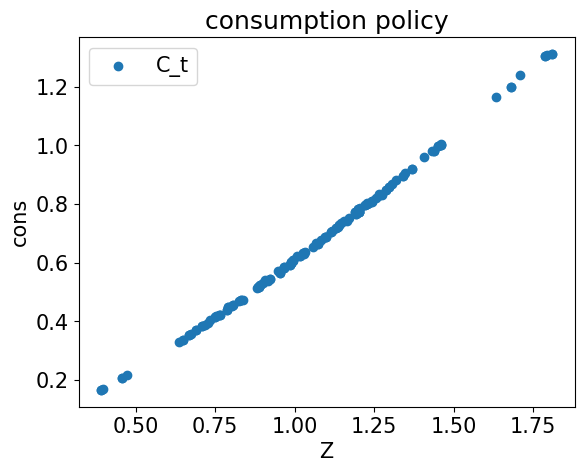

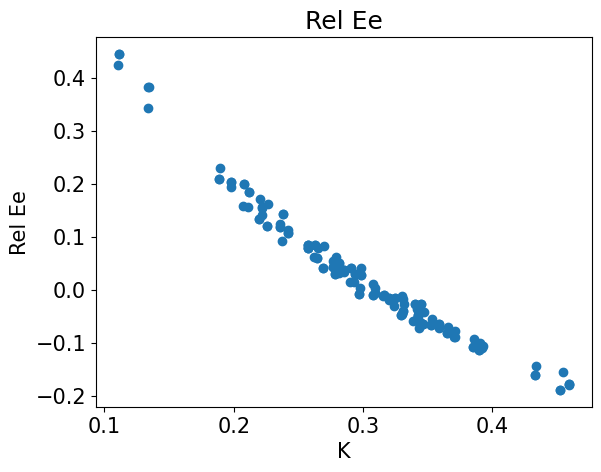

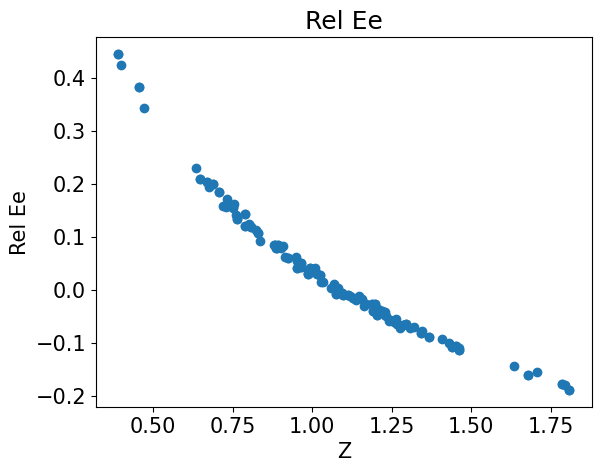

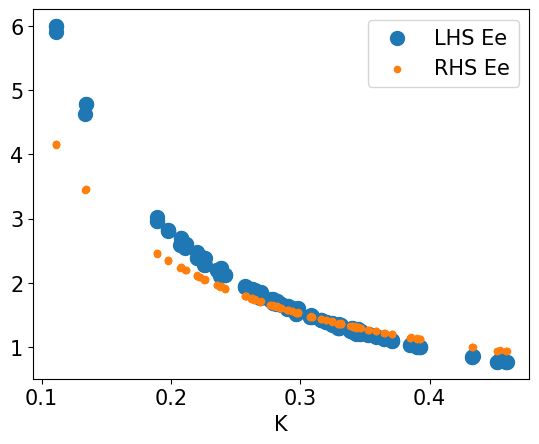

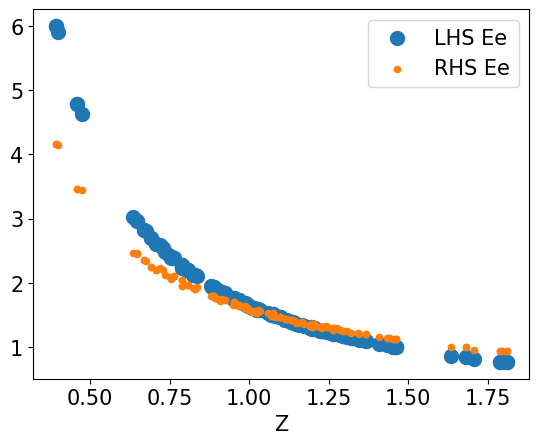

#=================================================================
episode = 5000, loss [log10] = -2.684790849685669
#=================================================================
episode = 6000, loss [log10] = -3.853522539138794
#=================================================================
episode = 7000, loss [log10] = -3.86247181892395
#=================================================================
episode = 8000, loss [log10] = -3.869619369506836


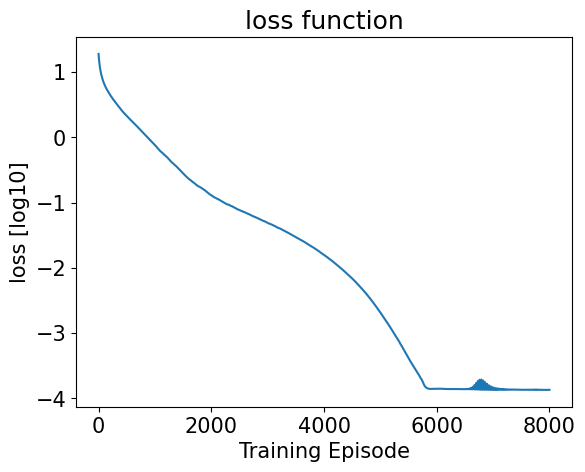

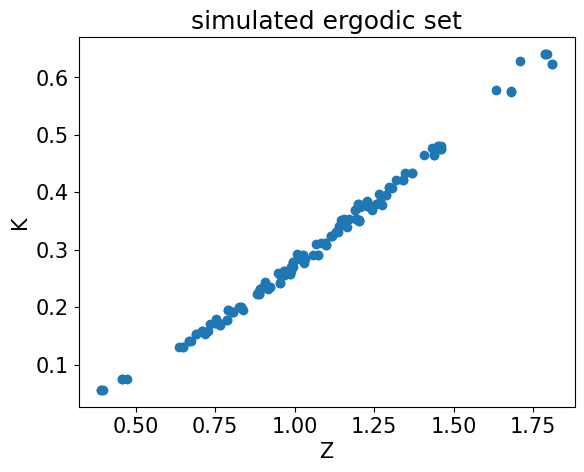

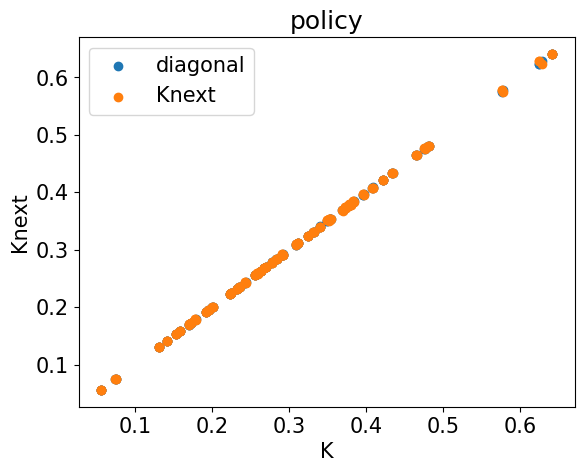

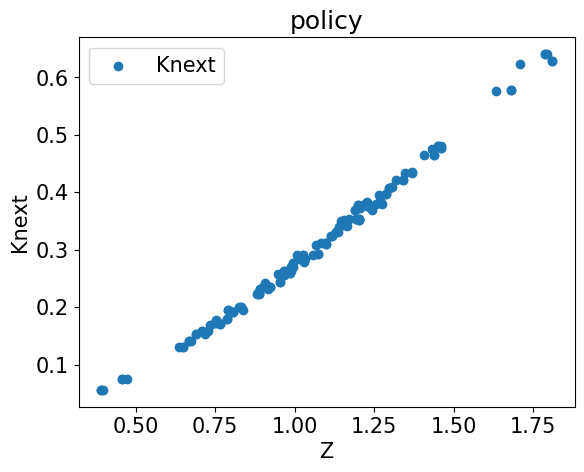

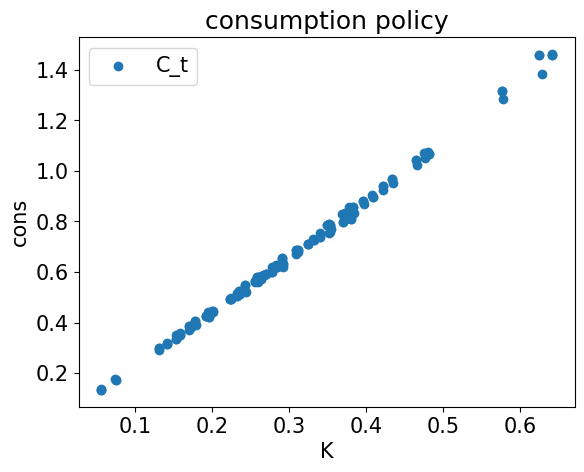

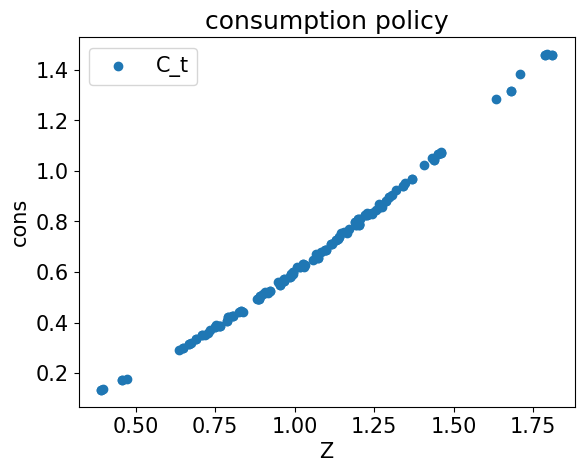

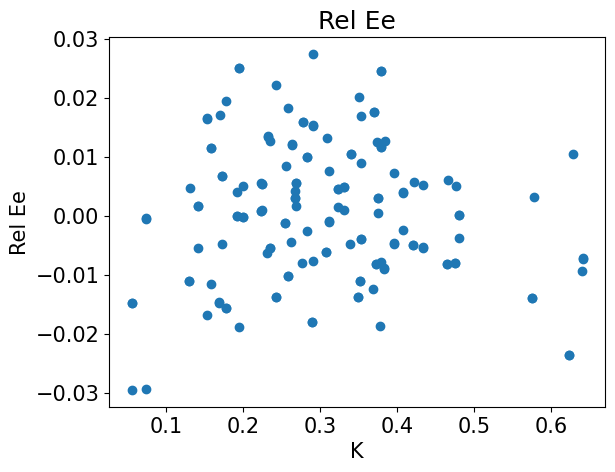

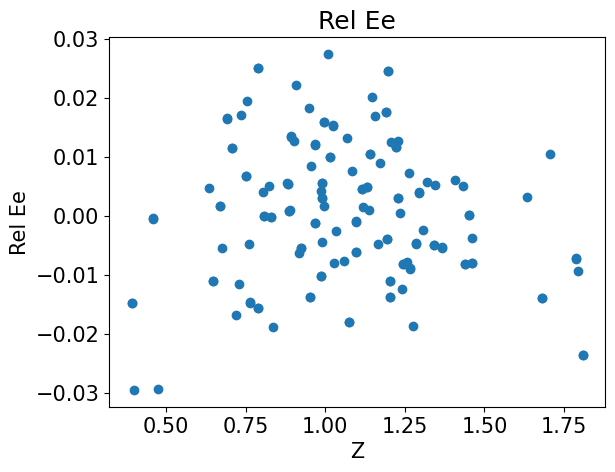

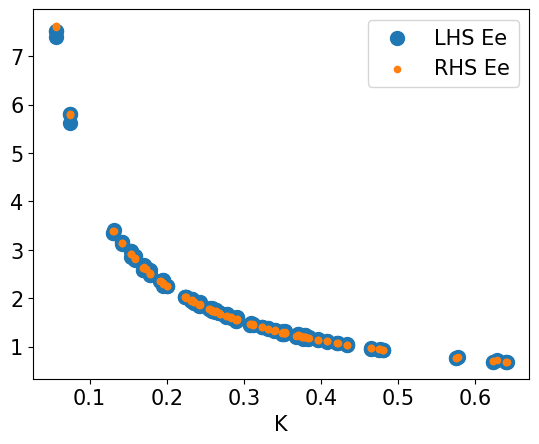

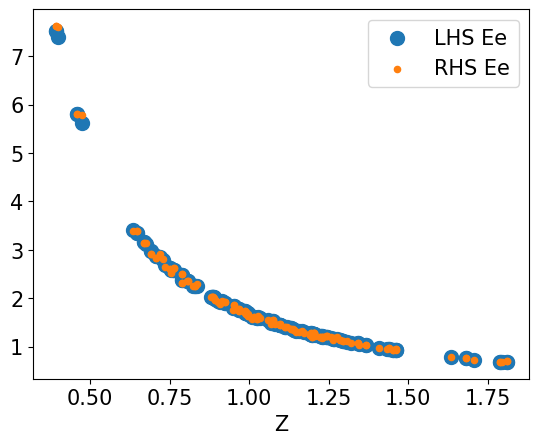

#=================================================================
episode = 9000, loss [log10] = -3.8750193119049072
#=================================================================
episode = 10000, loss [log10] = -3.875070095062256
#=================================================================
episode = 11000, loss [log10] = -3.874483823776245
#=================================================================
episode = 12000, loss [log10] = -3.841315507888794


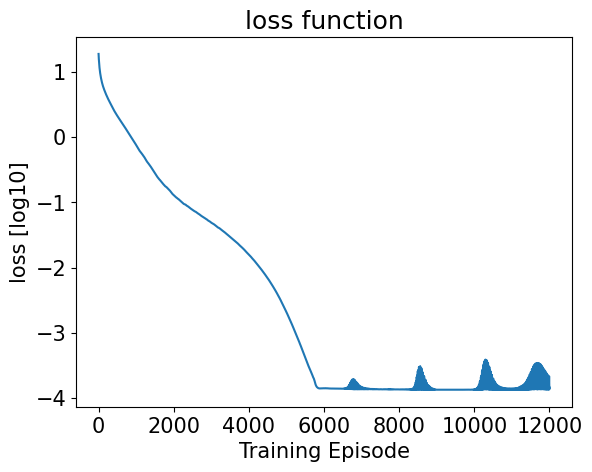

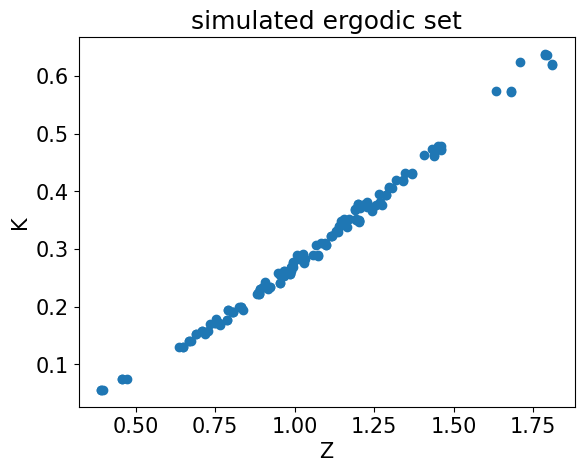

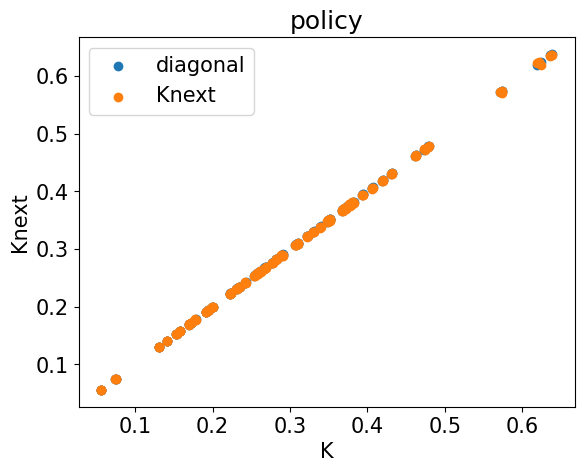

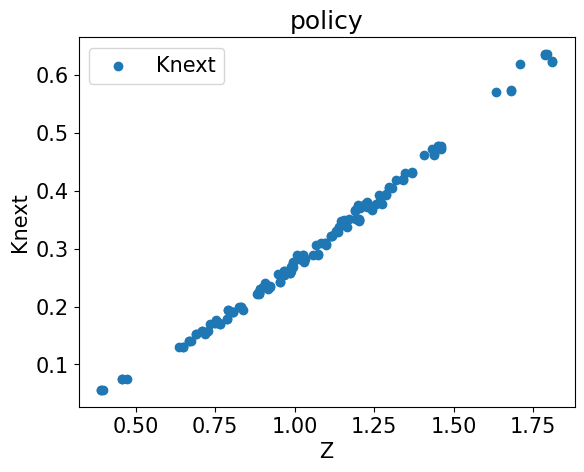

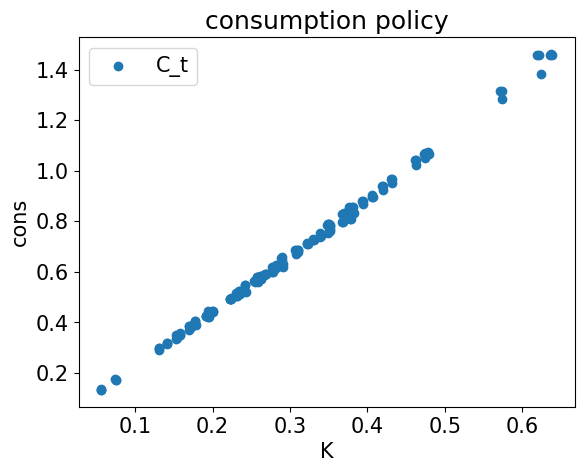

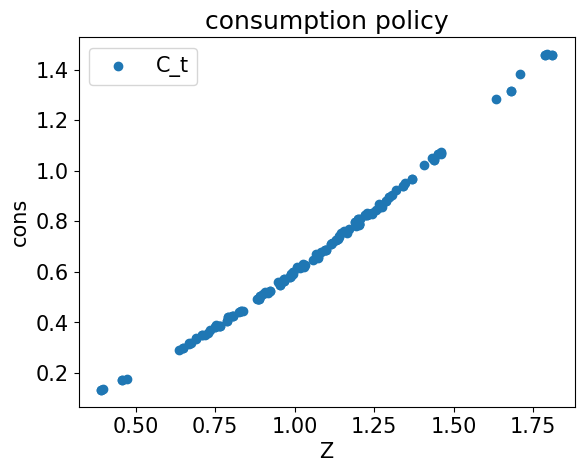

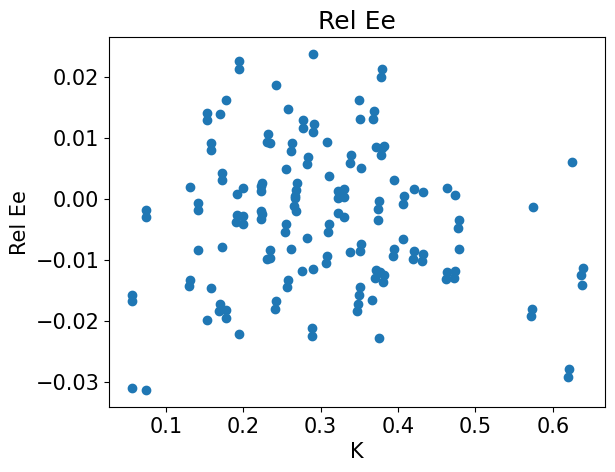

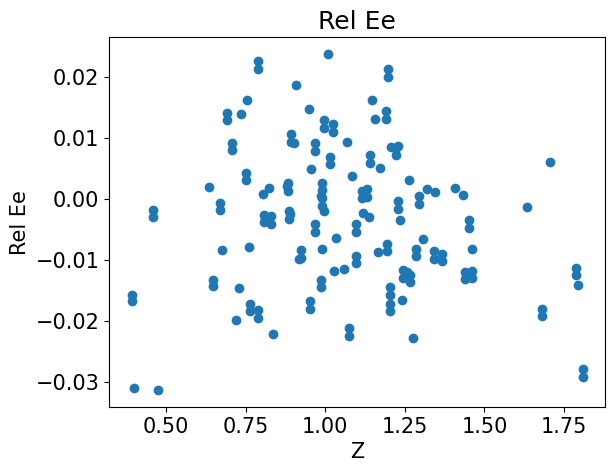

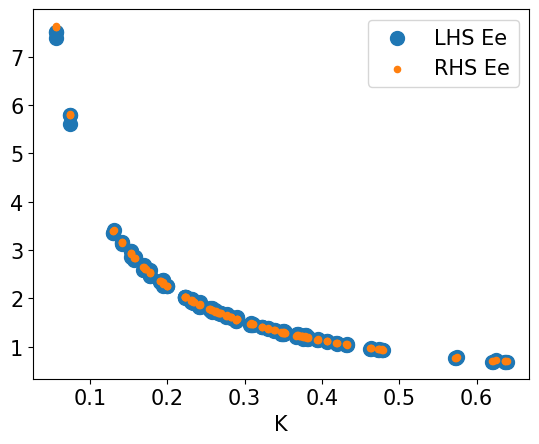

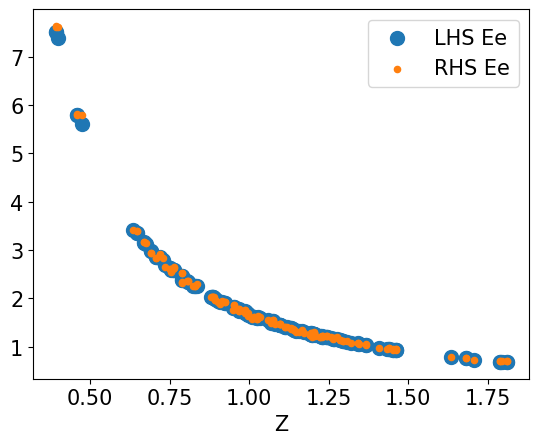

#=================================================================
episode = 13000, loss [log10] = -3.708306074142456
#=================================================================
episode = 14000, loss [log10] = -3.7369017601013184
#=================================================================
episode = 15000, loss [log10] = -3.6507673263549805
#=================================================================
episode = 16000, loss [log10] = -3.7790098190307617


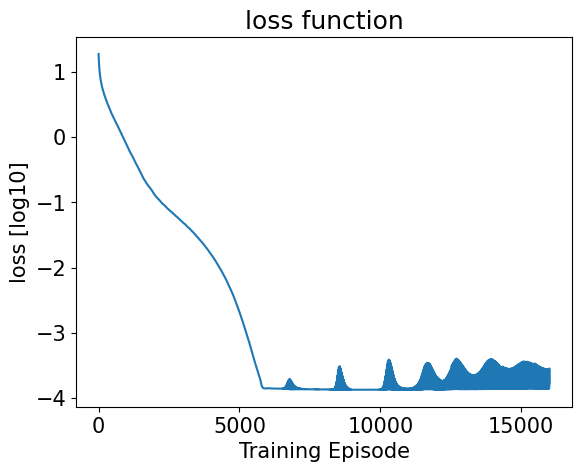

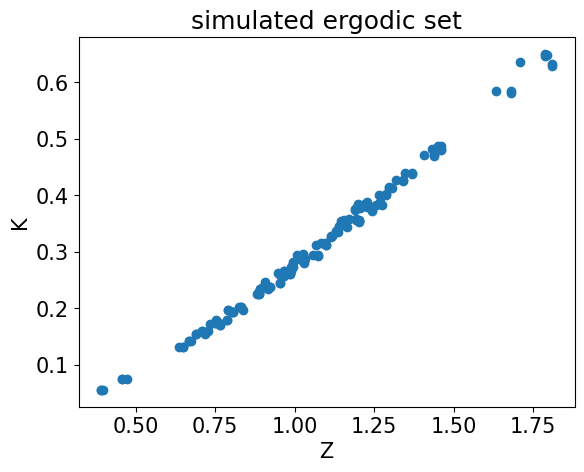

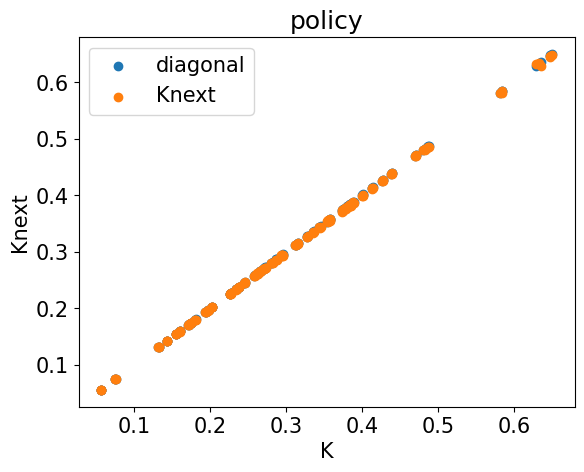

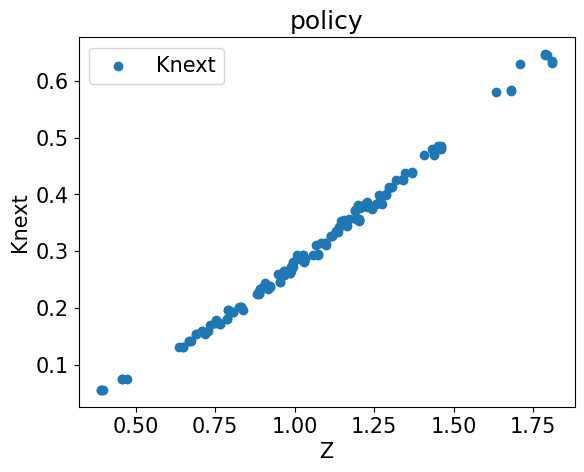

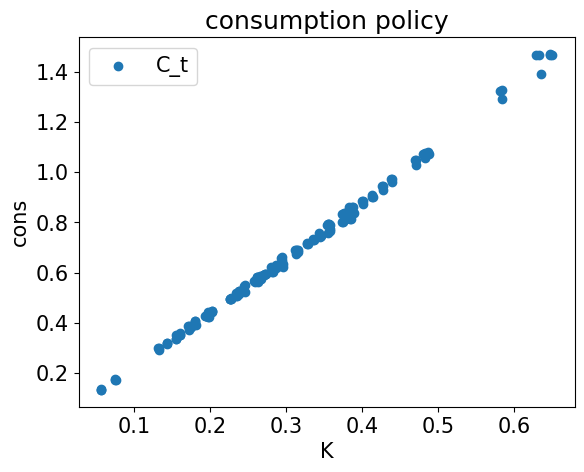

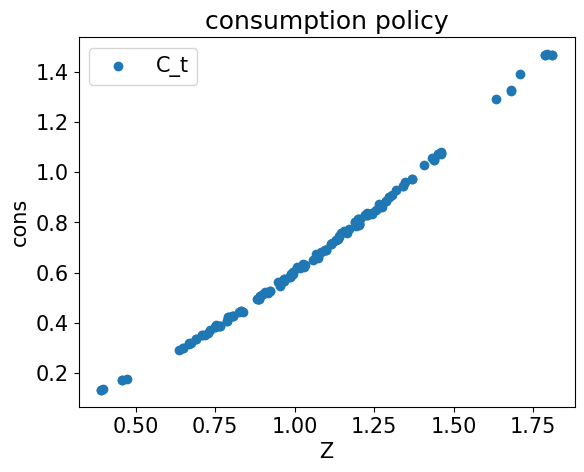

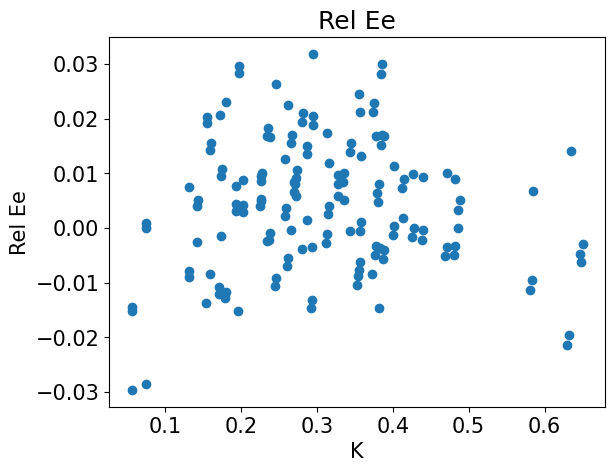

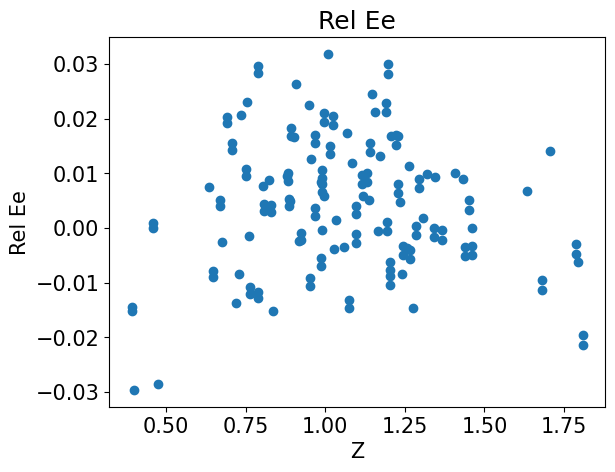

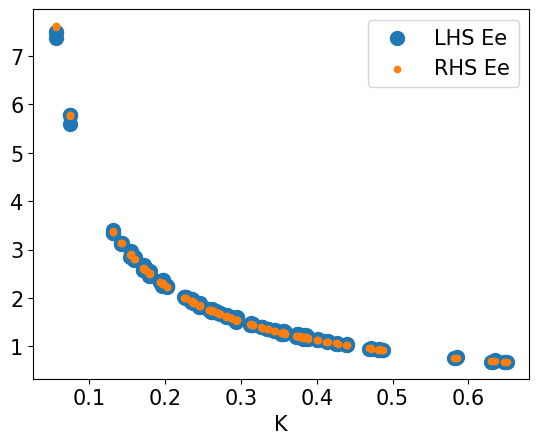

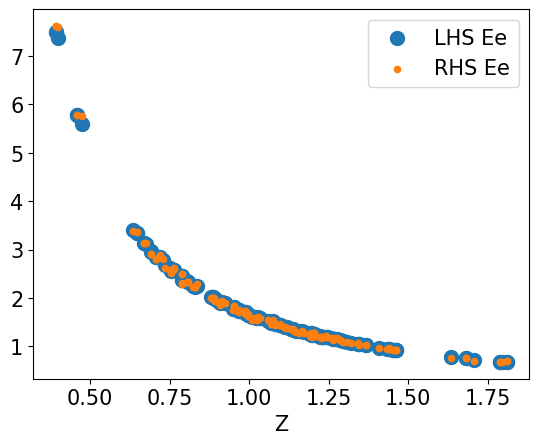

#=================================================================
episode = 17000, loss [log10] = -3.836545705795288
#=================================================================
episode = 18000, loss [log10] = -3.6226885318756104
#=================================================================
episode = 19000, loss [log10] = -3.850911855697632
#=================================================================
episode = 20000, loss [log10] = -3.711390256881714


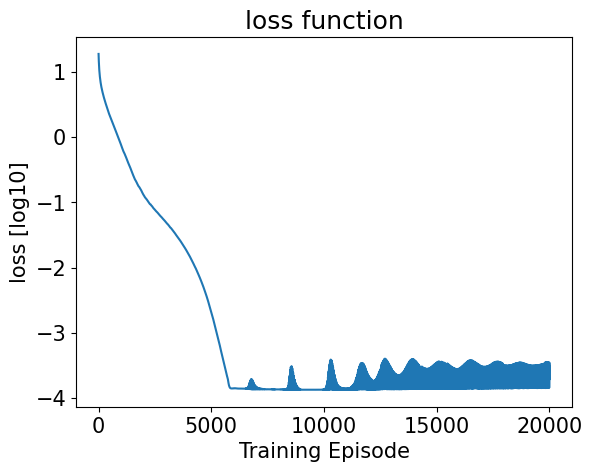

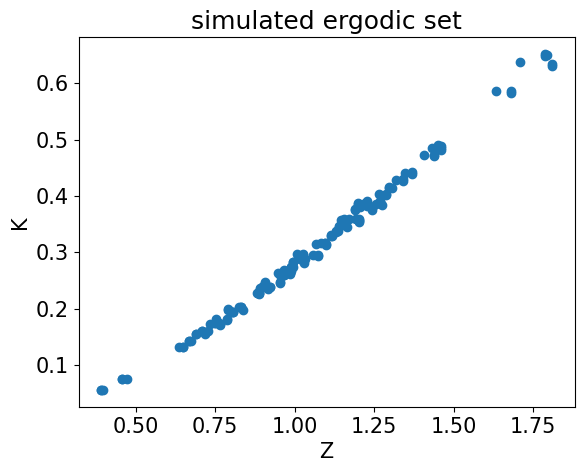

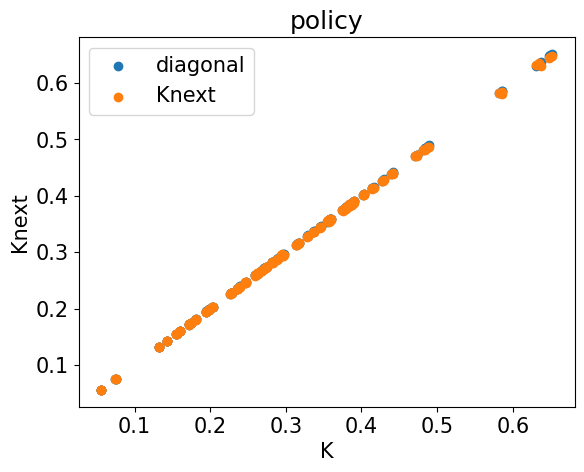

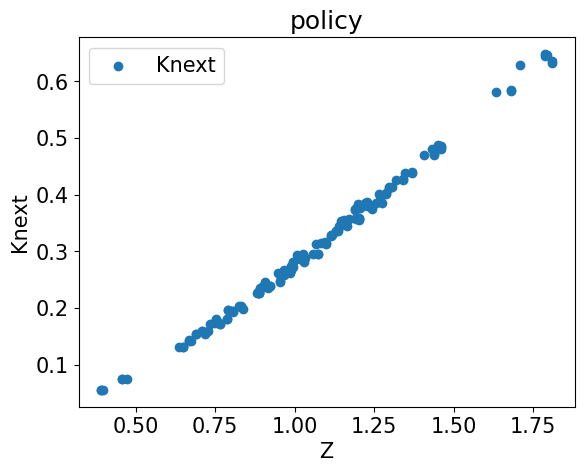

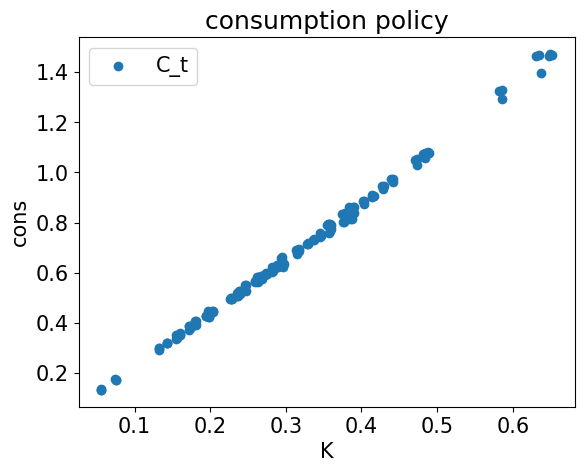

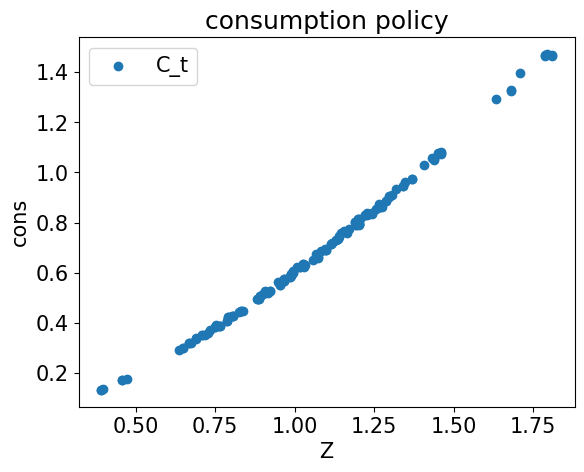

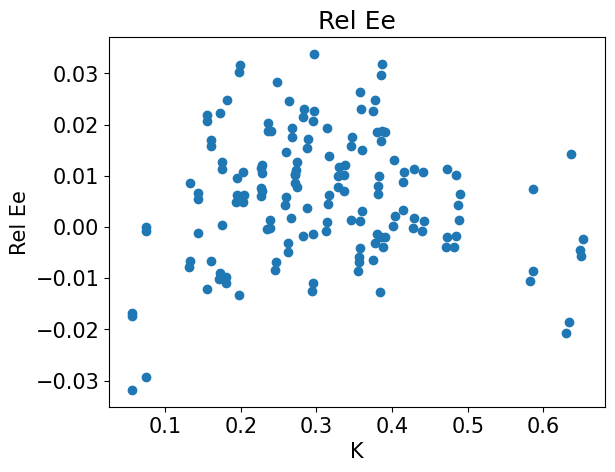

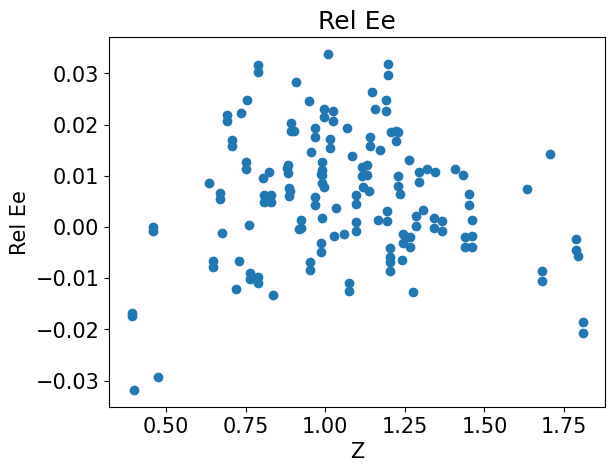

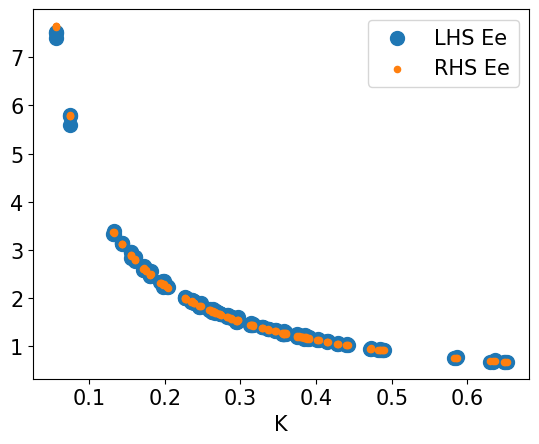

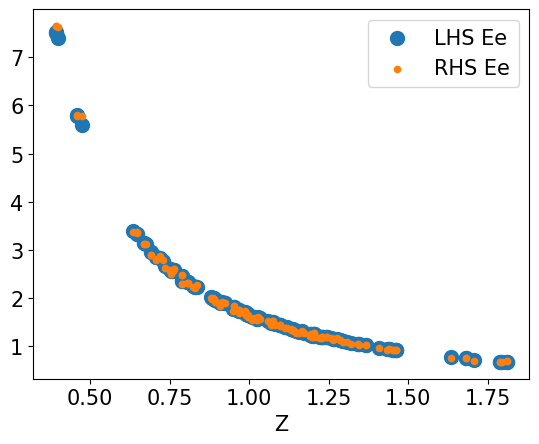

In [29]:
# Keep results for plotting
train_loss = []

num_episodes = 20001

# initialize X_start
X_start = X_end
print("n_tracks = ", X_start.shape[0])
print("n_periods = ", n_periods)

for ep in range(num_episodes):
    # generate training data, now by sampling
    X, X_end = get_training_data_simulation(X_start, nn, n_periods)

    # update X_start
    X_start = X_end
    
    # compute loss and gradients
    loss, grads = grad(X, nn)

    
    # apply gradients
    optimizer.apply_gradients(zip(grads, nn.trainable_variables))
    
    # record loss
    train_loss.append(loss.numpy())
    
    # print progress
    if ep % int(0.05 * num_episodes) == 0:
        print("#=================================================================")
        print("episode = {}, loss [log10] = {}".format(ep, np.log10(loss.numpy())))
        
    if ep % int(0.2 * num_episodes) == 0 or ep == num_episodes - 1:
        cost, errREE, C_t, K_tplus1, r_t, LHS, RHS = compute_cost(X, nn)
        
        plt.title("loss function")
        plt.plot(np.log10(np.array(train_loss)))
        plt.xlabel("Training Episode")
        plt.ylabel("loss [log10]")
        plt.show()
        plt.close()
        
        plt.title("simulated ergodic set")
        plt.scatter(X[:, 0], X[:, 1])
        plt.xlabel("Z")
        plt.ylabel("K")
        plt.show()
        plt.close()
        
        
        plt.title("policy")
        plt.xlabel("K")
        plt.ylabel("Knext")
        plt.scatter(X[:, 1], X[:, 1], label = "diagonal")
        plt.scatter(X[:, 1], K_tplus1[:, 0], label = "Knext")
        plt.legend()
        plt.show()
        plt.close()

        plt.title("policy")
        plt.xlabel("Z")
        plt.ylabel("Knext")
        plt.scatter(X[:, 0], K_tplus1[:, 0], label = "Knext")
        plt.legend()
        plt.show()
        plt.close()

        plt.title("consumption policy")
        plt.xlabel("K")
        plt.ylabel("cons")
        plt.scatter(X[:, 1], C_t[:, 0], label="C_t")
        plt.legend()
        plt.show()
        plt.close()

        plt.title("consumption policy")
        plt.xlabel("Z")
        plt.ylabel("cons")
        plt.scatter(X[:, 0], C_t[:, 0], label="C_t")
        plt.legend()
        plt.show()
        plt.close()

        plt.title("Rel Ee")
        plt.xlabel("K")
        plt.ylabel("Rel Ee")
        plt.scatter(X[:, 1], errREE[:, 0], label="REE")
        plt.show()
        plt.close()
       
        plt.title("Rel Ee")
        plt.xlabel("Z")
        plt.ylabel("Rel Ee")
        plt.scatter(X[:, 0], errREE[:, 0], label="REE")
        plt.show()
        plt.close()
        
        plt.xlabel("K")
        plt.scatter(X[:, 1], LHS[:, 0], s = 100, label="LHS Ee")
        plt.scatter(X[:, 1], RHS[:, 0], s = 20, label="RHS Ee")
        plt.legend()
        plt.show()
        plt.close()
        
        plt.xlabel("Z")
        plt.scatter(X[:, 0], LHS[:, 0], s = 100, label="LHS Ee")
        plt.scatter(X[:, 0], RHS[:, 0], s = 20, label="RHS Ee")
        plt.legend()
        plt.show()
        plt.close()


### Exercise 2
Now let's make the model a little bit more interesting and add endogenous labor supply.  
The planner again aims to maximize his time-separable life time utility subject to her budget constraint:
\begin{align}
&\max_{\left\{c_{t}\right\}_{t=0}^{\infty}} \sum_{t=0}^{\infty} \beta^{t}E\left[ \ln\left(C_{t}\right) - \psi\frac{L_t^{1+\theta}}{1+\theta}  \right]\\
\text{s.t.} \quad & K_{t+1} + C_{t} = Y_t + (1 - \delta) K_t
\end{align}
where output now depends on only on capital, but also on the amount of labor supplied 
\begin{align}
Y_t &= z_t L_t^{1-\alpha} K_{t} ^ \alpha \\
\log(z_t) &= \rho \log(z_{t - 1}) + \sigma \epsilon_t\\
\epsilon_t &\sim N(0, 1).
\end{align}
The state of the economy, $\textbf{x}_t := [Z_t, K_t]$, is two dimensional and given by the exogenous shock and aggregate capital in the economy.  
The policy function we are looking for, $\textbf{f}(\textbf{x}_t) = [K_{t+1}, L_t]$, is now also two dimensional and determins how much capital to save for the next period and how much to work.

As a result, we now get to optimality conditions.  
First, as before, the optimality condition on how much capital to save for the next period.  
Second, we now also get on optimality condition determining how much to work.  
The rental rate on capital and the wage on labor are given by
\begin{align}
r_t &= \alpha K_t^{\alpha - 1} L_t^{1 - \alpha}\\
w_t &= (1-\alpha)K_t^\alpha L_t^{-\alpha}.
\end{align}
As before, the optimality condition for savings in capital is
\begin{align}
0 &= \frac{1}{C_t \beta E\left[\frac{1}{C_{t+1}}\left(1 - \delta + r_{t+1}\right)\right]} - 1.
\end{align}
The optimality condition for labor supply is given by
\begin{align}
0 &= w_t \frac{1}{C_t} - \psi L_t^{\theta} \\
\Leftrightarrow \frac{C_t}{w_t} &= \frac{1}{\psi L_t^{\theta}} \\
\Leftrightarrow 0 &= \frac{w_t}{C_t \psi L_t^{\theta}} - 1.
\end{align}
As before we can approximate the capital savings policy by approximating the savings rate $s_t\in(0, 1)$, such that $K_{t+1} = Y_t s_t$.
For the labor supply policy we know that it has to be positive, hence we use a [softplus activation function]() in the output layer. 
The other parts of the code remain identical to before.

In [30]:
psi = 1.0
theta = 1.0

In [31]:
# initialize X_start
n_tracks = 64
n_periods = 3

X_start = get_training_data(z_lb, z_ub, k_lb, k_ub, n_tracks)

In [34]:
num_hidden1 = 100 
num_hidden2 = 100
num_output = 2


# we use sigmod in the output layer so output is between 0 and 1
nn = keras.Sequential([
    keras.layers.Dense(num_hidden1, activation='relu', input_shape=(num_input,)),
    keras.layers.Dense(num_hidden2, activation='relu'),
    keras.layers.Dense(num_output)
    # tf.concat([keras.layers.Dense(1, activation = 'sigmoid'),
    #            keras.layers.Dense(1, activation = 'softplus')])
])

@tf.function
def predict_policies(x, nn):
    # execute original nn
    orig_prediction = nn(x)
    
    # apply the transformations
    """
    Exercise:
    apply a sigmoid activation to the first column and a softplus activation
    to the second column of the original prediction.
    Return a single matrix named 'prediction'.
    """
    """
    Solution:
    """
    #=====================================================================
    a = tf.keras.activations.sigmoid(orig_prediction[:, 0 : 1])
    b = tf.keras.activations.softplus(orig_prediction[:, 1 : 2])
    prediction = tf.concat([a, b], axis = 1)
    #=====================================================================
    return prediction

In [35]:
# try it
predict_policies(X_start, nn)[0:5, :]

2023-08-23 13:48:53.030146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[0.26097205, 0.3818346 ],
       [0.09190152, 0.17229252],
       [0.1248568 , 0.2160298 ],
       [0.42557028, 0.58520573],
       [0.10008431, 0.18342681]], dtype=float32)>

In [40]:
@tf.function
def get_singleinside(X_tplus1, nn):
    n_data = X_tplus1.shape[0] # number of states is on the axis 0
    dim_state = X_tplus1.shape[1] # dimensionality of the state is on axis 1
    
    # read out the state 
    Z_tplus1 = X_tplus1[:, 0 : 1]
    K_tplus1 = X_tplus1[:, 1 : 2]
    
    """
    Exercise:
    compute the terms necessary for 'ret'
    """
    """
    Solution:
    """
    #=====================================================================
    s_tplus1 = nn(X_tplus1)[:, 0 : 1]
    L_tplus1 = nn(X_tplus1)[ :, 1 : 2]
    Y_tplus1 = tf.math.exp(Z_tplus1) * K_tplus1 ** alpha * L_tplus1 ** (1 - alpha)
    K_tplus2 = s_tplus1 * Y_tplus1
    C_tplus1 = Y_tplus1 + (1 - delta) * K_tplus1 - K_tplus2
    r_tplus1 = alpha * tf.math.exp(Z_tplus1) * K_tplus1 ** (alpha - 1)
    
    """
    Solution:
    """
    ret = (1. / C_tplus1) * (1. - delta + r_tplus1)
    
    
    #=====================================================================
    
    # compute term inside the expectation
    ret = (1. / C_tplus1) * (1. - delta + r_tplus1)
    
    return ret

In [37]:
@tf.function
def compute_cost(X, nn):
    """ 
    Compute the mean squared error in the equilibrium conditions.
    """
    n_data = X.shape[0] # number of states is on the axis 0
    dim_state = X.shape[1] # dimensionality of the state is on axis 1
    
    # read out the state
    Z_t = X[:, 0 : 1]
    K_t = X[:, 1 : 2]
    
    # execute neural network
    nn_pred = predict_policies(X, nn)
    
    # get policies
    s_t = nn_pred[:, 0 : 1]
    L_t = nn_pred[:, 1 : 2] 
    
    
    # compute output today
    Y_t = Z_t * K_t ** alpha * L_t ** (1. - alpha)
    
    # compute return and wage
    r_t = alpha * (Y_t / K_t)
    w_t = (1. - alpha) * (Y_t / L_t)
    
    # get the implied capital in the next period
    K_tplus1 = (1. - delta) * K_t + Y_t * s_t

    # get consumption
    C_t = Y_t - Y_t * s_t
    
    # now we have to compute the expectation
    expectation = tf.zeros((n_data, dim_state))
    
    # we loop over the integration nodes
    for i in range(n_int):
        # integration weight
        weight_i = w_int[i]
        
        # innovation to the AR(1)
        innovation_i = x_int[i]
        
        # construct exogenous shock at t+1
        Z_tplus1 = tf.exp(rho_tfp * tf.math.log(Z_t) + innovation_i)
        
        # construct state at t+1
        X_tplus1 = tf.concat([Z_tplus1, K_tplus1], axis = 1)
        
        # compute term inside the expeectation
        inside_i = get_singleinside(X_tplus1, nn)
        
        # add term to the expectaion with the appropriate weight
        expectation = expectation + weight_i * inside_i

    # now we have all terms to construct the relative Euler error
    
    # Define the relative Euler error
    errREE_cap = 1. - 1. / (C_t * beta * expectation)
    """
    Exercise:
    Compute the relative Euler error, 'errREE_lab', for the intra-temporal oprimality condition for labor supply.
    """
    """
    Solution:
    """
    #=====================================================================

    errREE_lab = 1 - (w_t / (C_t *psi * L_t ** theta))
    #=====================================================================
    
    # compute the cost, i.e. the mean square error in the equilibrium conditions
    cost = 0.7 * tf.reduce_mean(errREE_cap ** 2) + 0.3 * tf.reduce_mean(errREE_lab ** 2)
    
    # we return some more things for plotting
    LHS_cap = 1. / C_t # LHS of Ee
    RHS_cap = beta * expectation # RHS of Ee
    
    LHS_lab = w_t / C_t
    RHS_lab = psi * L_t ** theta

    return cost, errREE_cap, errREE_lab, C_t, K_tplus1, L_t, r_t, w_t, LHS_cap, RHS_cap, LHS_lab, RHS_lab

In [38]:
def grad(X, nn):
    with tf.GradientTape() as tape:
        loss_value = compute_cost(X, nn)[0]
    return loss_value, tape.gradient(loss_value, nn.trainable_variables)

In [39]:
learning_rate = 0.0003
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [43]:
@tf.function
def simulate_single_step(X_t, eps_tplus1, nn):
    # function simulates the economy one step forward based on the neural network policy and the innovation
    
    n_data = X_t.shape[0] # number of states is on the axis 0
    dim_state = X_t.shape[1] # dimensionality of the state is on axis 1
    
    # read out the state
    Z_t = X_t[:, 0 : 1]
    K_t = X_t[:, 1 : 2]
    
    # get tfp in the next period
    Z_tplus1 = tf.exp(rho_tfp * tf.math.log(Z_t) + sigma_tfp * eps_tplus1) 
    
    
    """
    Exercise:
    Obtain K_tplus1
    """
    """
    Solution:
    """
    #=====================================================================

    s_t = nn(X_t)[:, 0 : 1]
    L_t= nn(X_t)[ :, 1 : 2]
    Y_t = tf.math.exp(Z_t) * K_t ** alpha * L_t ** (1 - alpha)
    K_tplus1 = s_t * Y_t
    
    #=====================================================================
    
    # construct the next step
    X_tplus1 = tf.concat([Z_tplus1, K_tplus1],axis = 1)
    
    return X_tplus1

def sim_periods(X_start, nn, num_periods):
    n_tracks = X_start.shape[0] # number of states is on the axis 0
    dim_state = X_start.shape[1] # dimensionality of the state is on axis 1
    
    # create an empty array to store the states
    X_simulation = np.empty((num_periods, n_tracks, dim_state)) # 0 axis: time period, 1 axis: the different trajectories, 2 axis: the different state variables
    
    # draw random innovation
    eps = tf.random.normal((num_periods, n_tracks), dtype = tf.float32)
    
    # set starting state
    X_simulation[0, :, :] = X_start
    
    X_old = X_start
    
    # simulate the periods
    for t in range(1, num_periods):
        eps_use = eps[t, :, tf.newaxis] # newaxis makes sure the shape is n_tracks x 1
        
        X_new = simulate_single_step(X_old, eps_use, nn)
        
        X_simulation[t, :, :] = X_new
        
        X_old = X_new
        
    return X_simulation

n_tracks =  64
n_periods =  3


2023-08-23 14:02:48.628263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-23 14:02:49.299539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall' with dtype int32
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall}}]]
2023-08-23 14:02:49.336193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-23 14:02:50.417761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


#=================================================================
episode = 0, loss [log10] = nan


2023-08-23 14:02:52.894168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


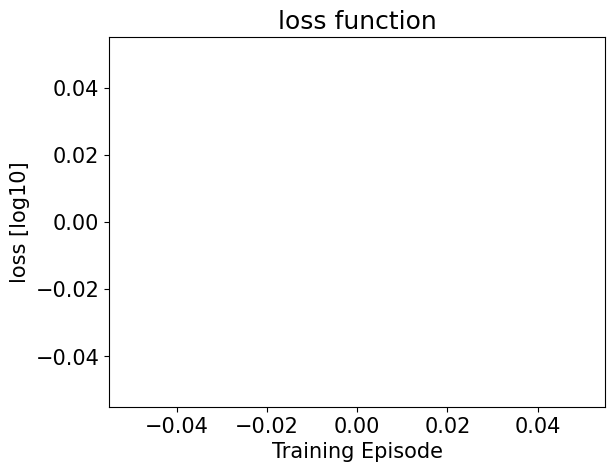

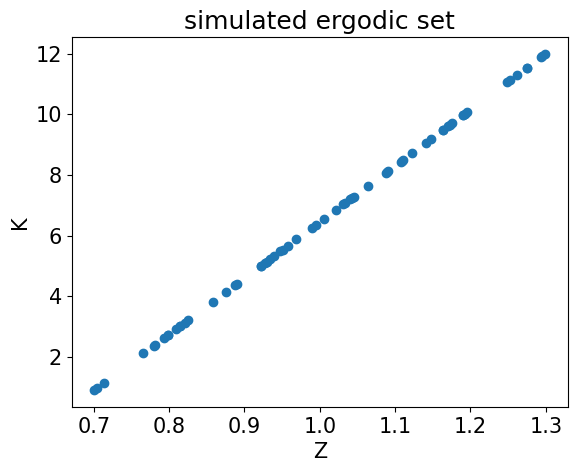

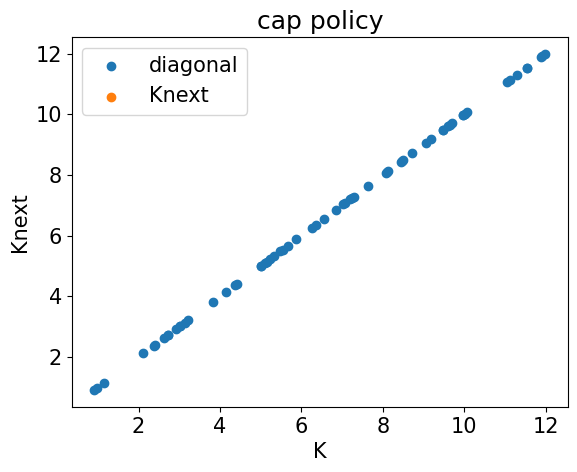

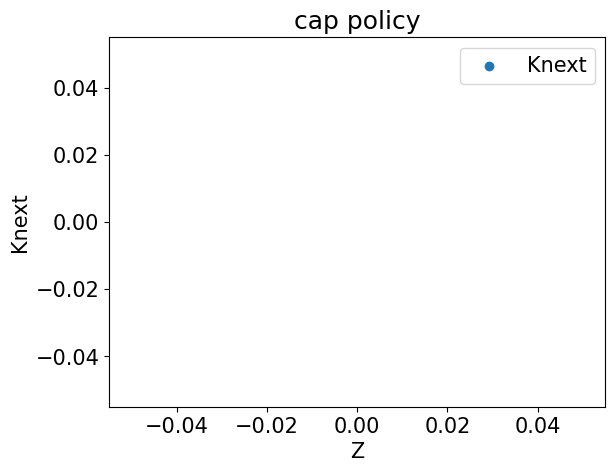

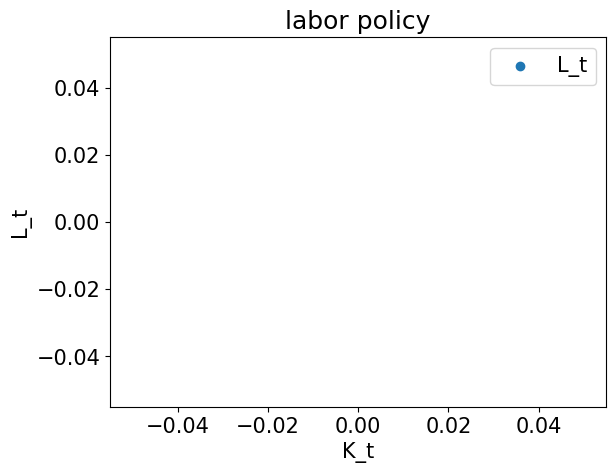

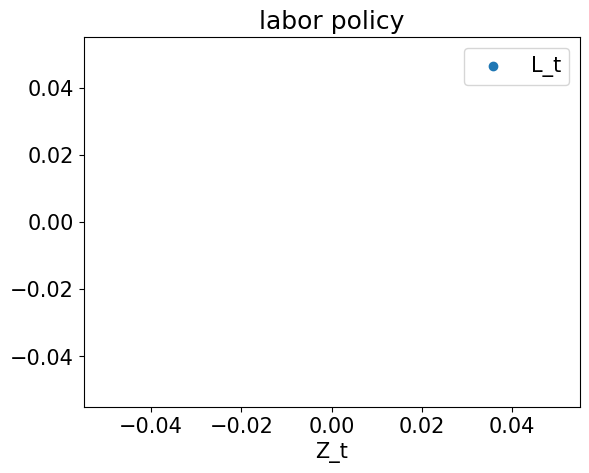

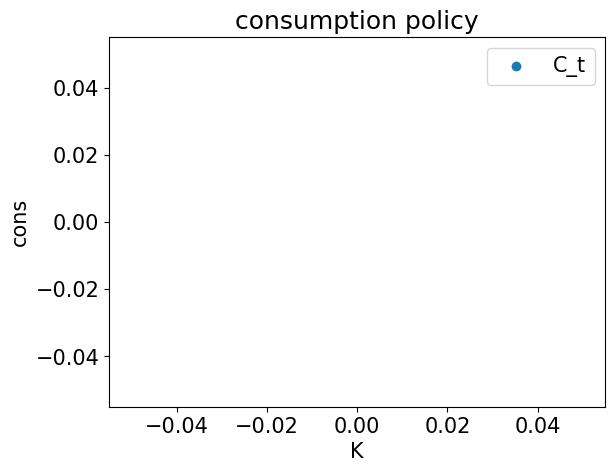

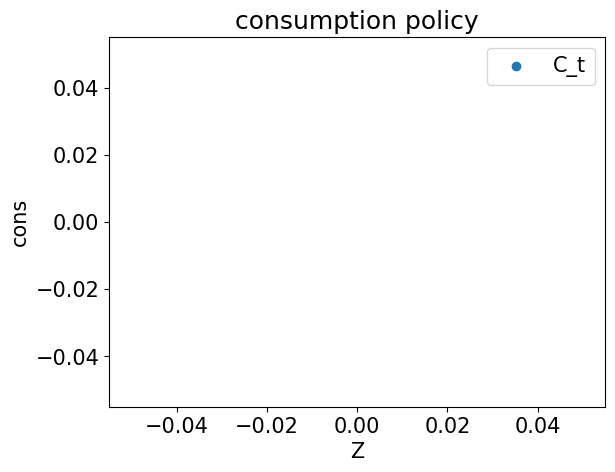

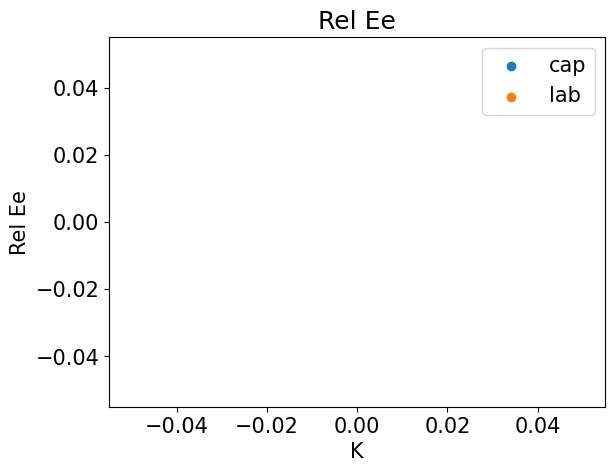

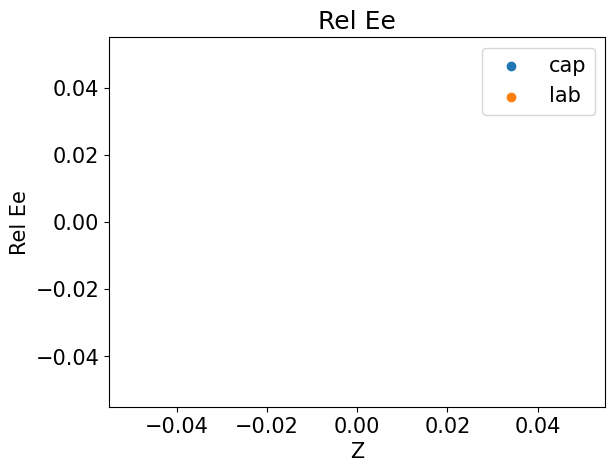

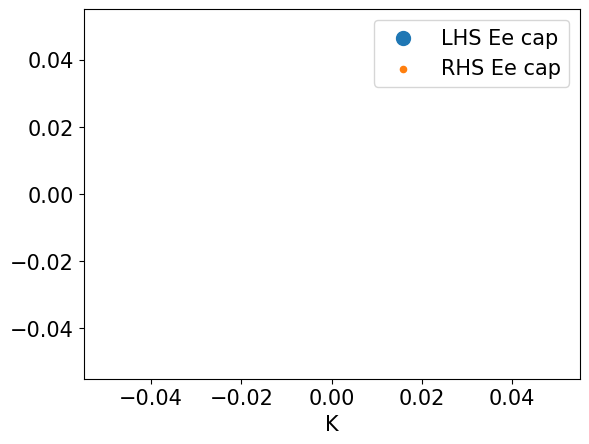

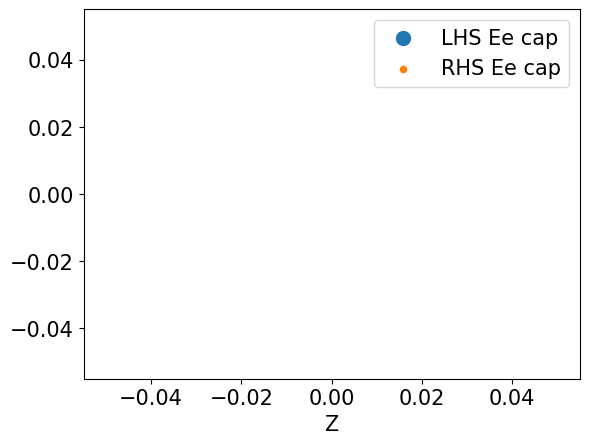

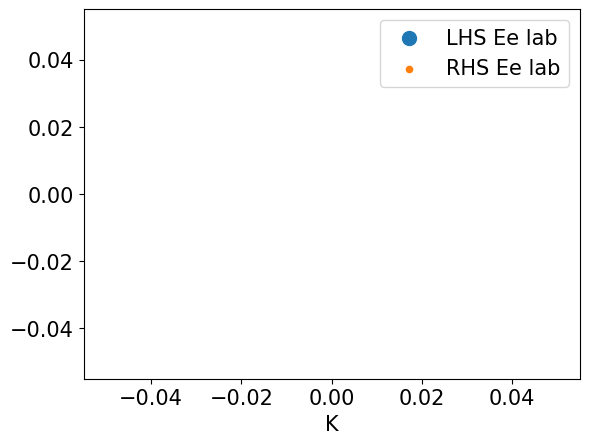

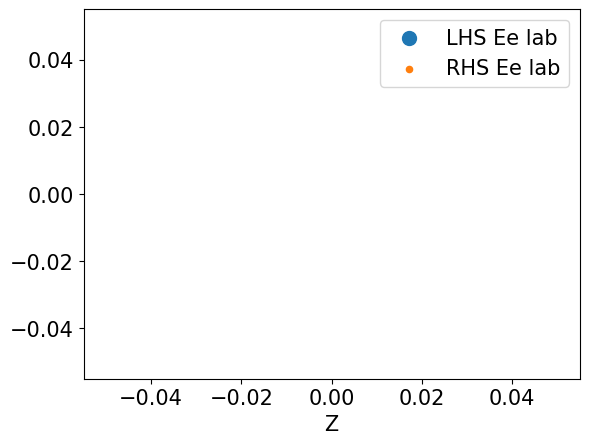

#=================================================================
episode = 1500, loss [log10] = nan
#=================================================================
episode = 3000, loss [log10] = nan
#=================================================================
episode = 4500, loss [log10] = nan
#=================================================================
episode = 6000, loss [log10] = nan


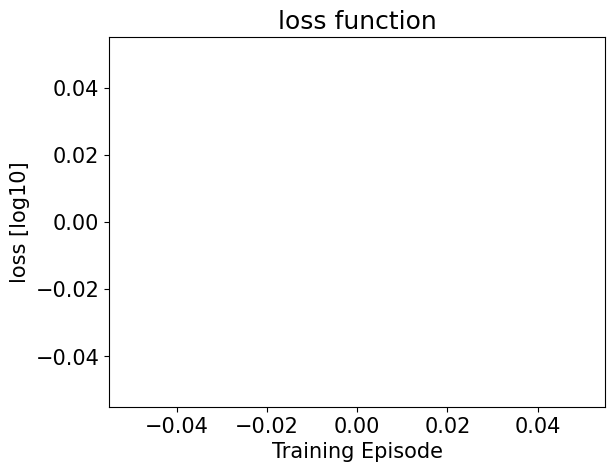

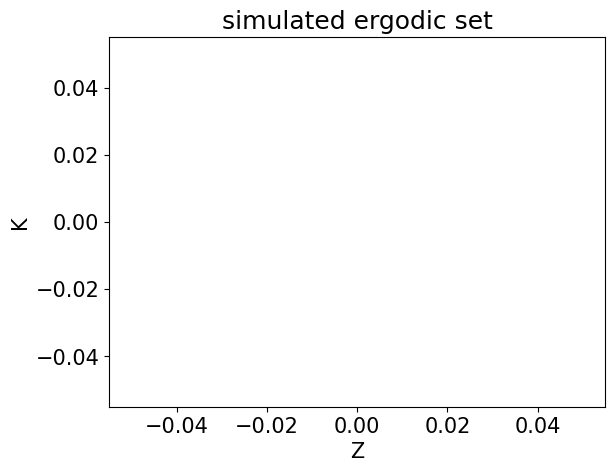

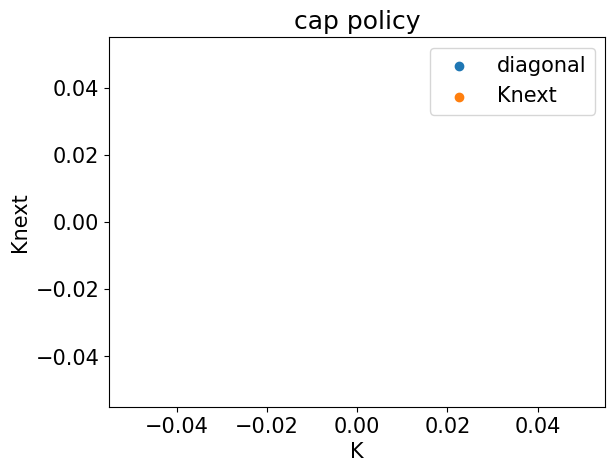

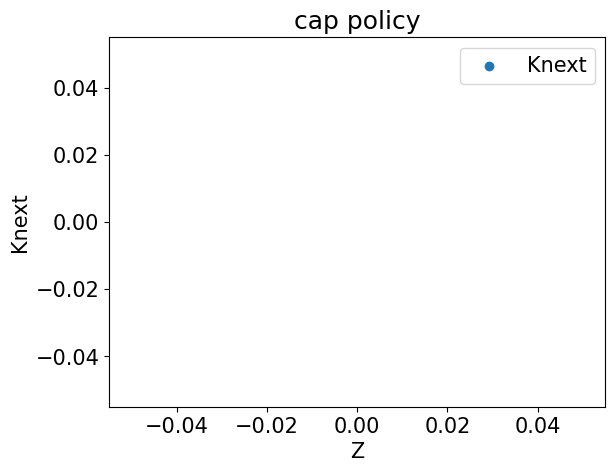

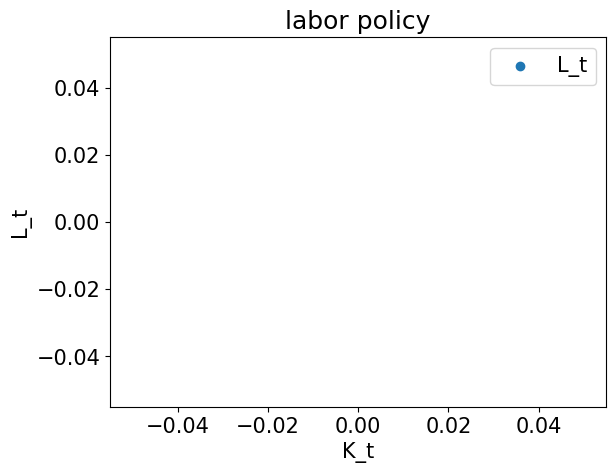

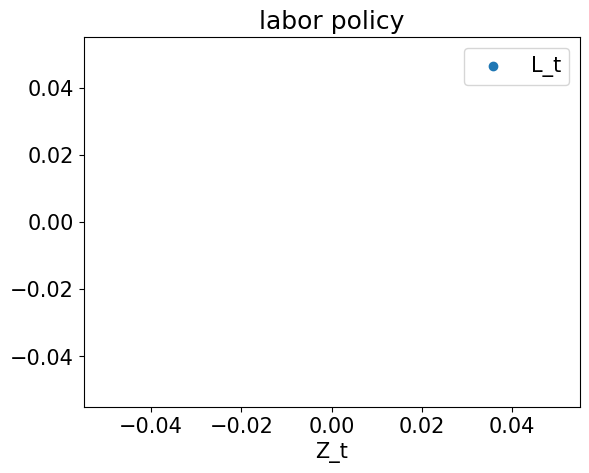

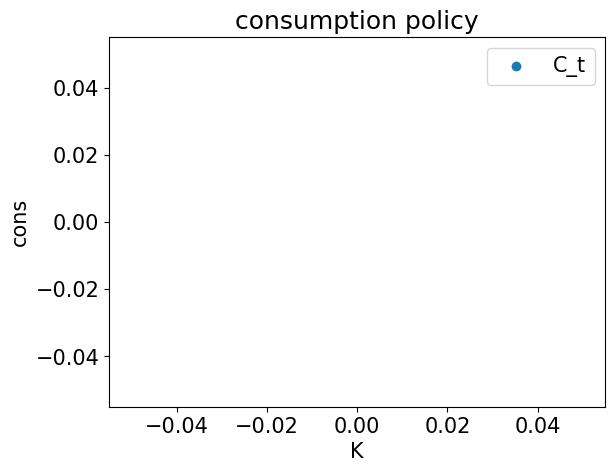

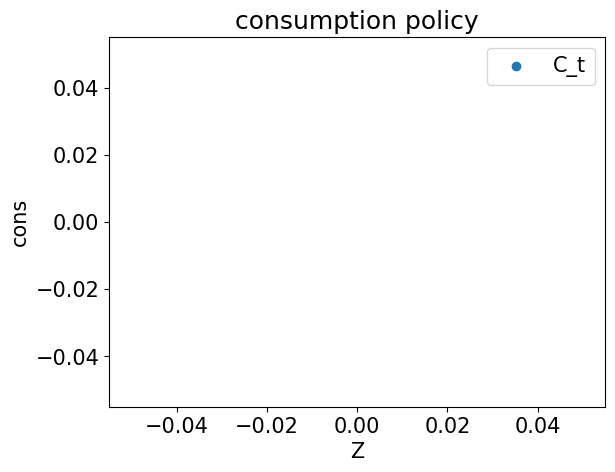

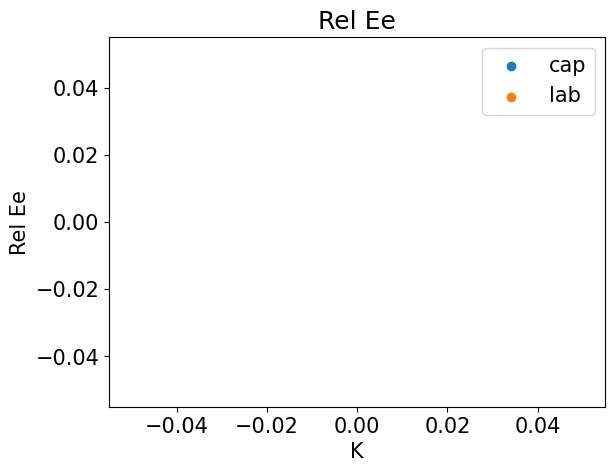

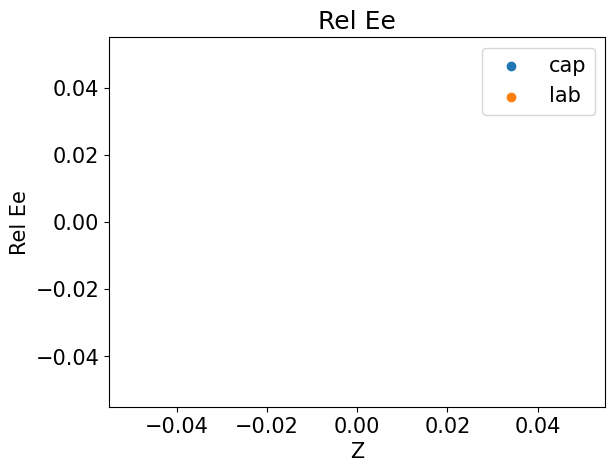

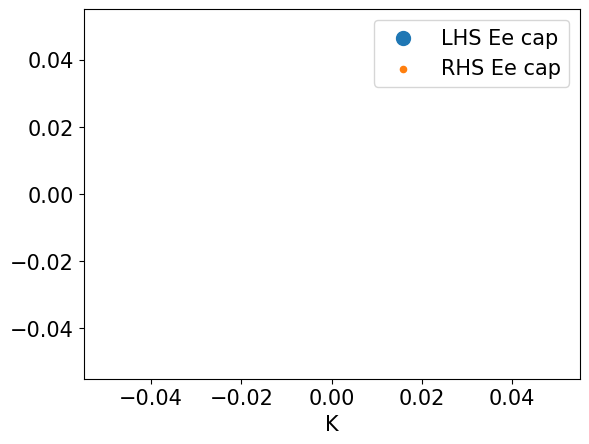

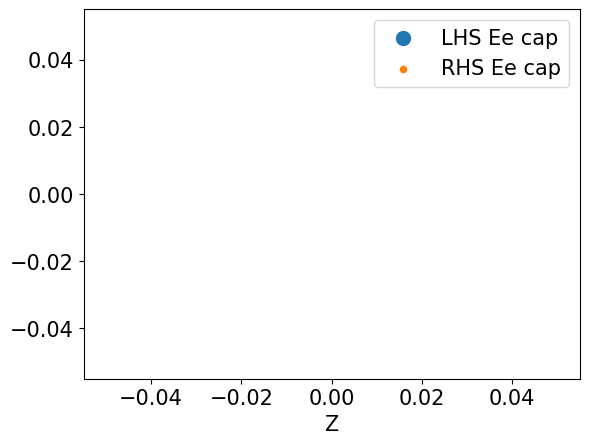

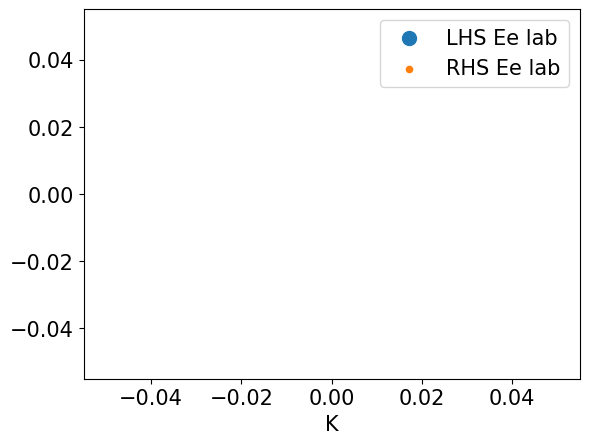

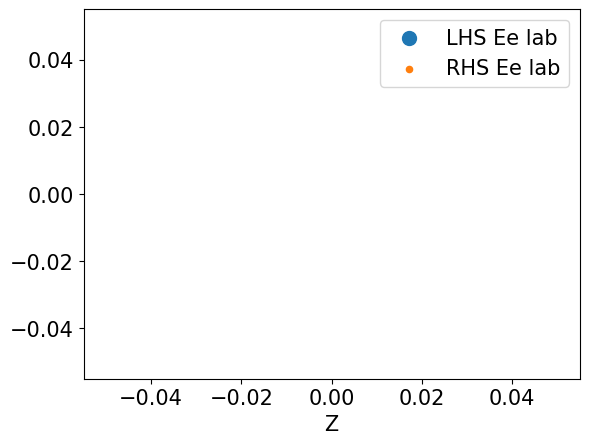

#=================================================================
episode = 7500, loss [log10] = nan
#=================================================================
episode = 9000, loss [log10] = nan
#=================================================================
episode = 10500, loss [log10] = nan
#=================================================================
episode = 12000, loss [log10] = nan


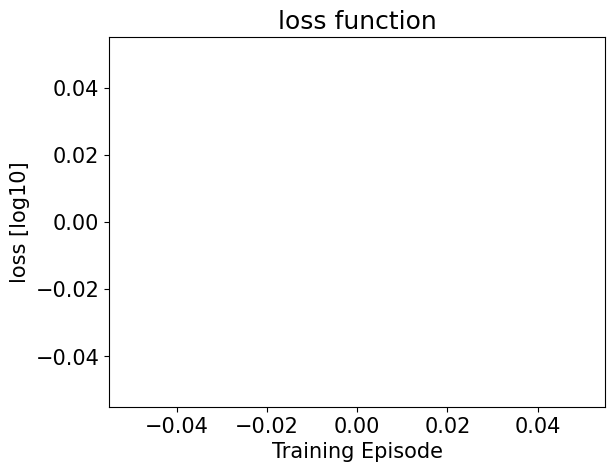

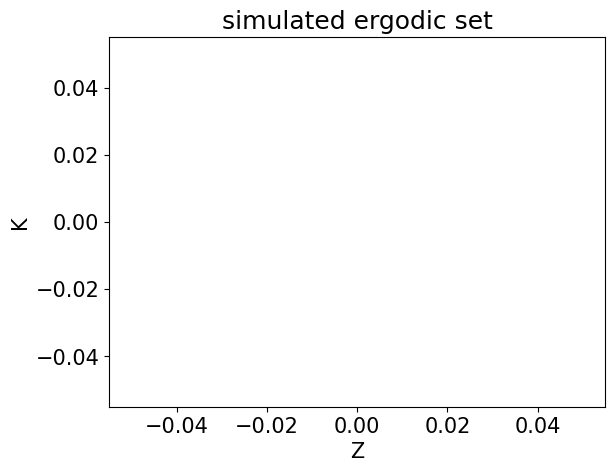

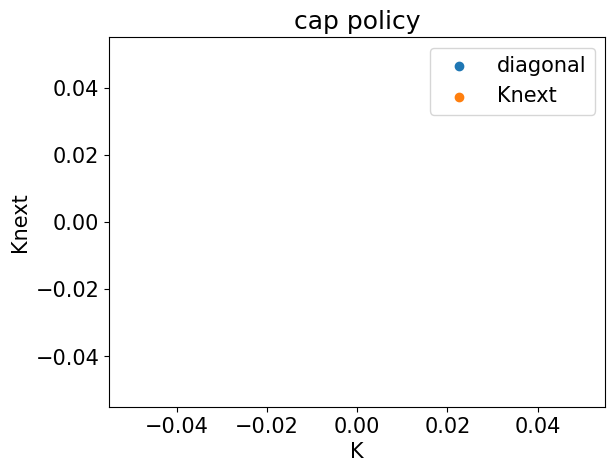

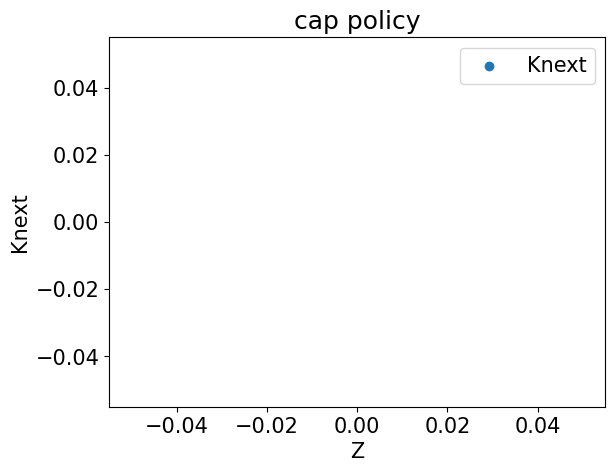

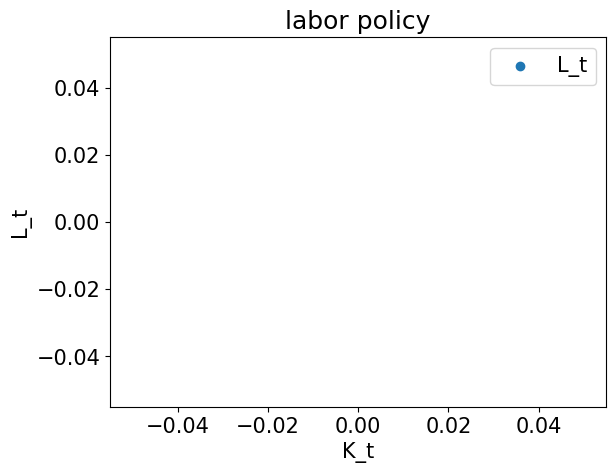

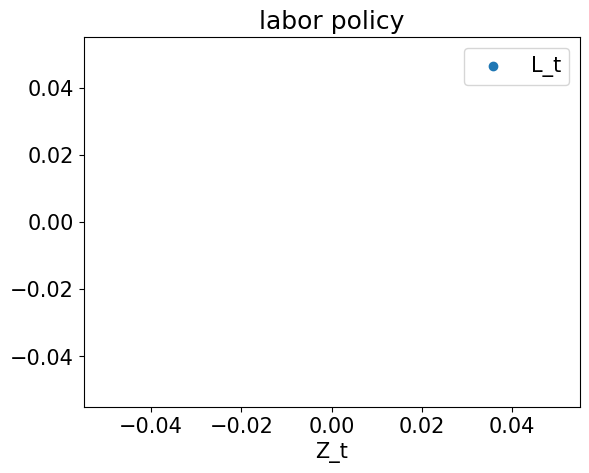

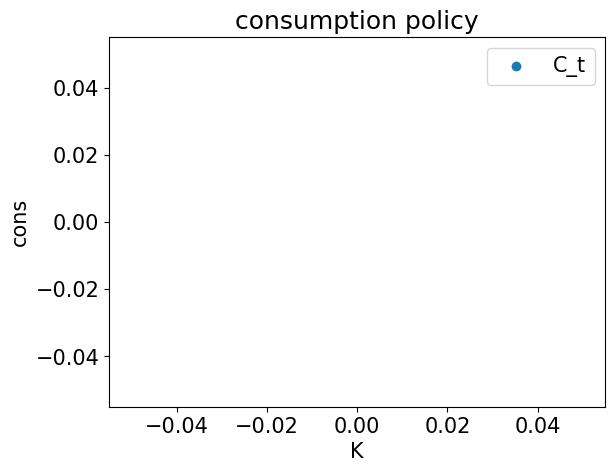

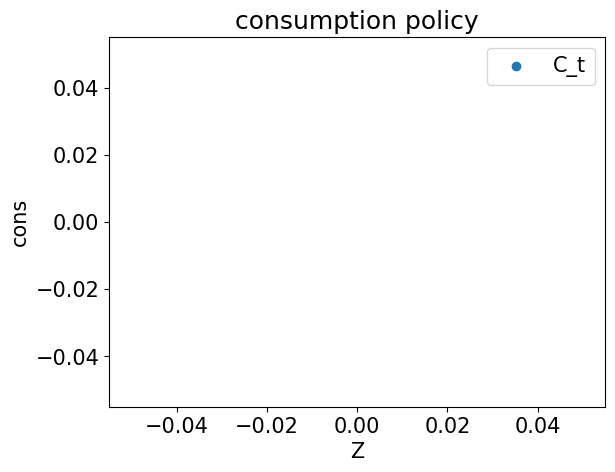

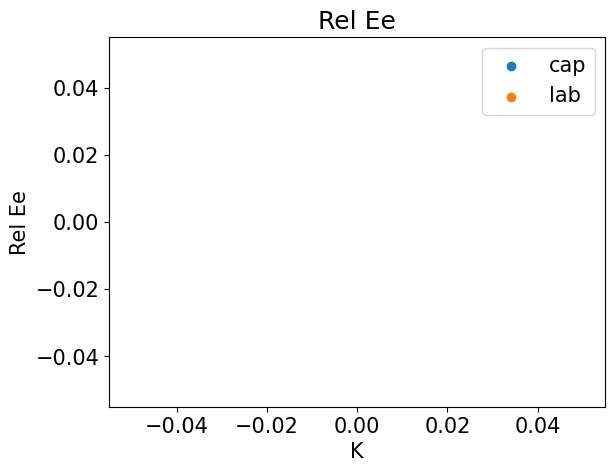

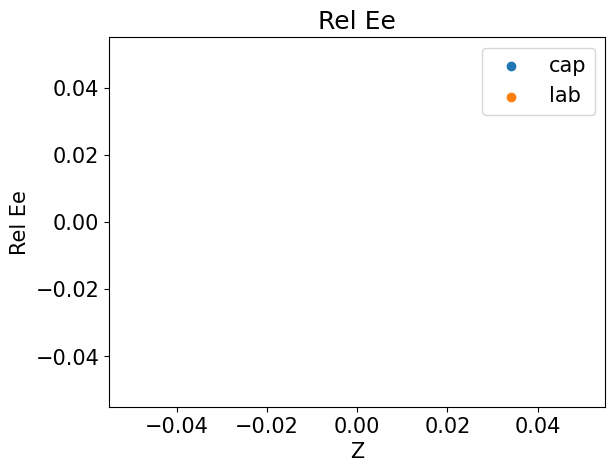

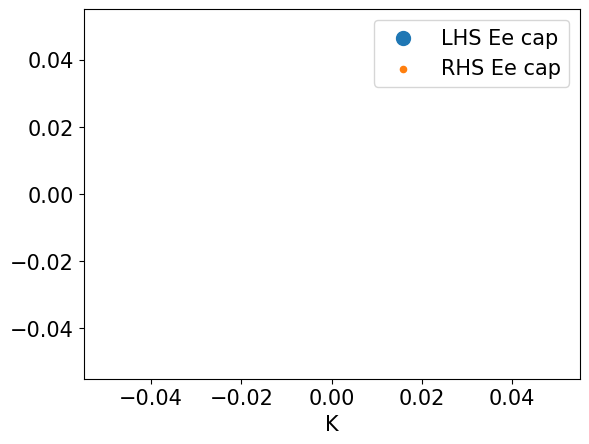

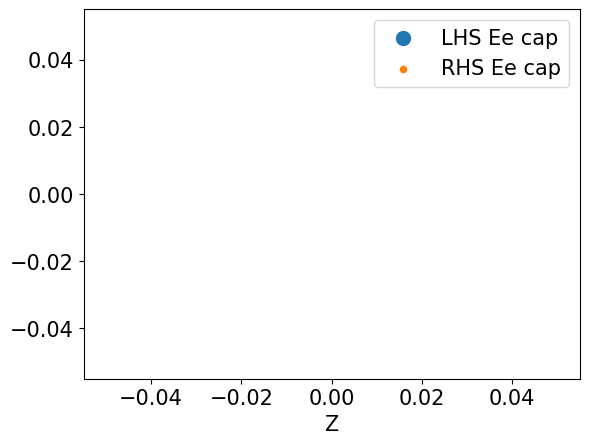

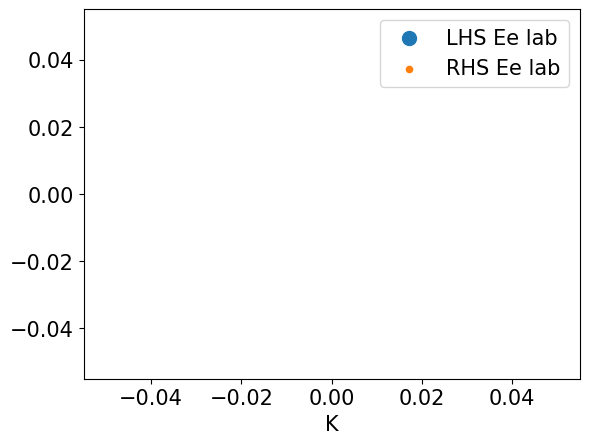

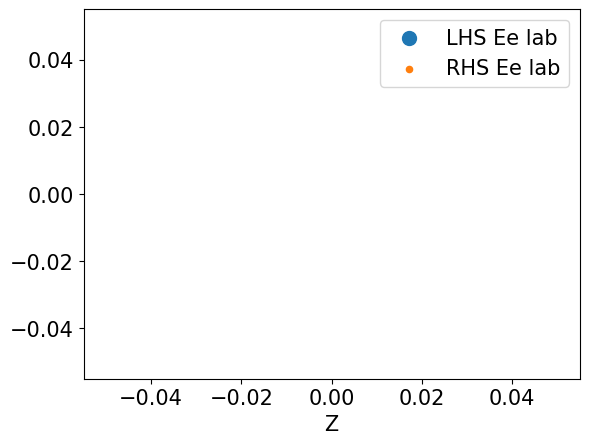

#=================================================================
episode = 13500, loss [log10] = nan
#=================================================================
episode = 15000, loss [log10] = nan
#=================================================================
episode = 16500, loss [log10] = nan
#=================================================================
episode = 18000, loss [log10] = nan


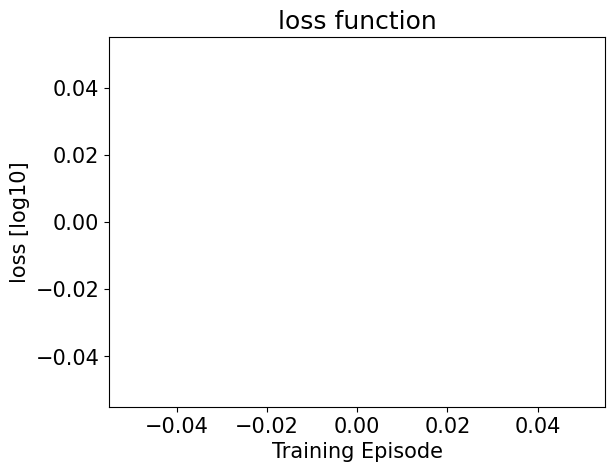

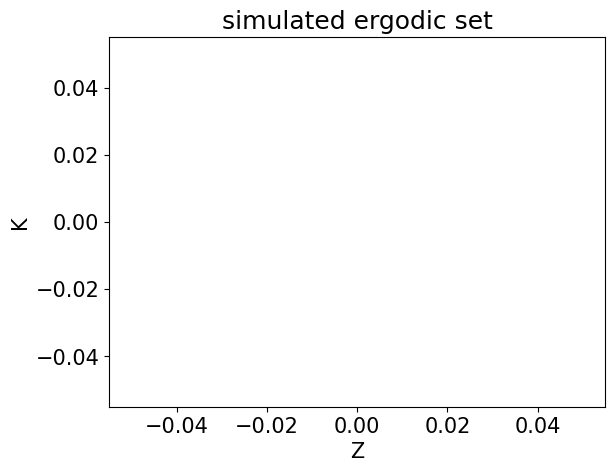

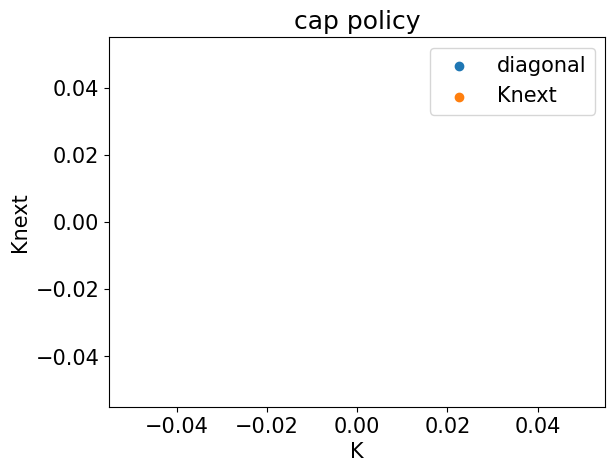

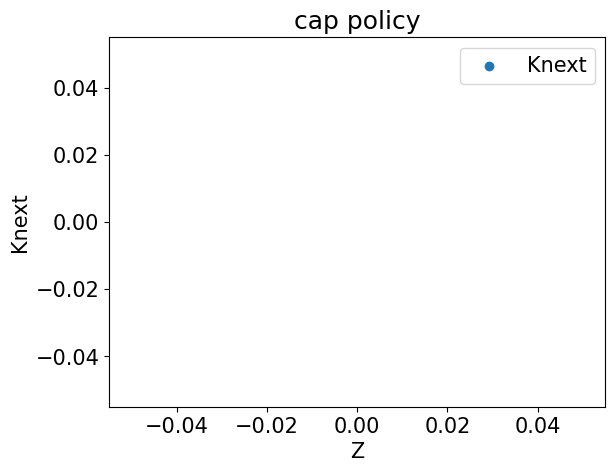

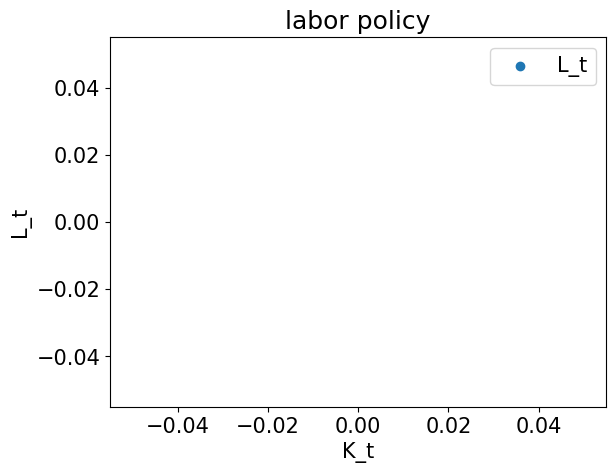

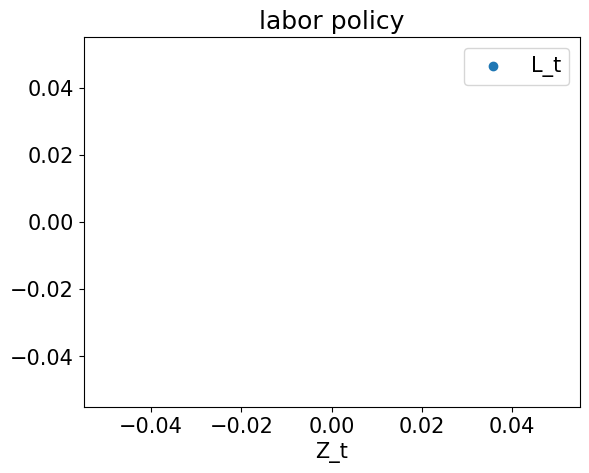

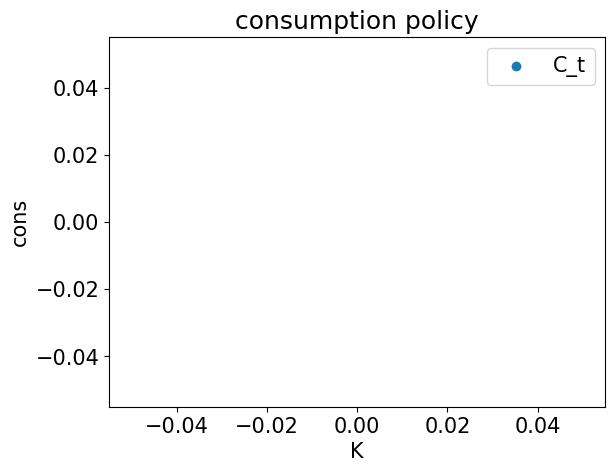

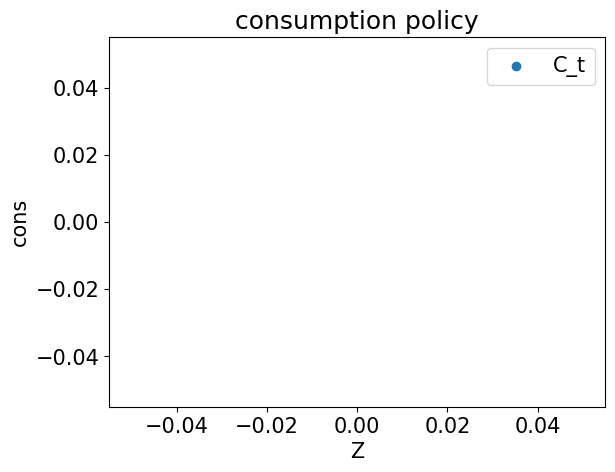

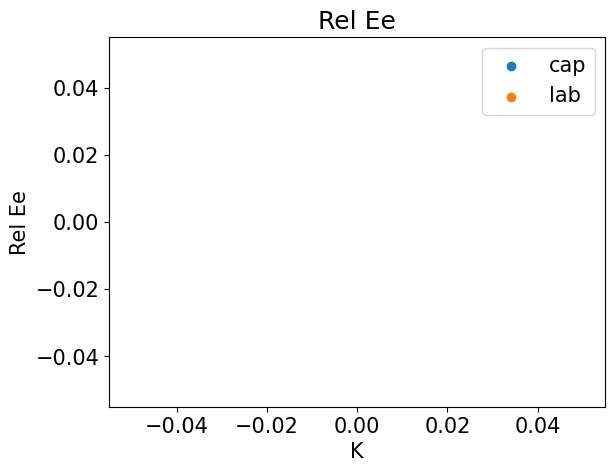

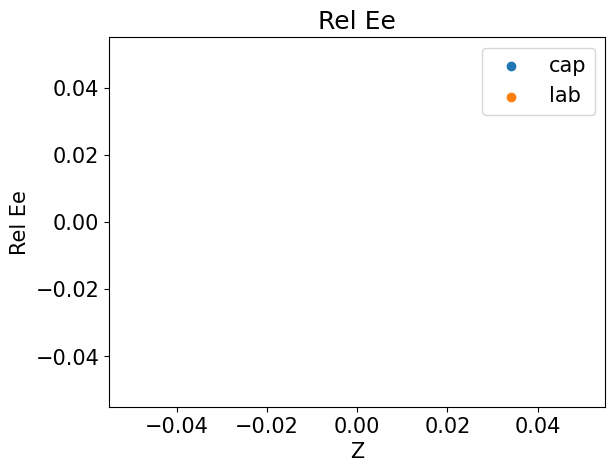

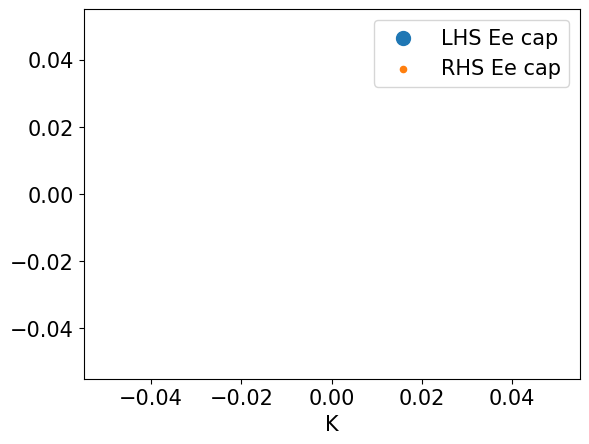

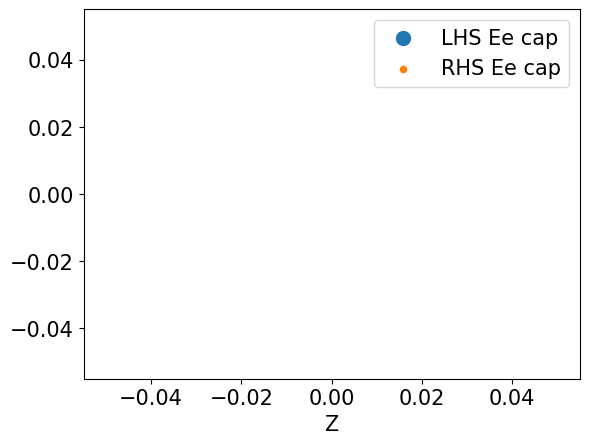

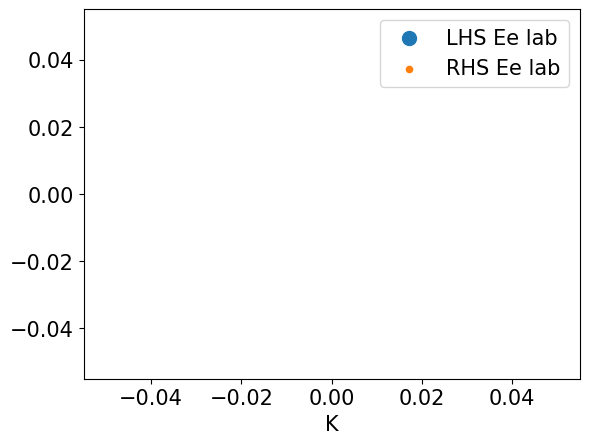

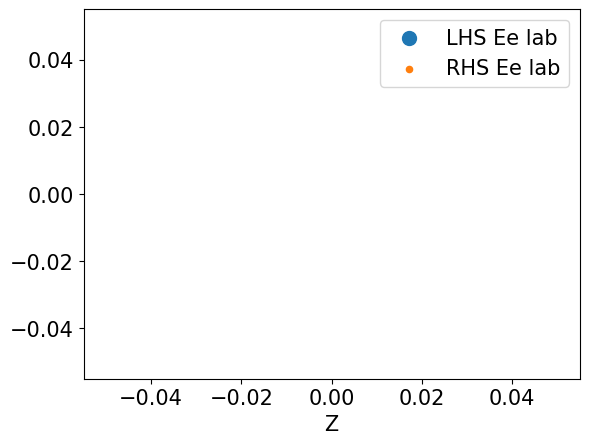

#=================================================================
episode = 19500, loss [log10] = nan
#=================================================================
episode = 21000, loss [log10] = nan
#=================================================================
episode = 22500, loss [log10] = nan
#=================================================================
episode = 24000, loss [log10] = nan


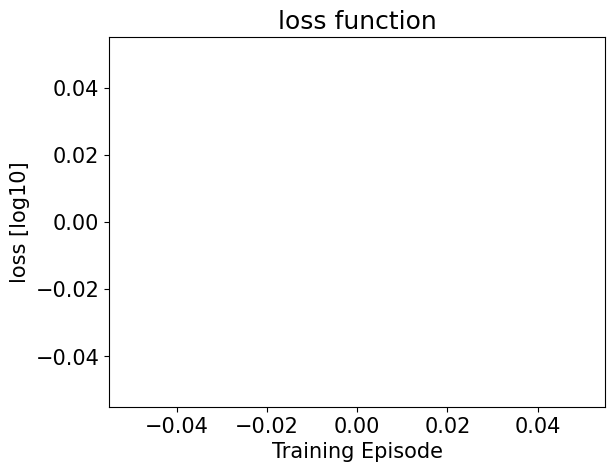

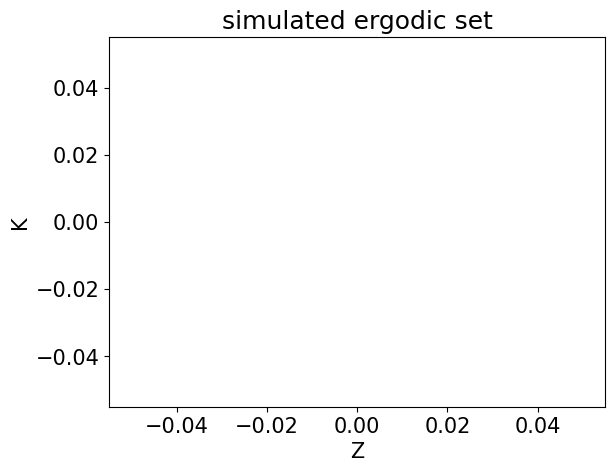

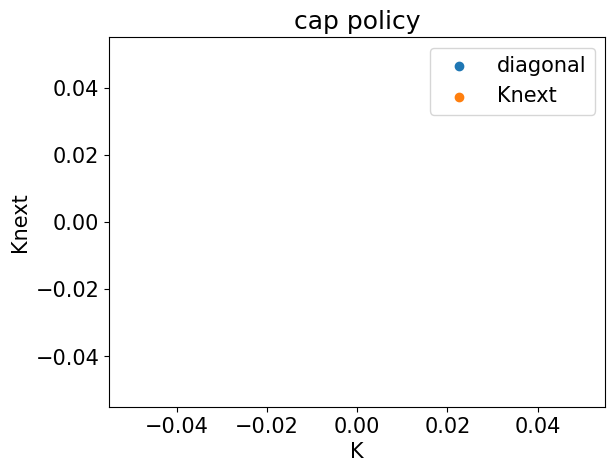

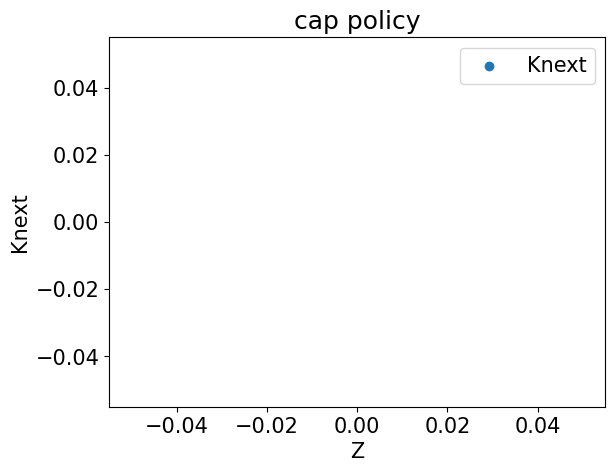

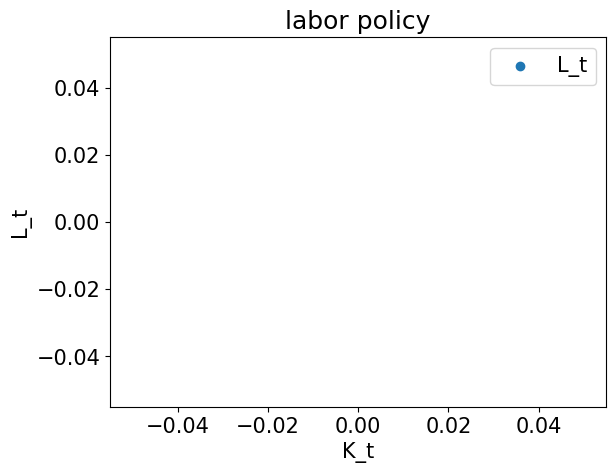

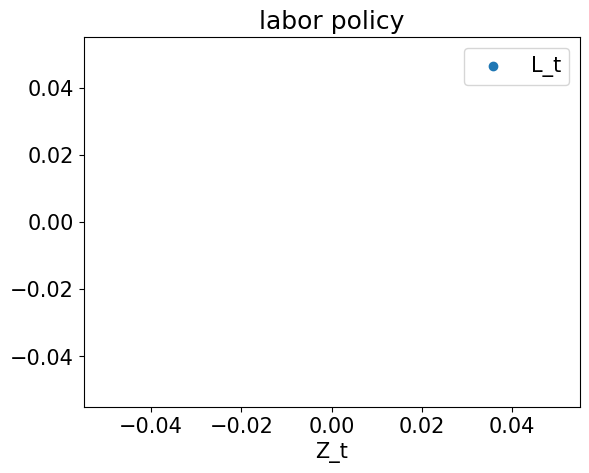

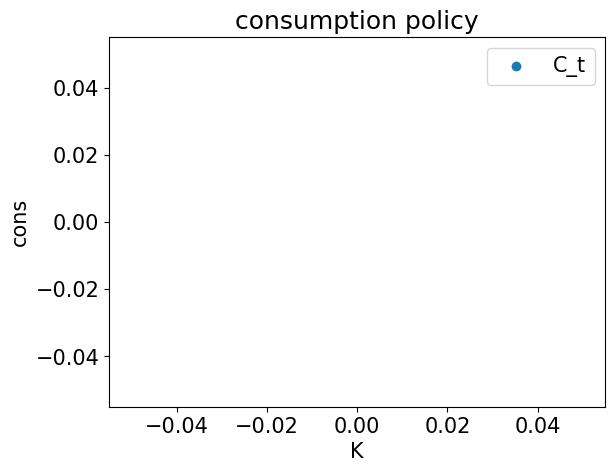

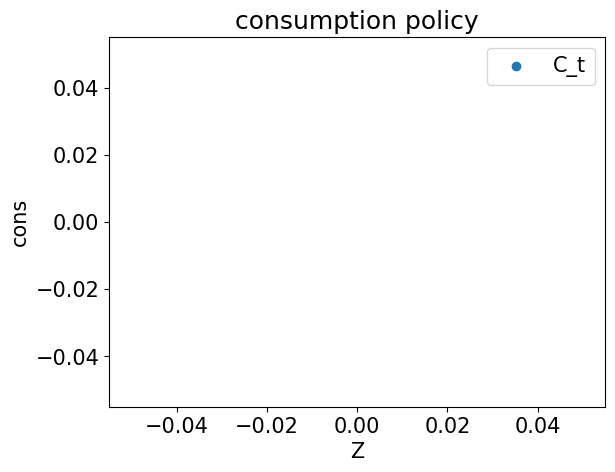

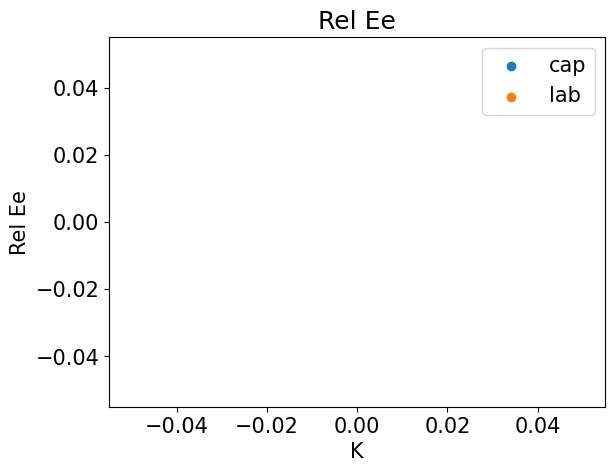

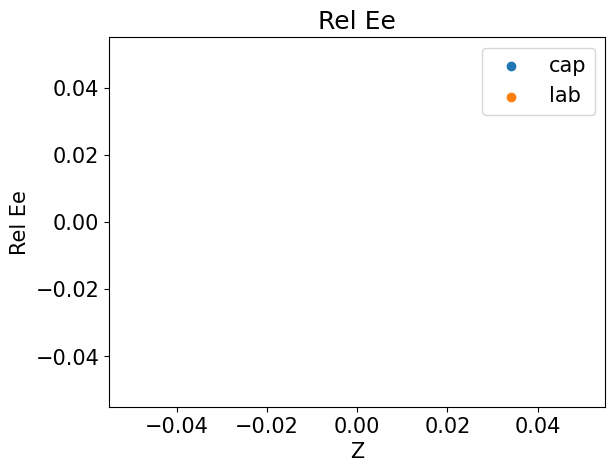

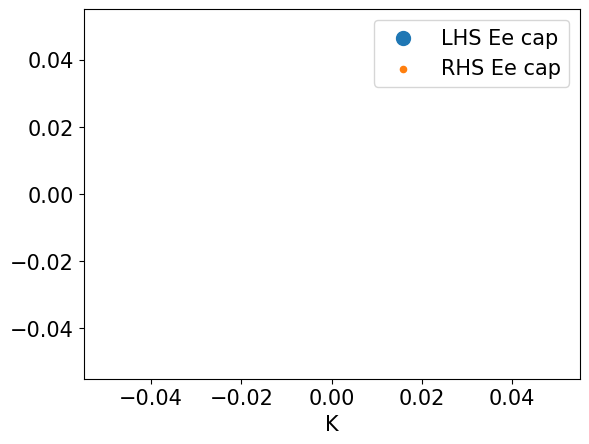

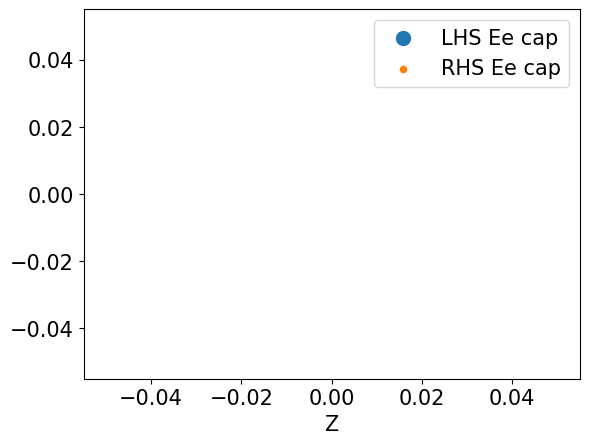

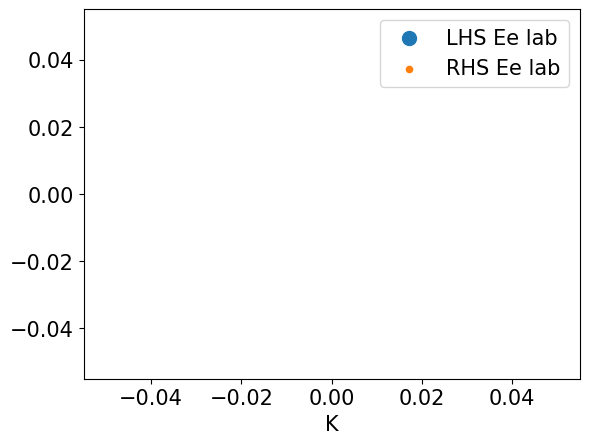

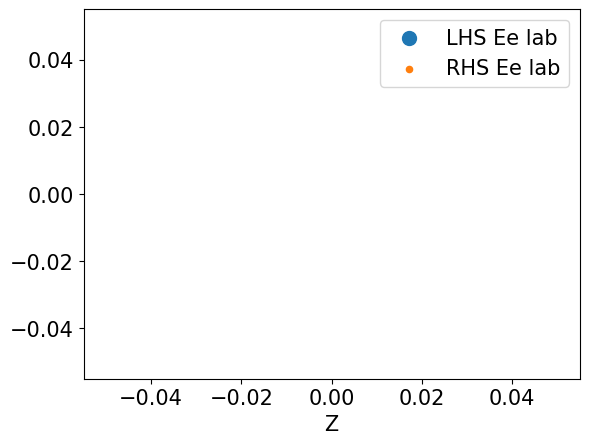

#=================================================================
episode = 25500, loss [log10] = nan
#=================================================================
episode = 27000, loss [log10] = nan
#=================================================================
episode = 28500, loss [log10] = nan
#=================================================================
episode = 30000, loss [log10] = nan


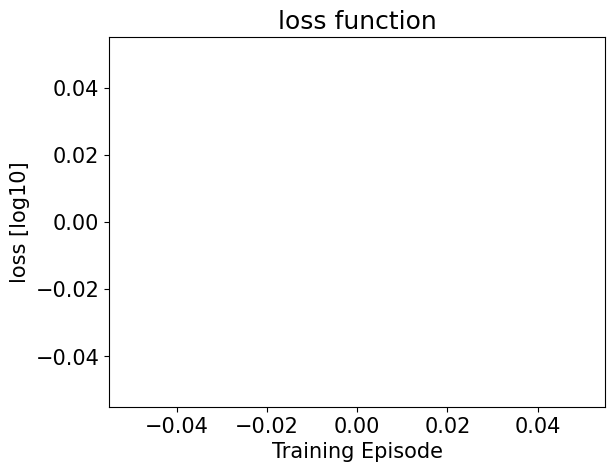

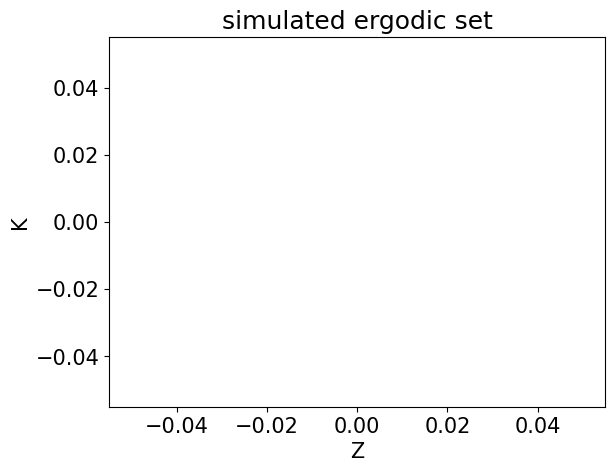

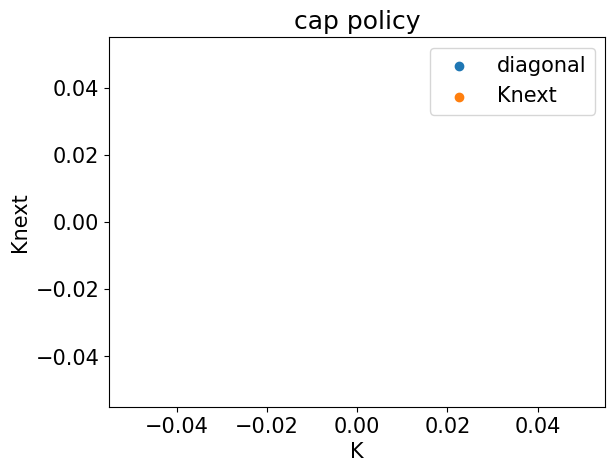

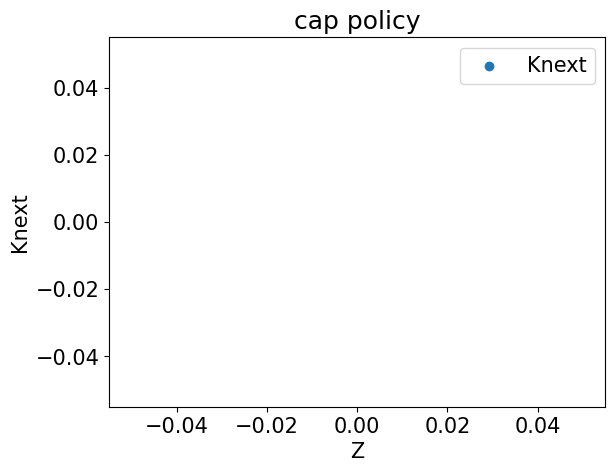

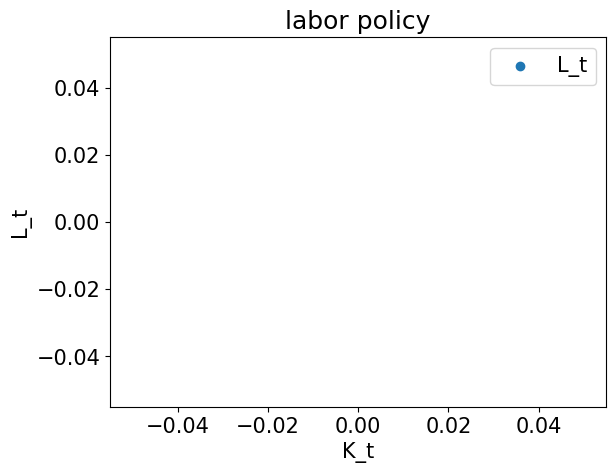

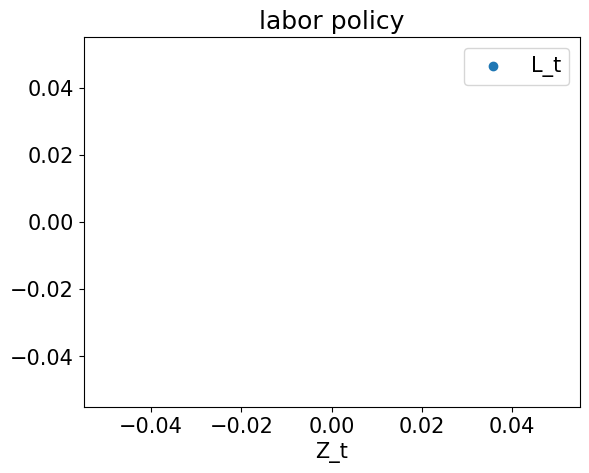

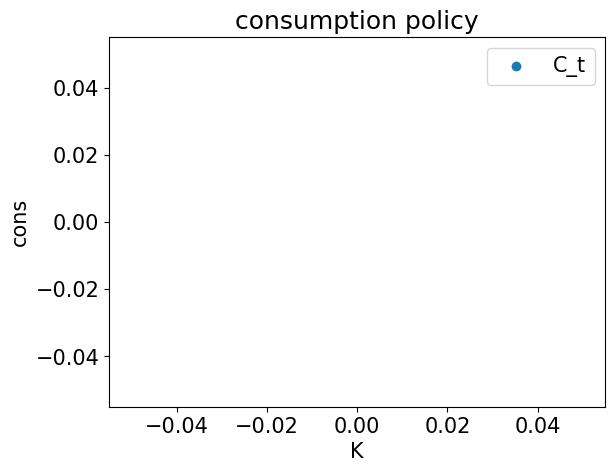

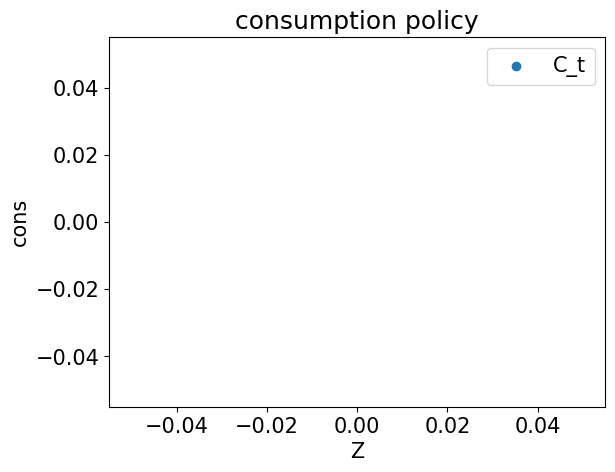

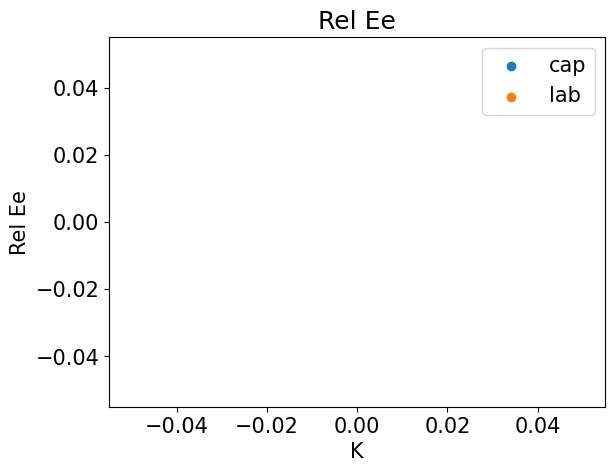

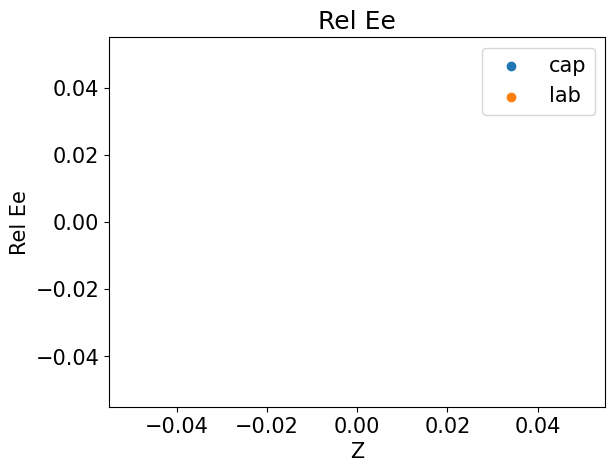

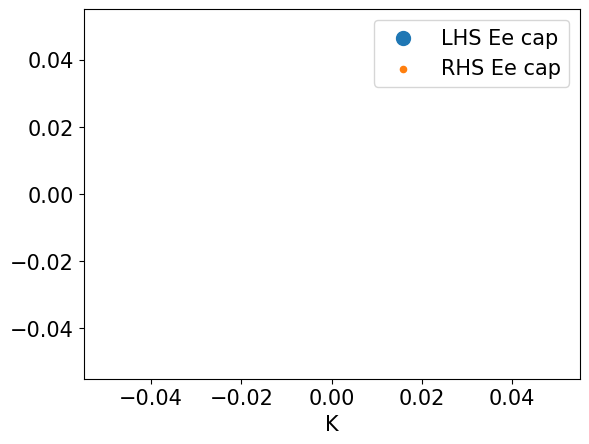

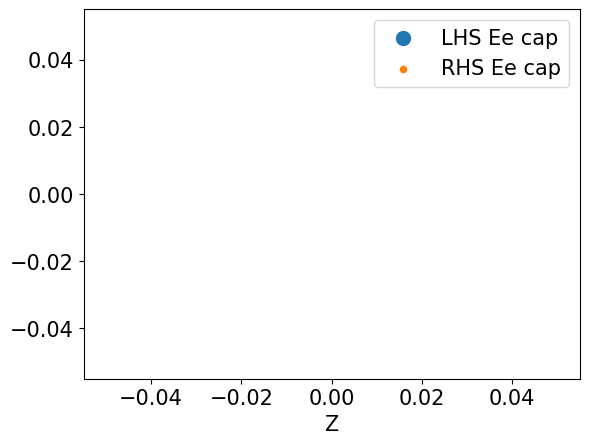

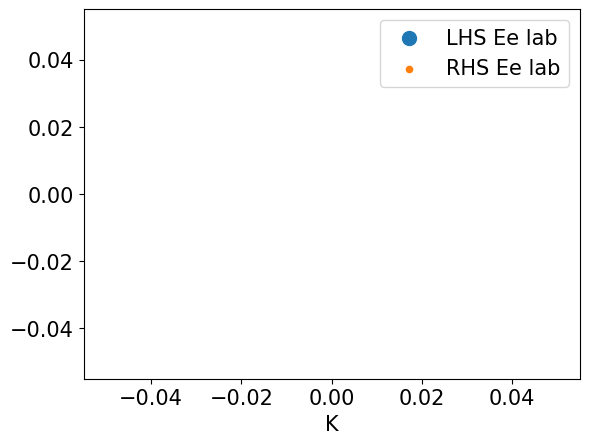

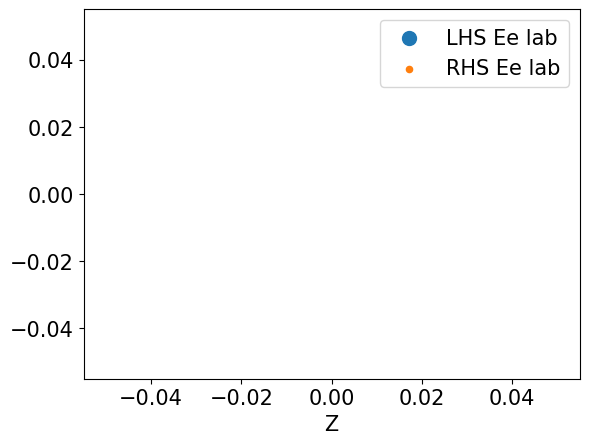

In [44]:
# Keep results for plotting
train_loss = []

num_episodes = 30001


print("n_tracks = ", X_start.shape[0])
print("n_periods = ", n_periods)

for ep in range(num_episodes):
    # generate training data, now by sampling
    X, X_end = get_training_data_simulation(X_start, nn, n_periods)

    # update X_start
    X_start = X_end
    
    # compute loss and gradients
    loss, grads = grad(X, nn)

    
    # apply gradients
    optimizer.apply_gradients(zip(grads, nn.trainable_variables))
    
    # record loss
    train_loss.append(loss.numpy())
    
    # print progress
    if ep % int(0.05 * num_episodes) == 0:
        print("#=================================================================")
        print("episode = {}, loss [log10] = {}".format(ep, np.log10(loss.numpy())))
        
    if ep % int(0.2 * num_episodes) == 0 or ep == num_episodes - 1:
        cost, errREE_cap, errREE_lab, C_t, K_tplus1, L_t, r_t, w_t, LHS_cap, RHS_cap, LHS_lab, RHS_lab = compute_cost(X, nn)
        
        plt.title("loss function")
        plt.plot(np.log10(np.array(train_loss)))
        plt.xlabel("Training Episode")
        plt.ylabel("loss [log10]")
        plt.show()
        plt.close()
        
        plt.title("simulated ergodic set")
        plt.scatter(X[:, 0], X[:, 1])
        plt.xlabel("Z")
        plt.ylabel("K")
        plt.show()
        plt.close()
        
        
        plt.title("cap policy")
        plt.xlabel("K")
        plt.ylabel("Knext")
        plt.scatter(X[:, 1], X[:, 1], label = "diagonal")
        plt.scatter(X[:, 1], K_tplus1[:, 0], label = "Knext")
        plt.legend()
        plt.show()
        plt.close()

        plt.title("cap policy")
        plt.xlabel("Z")
        plt.ylabel("Knext")
        plt.scatter(X[:, 0], K_tplus1[:, 0], label = "Knext")
        plt.legend()
        plt.show()
        plt.close()
        
           
        plt.title("labor policy")
        plt.xlabel("K_t")
        plt.ylabel("L_t")
        plt.scatter(X[:, 1], L_t[:, 0], label = "L_t")
        plt.legend()
        plt.show()
        plt.close()

        plt.title("labor policy")
        plt.xlabel("Z_t")
        plt.scatter(X[:, 0], L_t[:, 0], label = "L_t")
        plt.legend()
        plt.show()
        plt.close()

        plt.title("consumption policy")
        plt.xlabel("K")
        plt.ylabel("cons")
        plt.scatter(X[:, 1], C_t[:, 0], label="C_t")
        plt.legend()
        plt.show()
        plt.close()

        plt.title("consumption policy")
        plt.xlabel("Z")
        plt.ylabel("cons")
        plt.scatter(X[:, 0], C_t[:, 0], label="C_t")
        plt.legend()
        plt.show()
        plt.close()

        plt.title("Rel Ee")
        plt.xlabel("K")
        plt.ylabel("Rel Ee")
        plt.scatter(X[:, 1], errREE_cap[:, 0], label="cap")
        plt.scatter(X[:, 1], errREE_lab[:, 0], label="lab")
        plt.legend()
        plt.show()
        plt.close()
       
        plt.title("Rel Ee")
        plt.xlabel("Z")
        plt.ylabel("Rel Ee")
        plt.scatter(X[:, 0], errREE_cap[:, 0], label="cap")
        plt.scatter(X[:, 0], errREE_lab[:, 0], label="lab")
        plt.legend()
        plt.show()
        plt.close()
        
        plt.xlabel("K")
        plt.scatter(X[:, 1], LHS_cap[:, 0], s = 100, label="LHS Ee cap")
        plt.scatter(X[:, 1], RHS_cap[:, 0], s = 20, label="RHS Ee cap")
        plt.legend()
        plt.show()
        plt.close()
        
        plt.xlabel("Z")
        plt.scatter(X[:, 0], LHS_cap[:, 0], s = 100, label="LHS Ee cap")
        plt.scatter(X[:, 0], RHS_cap[:, 0], s = 20, label="RHS Ee cap")
        plt.legend()
        plt.show()
        plt.close()
        
        plt.xlabel("K")
        plt.scatter(X[:, 1], LHS_lab[:, 0], s = 100, label="LHS Ee lab")
        plt.scatter(X[:, 1], RHS_lab[:, 0], s = 20, label="RHS Ee lab")
        plt.legend()
        plt.show()
        plt.close()
        
        plt.xlabel("Z")
        plt.scatter(X[:, 0], LHS_lab[:, 0], s = 100, label="LHS Ee lab")
        plt.scatter(X[:, 0], RHS_lab[:, 0], s = 20, label="RHS Ee lab")
        plt.legend()
        plt.show()
        plt.close()

### Exercise 3
In the above model labor supply fluctuated between 0.9 and 1.07.  
Now we want to assume that there is a time constraint such that we can work at most $L_t = 1.01$ units of time.  
Now the previously derived optimality condition
\begin{align}
0 &= \frac{w_t}{C_t \psi L_t^{\theta}} - 1
\end{align}
only holds with equality if the omptimal choice is interior, i.e., $L_t<1.01$.  
Instead, the optimality conditions are now given by a set of Karush-Kuhn-Tucker conditions (KKT):
\begin{align}
0 &= \frac{w_t}{C_t \psi L_t^{\theta}} - 1 + \lambda_t\\
0 &\leq \lambda_t\\
0 &\leq 1.01 - L_t\\
0 &= \lambda_t (1.01 - L_t).
\end{align}

If the constraint is binding, $L_t = 1.01$ and $\lambda_t>0$, we may have
\begin{align}
0 &\leq \frac{w_t}{C_t \psi L_t^{\theta}} - 1.
\end{align}
Hence, we now want to encode the following equilibrium condition
\begin{align}
\frac{w_t}{C_t \psi L_t^{\theta}} - 1 
\begin{cases}
=0 &\text{for } L_t < 1.01\\
\geq 0 &\text{for } L_t = 1.01
\end{cases}
\end{align}
together with the constraint that $L_t \leq 1.01$.  

I turns out, we can encode this conditions with a single equation that has to hold with equality!  
To do so, we can make use of the Fisher-Burmeister function, which is given by
\begin{align}
f^{FB}(a, b) = \sqrt{a^2 + b^2} - a - b.
\end{align}
The Fischer-Burmeister equation has the convenient property, that it is equal to zero exactly when either $a=0, b \geq 0$ or $a \geq 0, b = 0$. 
Defining
\begin{align}
a &= \frac{w_t}{C_t \psi L_t^{\theta}} - 1\\
b &= 1.01 - L_t
\end{align},
the Fisher-Burmeister equation hence encodes exactly the condition we want!   
For this modified problem, what would be a suitable economics-inspired output activation for the labor supply?

In [89]:
num_hidden1 = 100 
num_hidden2 = 100
num_output = 2
labor_max = 1.01


# we use sigmod in the output layer so output is between 0 and 1
nn = keras.Sequential([
    keras.layers.Dense(num_hidden1, activation='relu', input_shape=(num_input,)),
    keras.layers.Dense(num_hidden2, activation='relu'),
    keras.layers.Dense(num_output)
])

@tf.function
def predict_policies(x, nn):
    # execute original nn
    orig_prediction = nn(x)
    """
    Exercise:
    Apply a sigmoig activation function to both columns of 'orig_prediction' and return the result as 'prediction'.
    For the second column make sure the range is from 0 to 1.01.
    """
    """
    Solution:
    """
    #=====================================================================

    a = tf.keras.activations.sigmoid(orig_prediction[:, 0 : 1])
    b = 1.1 * tf.keras.activations.sigmoid(orig_prediction[:, 1 : 2])
    prediction = tf.concat([a, b], axis = 1)
    
    #=====================================================================
    
    return prediction

# we define the Fischer-Burmeister function.
# fischer_burmeister(a, b) = 0 obtains solution where a>=0, b>=0, a * b = 0
@tf.function
def fischer_burmeister(a, b):
    return (tf.math.abs(a ** 2 + b ** 2 + 1e-13) ** 0.5 - a - b)

In [129]:
@tf.function
def compute_cost(X, nn):
    """ 
    Compute the mean squared error in the equilibrium conditions.
    """
    n_data = X.shape[0] # number of states is on the axis 0
    dim_state = X.shape[1] # dimensionality of the state is on axis 1
    
    # read out the state
    Z_t = X[:, 0 : 1]
    K_t = X[:, 1 : 2]
    
    # execute neural network
    nn_pred = predict_policies(X, nn)
    
    # get policies
    s_t = nn_pred[:, 0 : 1]
    L_t = nn_pred[:, 1 : 2] 
    
    
    # compute output today
    Y_t = Z_t * K_t ** alpha * L_t ** (1. - alpha)
    
    # compute return and wage
    r_t = alpha * (Y_t / K_t)
    w_t = (1. - alpha) * (Y_t / L_t)
    
    # get the implied capital in the next period
    K_tplus1 = (1. - delta) * K_t + Y_t * s_t

    # get consumption
    C_t = Y_t - Y_t * s_t
    
    # now we have to compute the expectation
    expectation = tf.zeros((n_data, dim_state))
    
    # we loop over the integration nodes
    for i in range(n_int):
        # integration weight
        weight_i = w_int[i]
        
        # innovation to the AR(1)
        innovation_i = x_int[i]
        
        # construct exogenous shock at t+1
        Z_tplus1 = tf.exp(rho_tfp * tf.math.log(Z_t) + innovation_i)
        
        # construct state at t+1
        X_tplus1 = tf.concat([Z_tplus1, K_tplus1], axis = 1)
        
        # compute term inside the expeectation
        inside_i = get_singleinside(X_tplus1, nn)
        
        # add term to the expectaion with the appropriate weight
        expectation = expectation + weight_i * inside_i

    # now we have all terms to construct the relative Euler error
    
    # Define the relative Euler error
    errREE_cap = 1. - 1. / (C_t * beta * expectation)
    """
    Exercise:
    Define 'fb_lab_a' and 'fb_lab_b', such that 'fischer_burmeister(fb_lab_a, fb_lab_b) = 0' yields the constrained-optimal labor supply choice.
    Remember that:
    fischer_burmeister(a, b) = 0 obtains solution where a>=0, b>=0, a * b = 0
    """
    """
    Solution:
    """
    #=====================================================================

    
    #=====================================================================
    
    errREE_lab = fischer_burmeister(fb_lab_a, fb_lab_b)
    
    # compute the cost, i.e. the mean square error in the equilibrium conditions
    cost = 0.7 * tf.reduce_mean(errREE_cap ** 2) + 0.3 * tf.reduce_mean(errREE_lab ** 2)
    
    # we return some more things for plotting
    LHS_cap = 1. / C_t # LHS of Ee
    RHS_cap = beta * expectation # RHS of Ee
    
    LHS_lab = w_t / C_t
    RHS_lab = psi * L_t ** theta

    return cost, errREE_cap, errREE_lab, C_t, K_tplus1, L_t, r_t, w_t, LHS_cap, RHS_cap, LHS_lab, RHS_lab

In [130]:
def grad(X, nn):
    with tf.GradientTape() as tape:
        loss_value = compute_cost(X, nn)[0]
    return loss_value, tape.gradient(loss_value, nn.trainable_variables)

In [131]:
learning_rate = 0.0003
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [132]:
# initialize X_start
n_tracks = 64
n_periods = 3

X_start = get_training_data(z_lb, z_ub, k_lb, k_ub, n_tracks)
print("n_tracks = ", X_start.shape[0])
print("n_periods = ", n_periods)

n_tracks =  64
n_periods =  3


#=================================================================
episode = 0, loss [log10] = -5.6124587059021


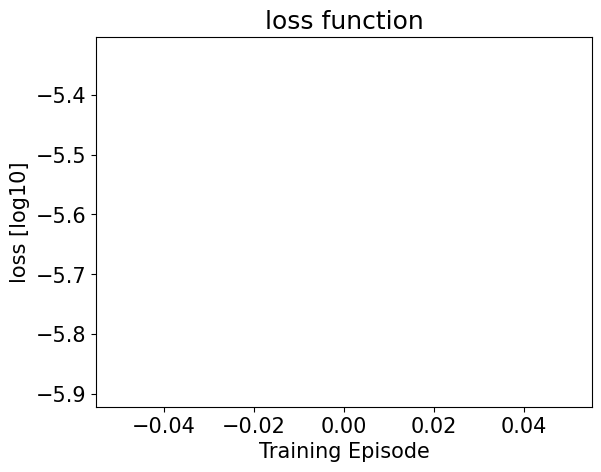

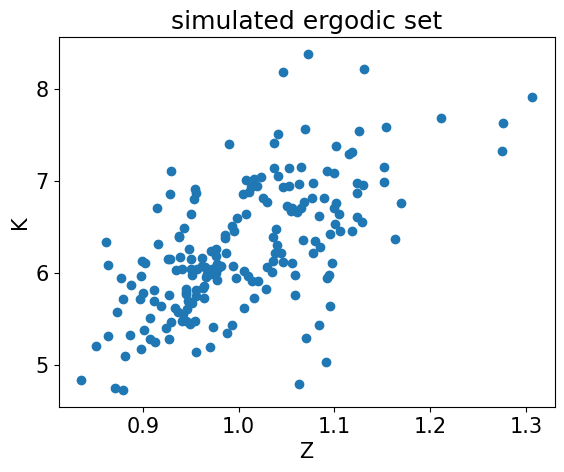

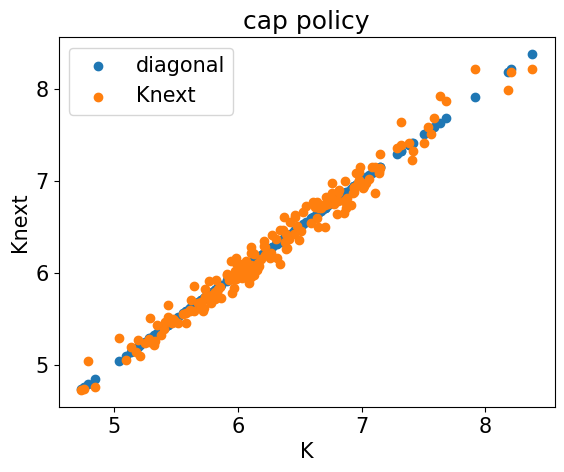

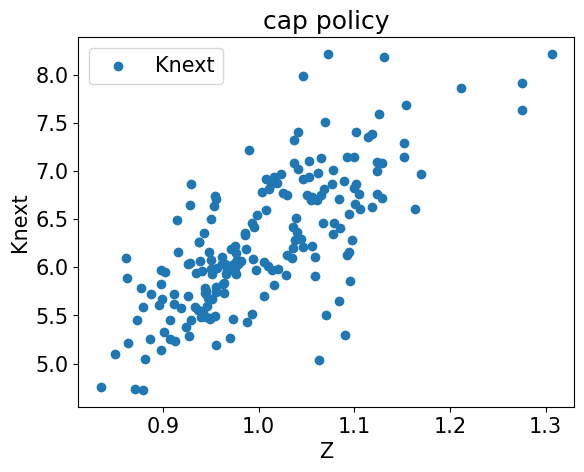

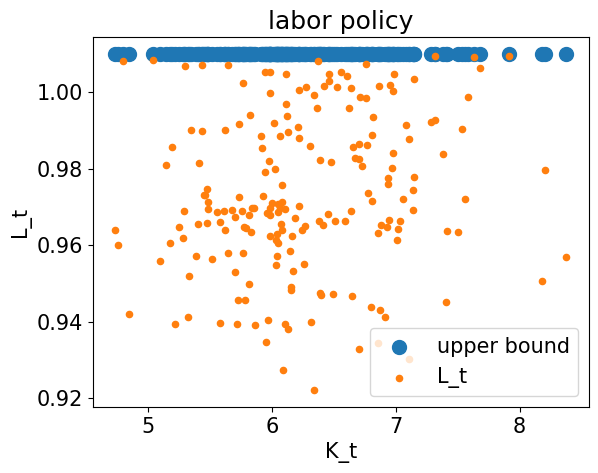

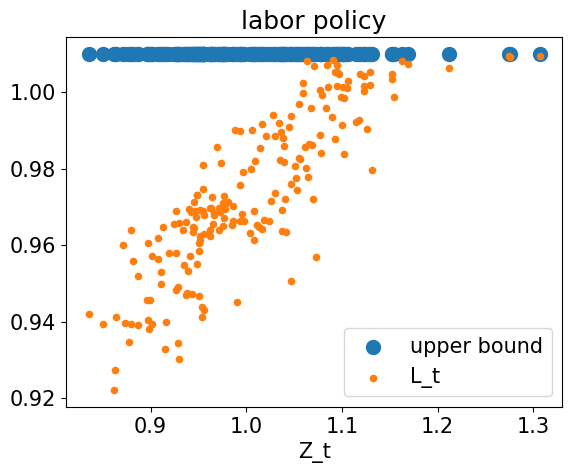

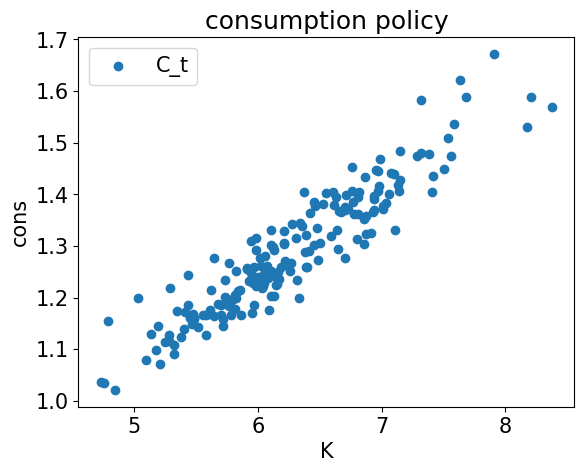

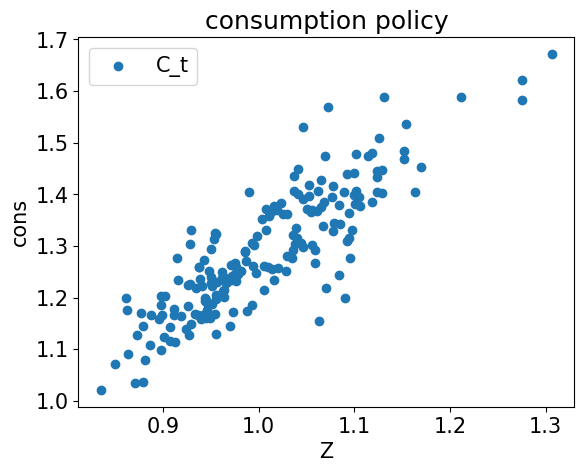

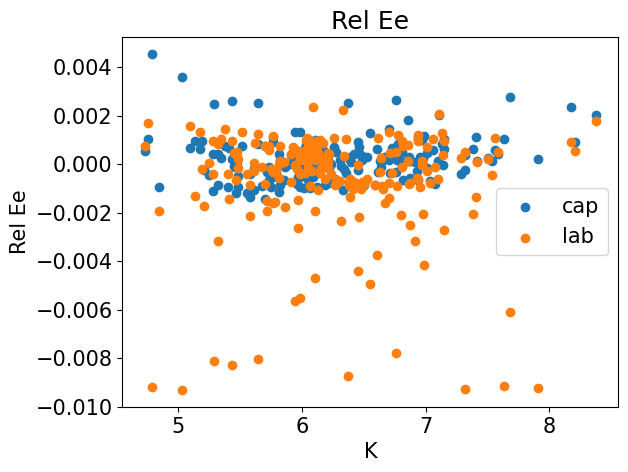

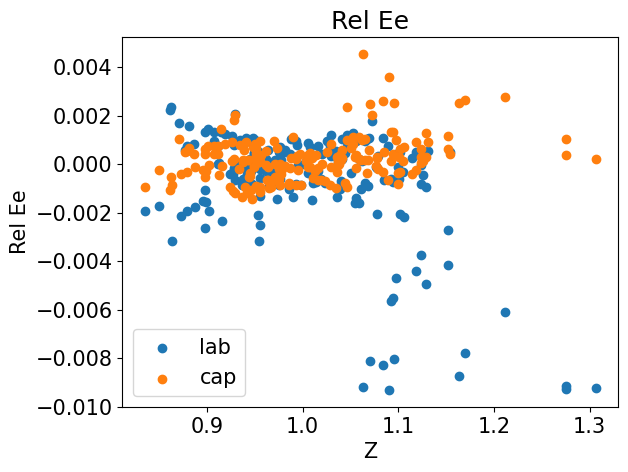

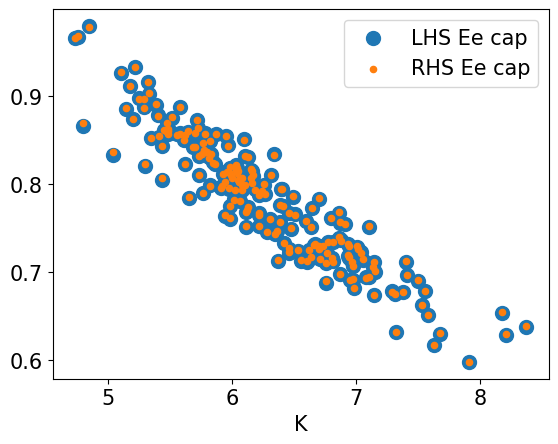

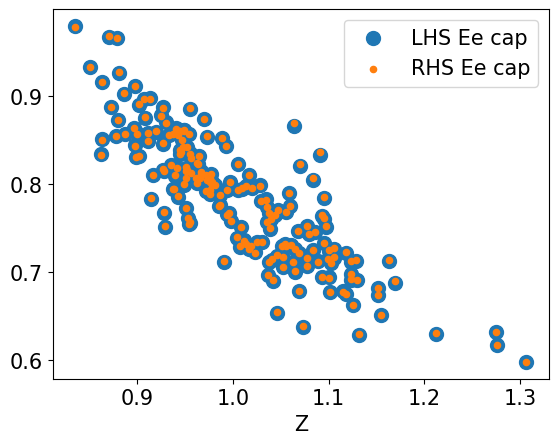

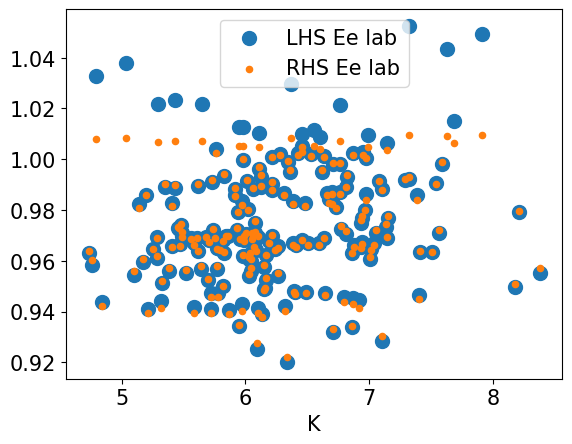

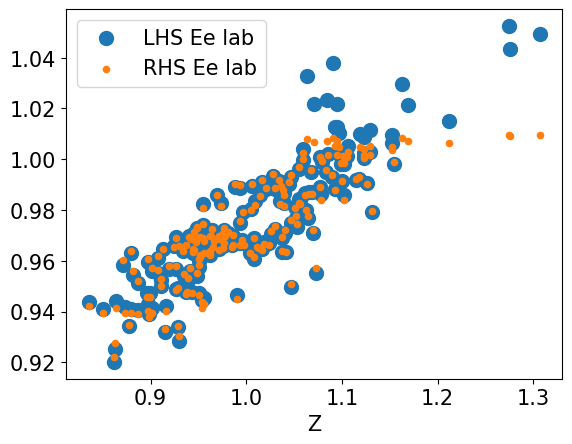

#=================================================================
episode = 1000, loss [log10] = -5.581678867340088
#=================================================================
episode = 2000, loss [log10] = -5.574502944946289
#=================================================================
episode = 3000, loss [log10] = -5.645877361297607
#=================================================================
episode = 4000, loss [log10] = -5.611262321472168


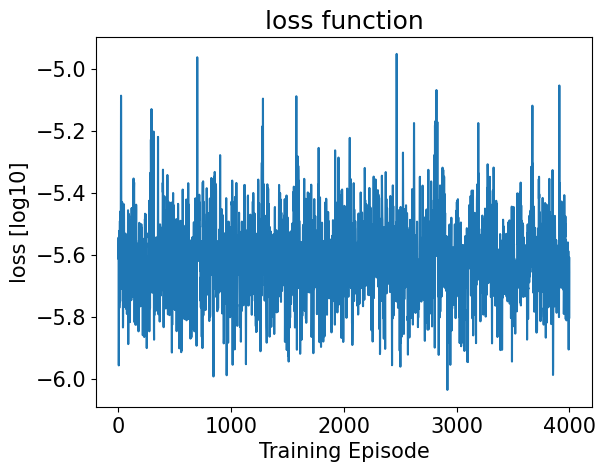

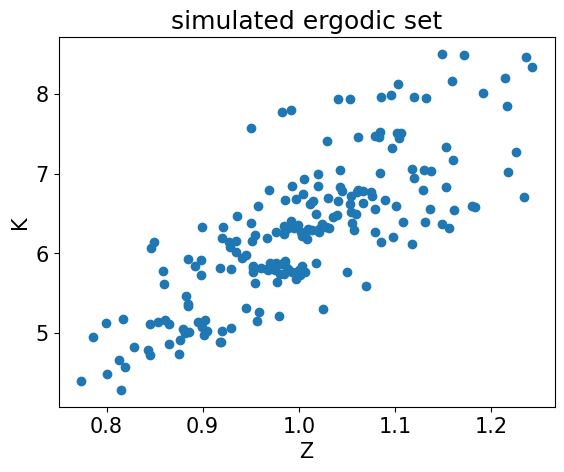

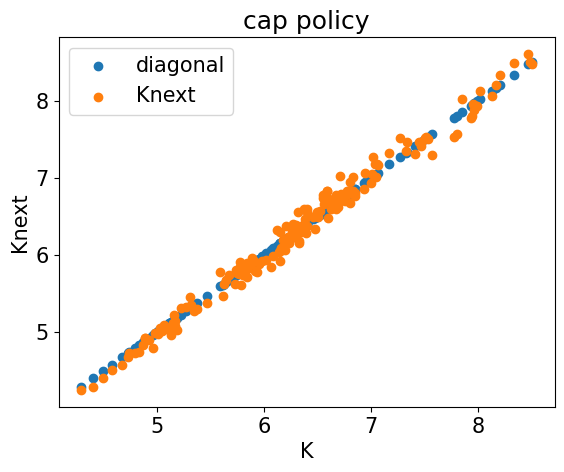

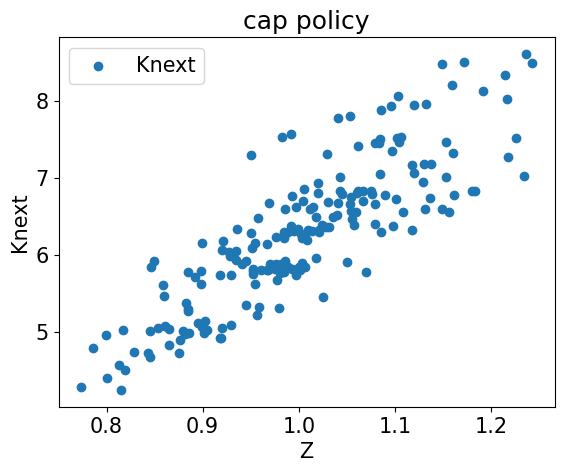

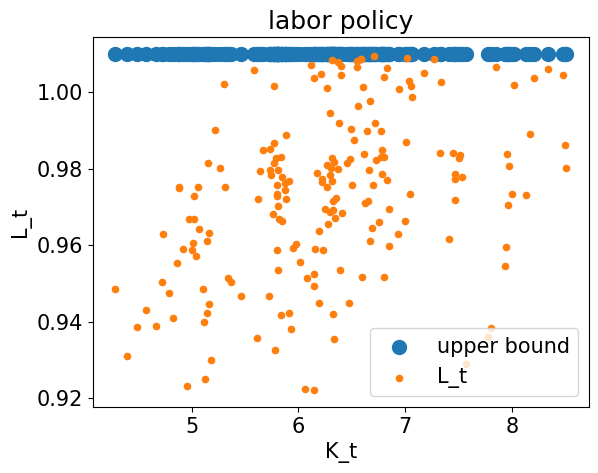

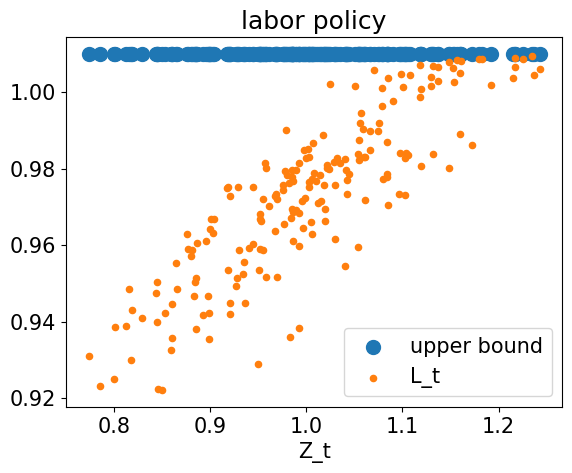

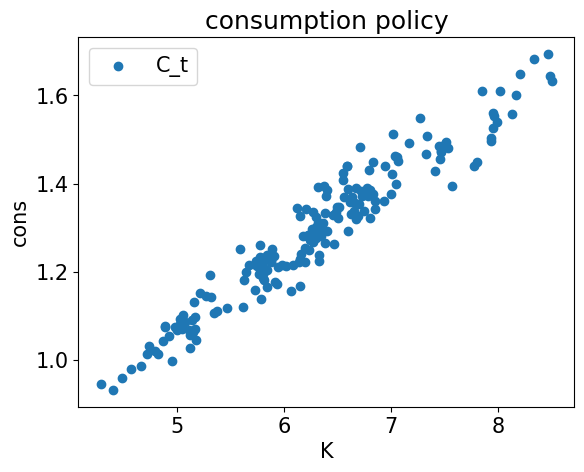

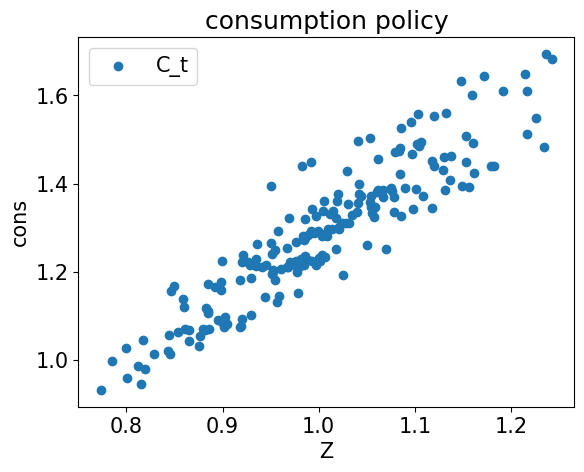

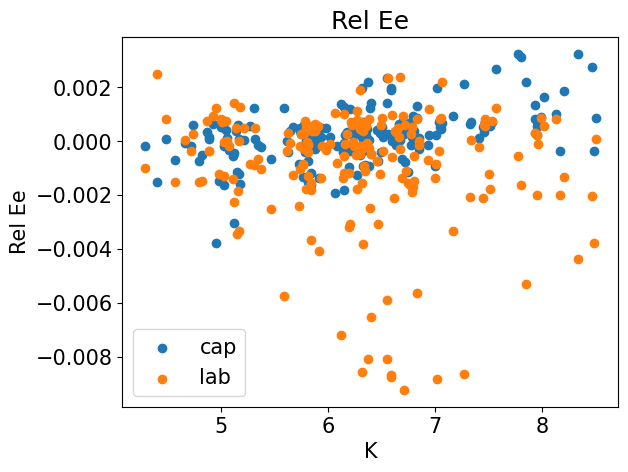

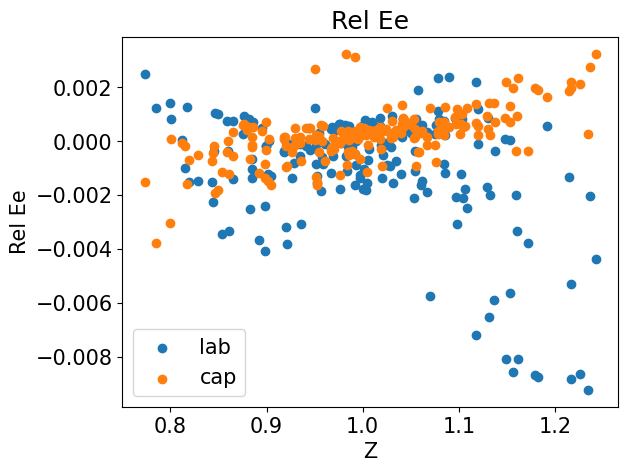

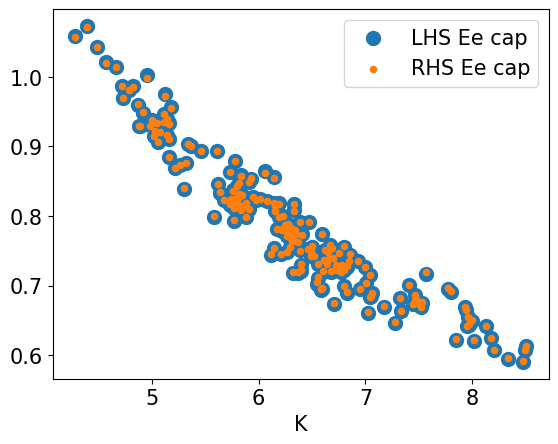

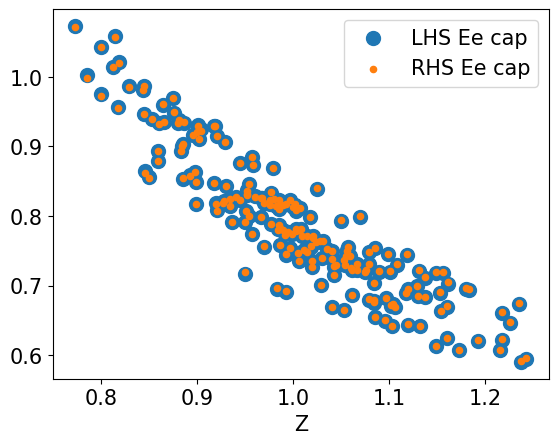

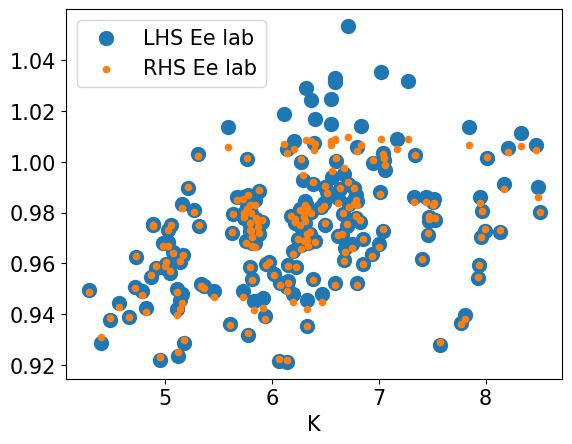

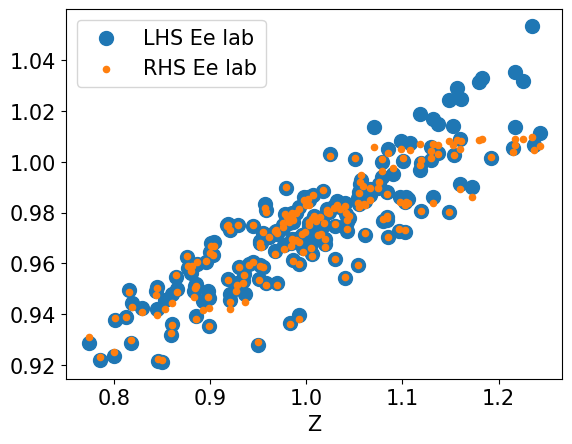

#=================================================================
episode = 5000, loss [log10] = -5.745259761810303
#=================================================================
episode = 6000, loss [log10] = -5.65014123916626
#=================================================================
episode = 7000, loss [log10] = -5.596625804901123
#=================================================================
episode = 8000, loss [log10] = -5.737764835357666


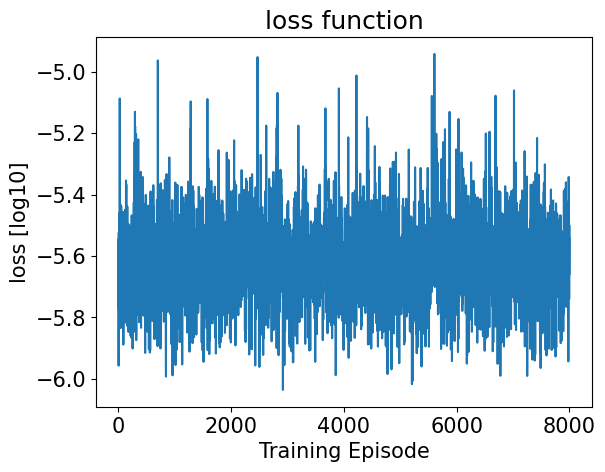

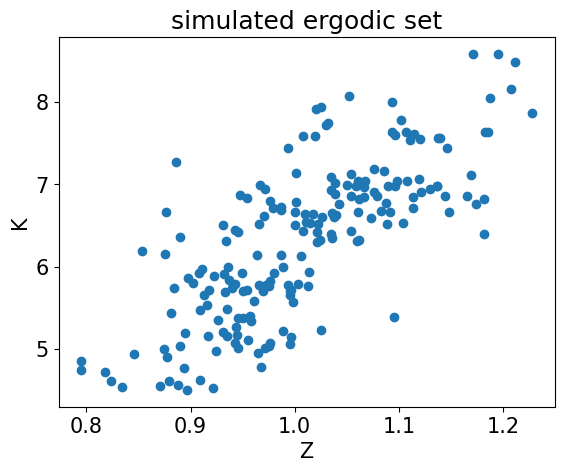

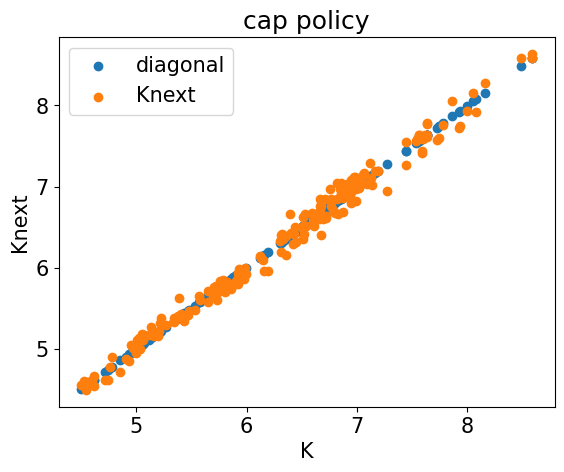

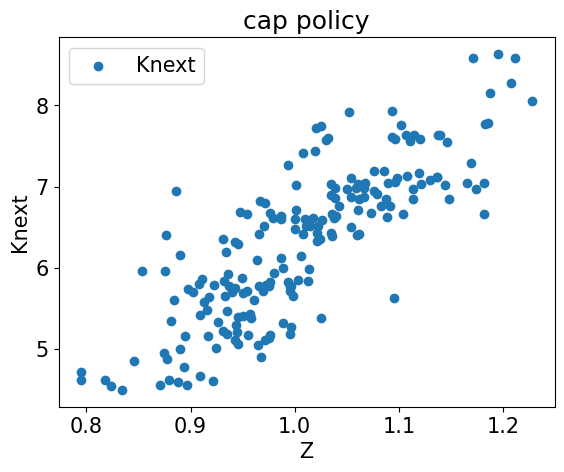

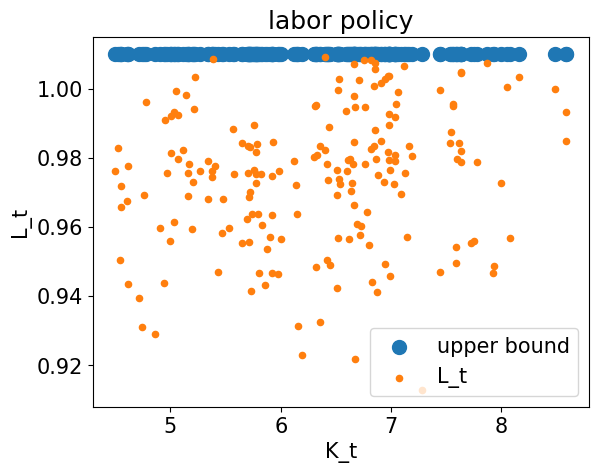

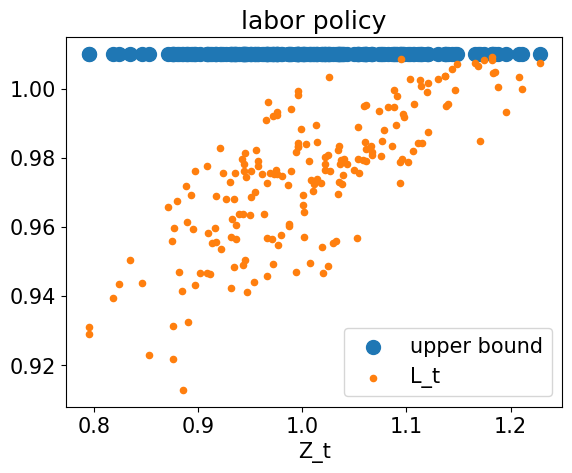

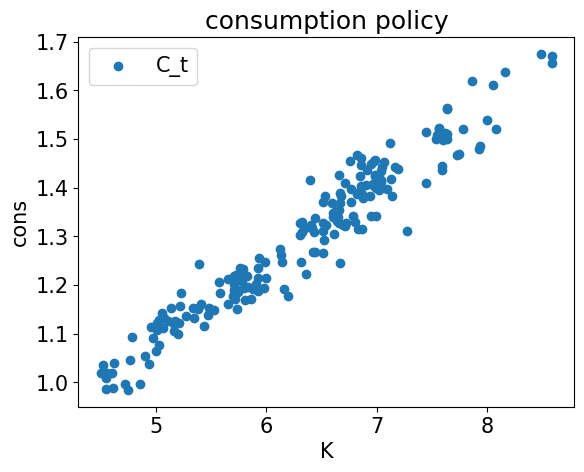

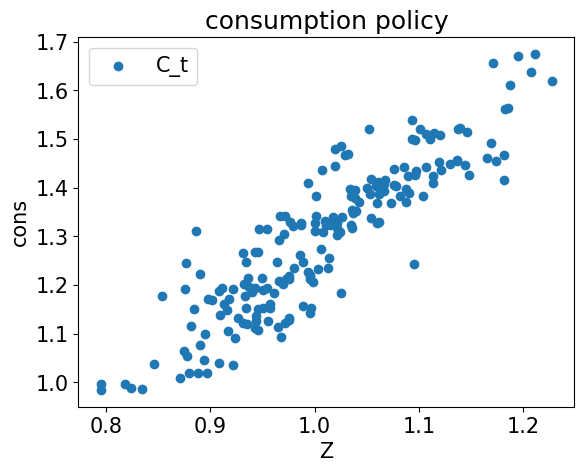

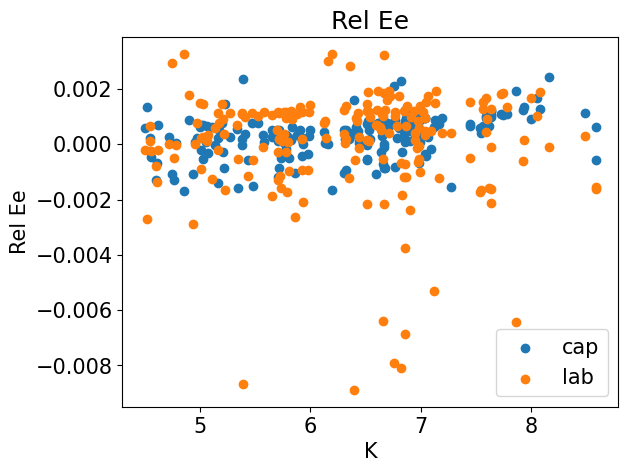

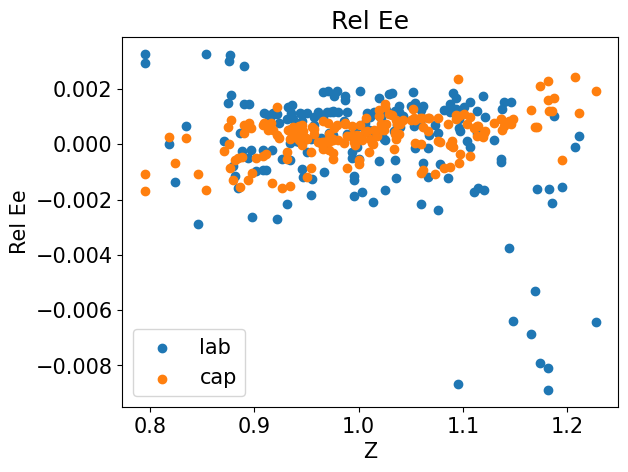

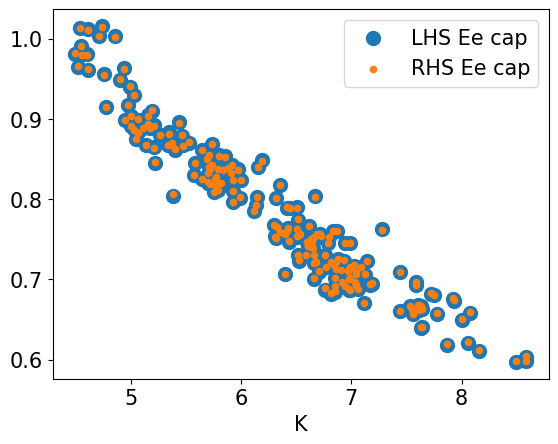

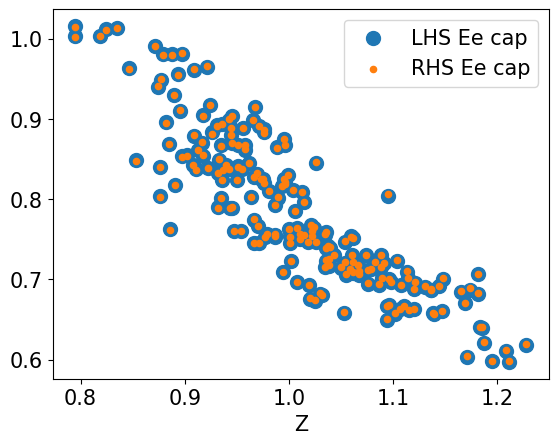

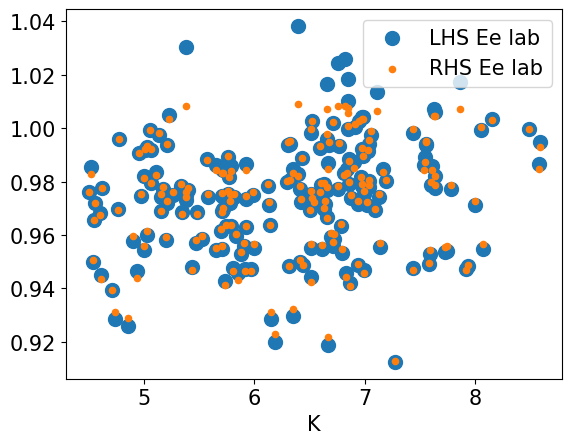

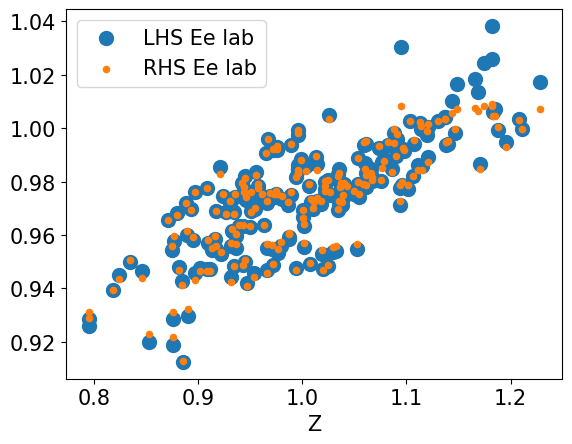

#=================================================================
episode = 9000, loss [log10] = -5.702065944671631
#=================================================================
episode = 10000, loss [log10] = -5.792270660400391
#=================================================================
episode = 11000, loss [log10] = -5.573875904083252
#=================================================================
episode = 12000, loss [log10] = -5.664500713348389


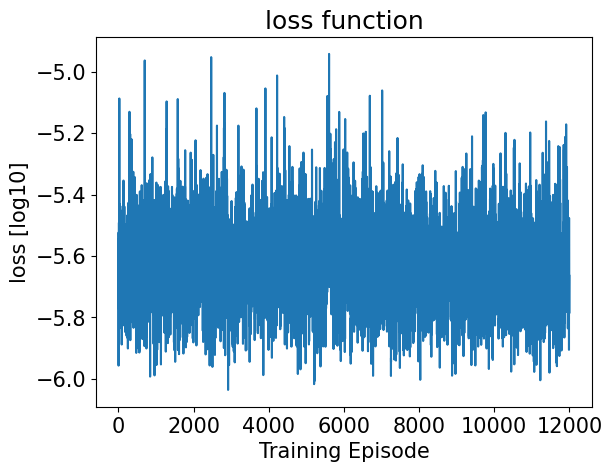

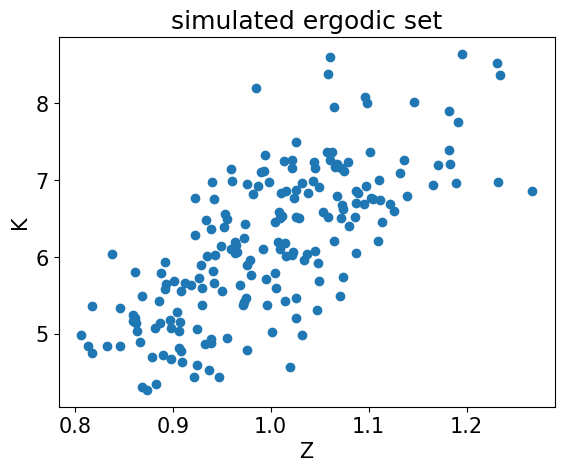

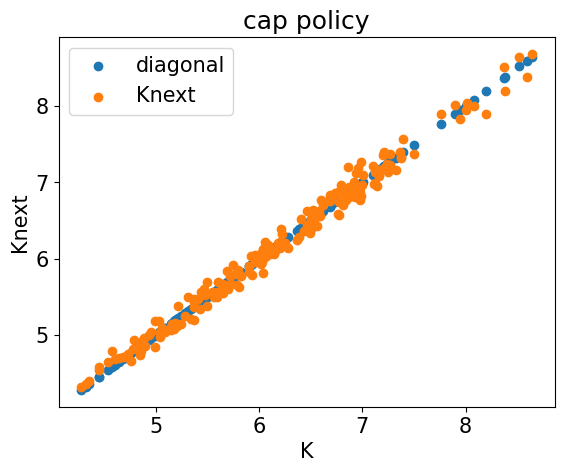

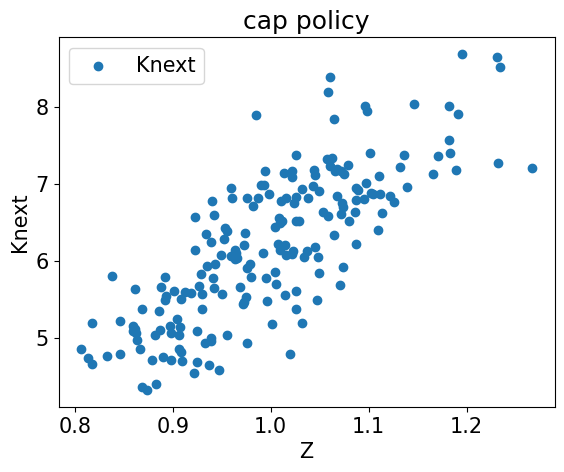

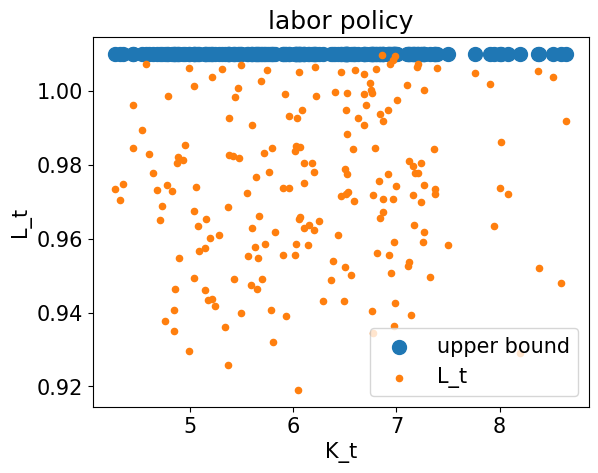

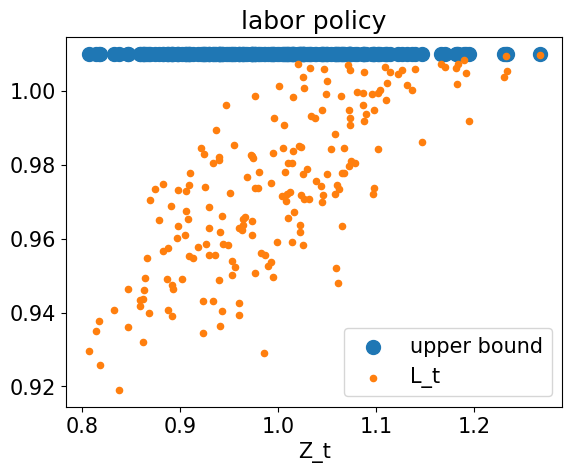

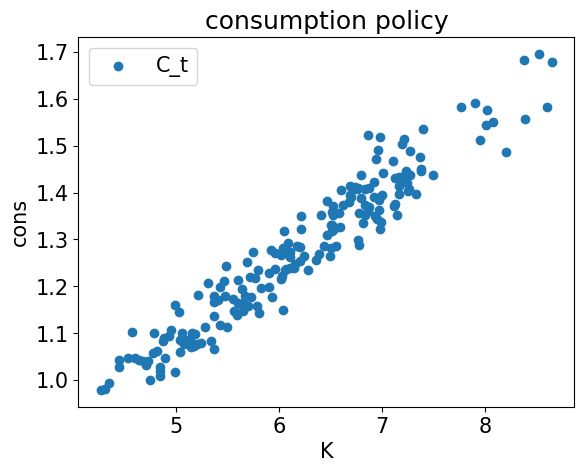

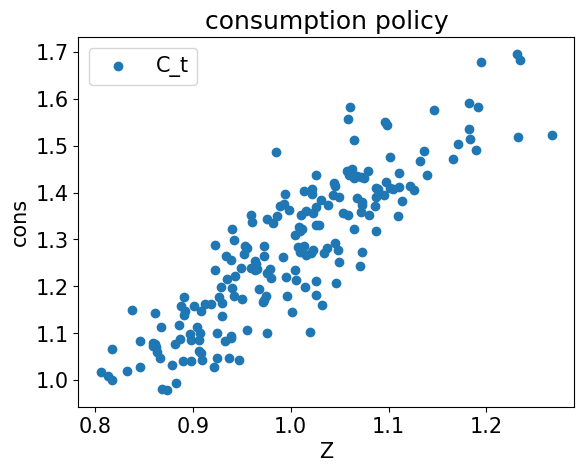

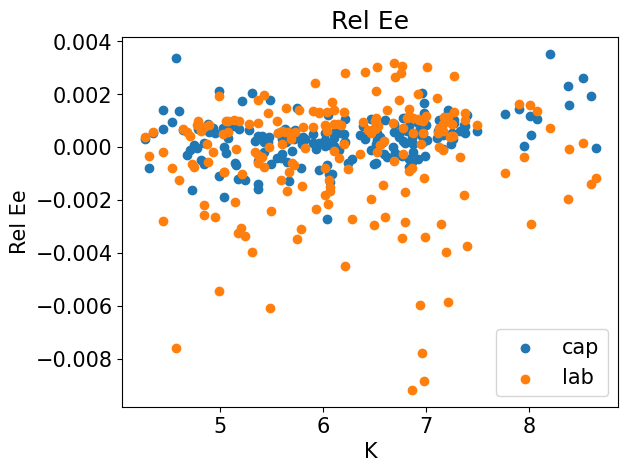

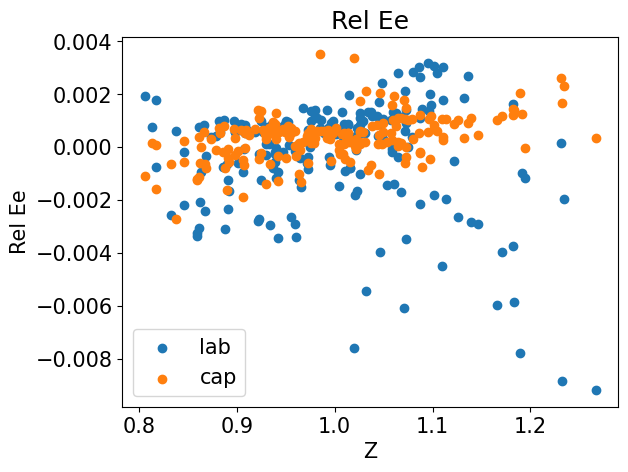

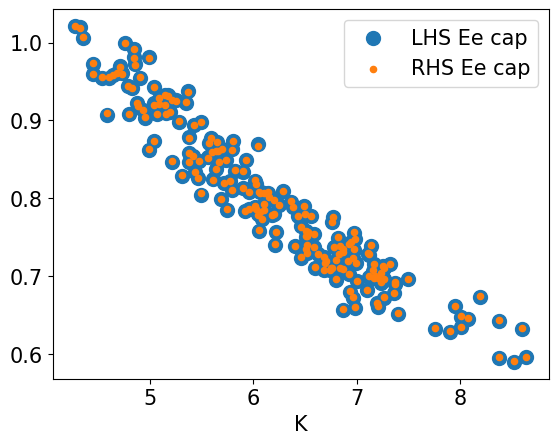

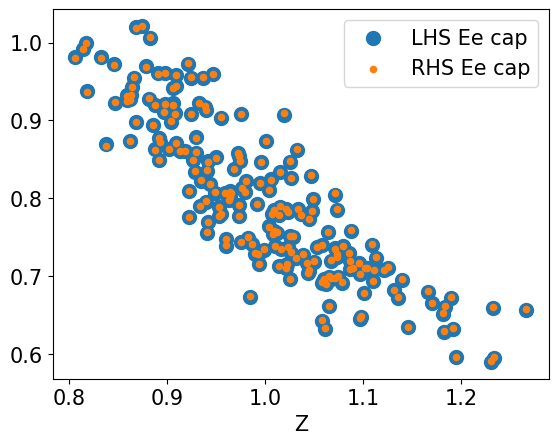

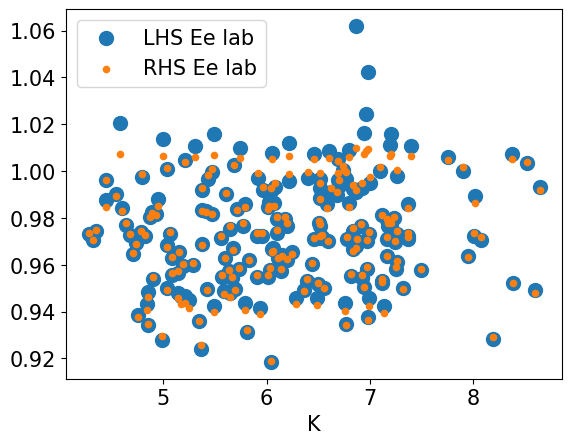

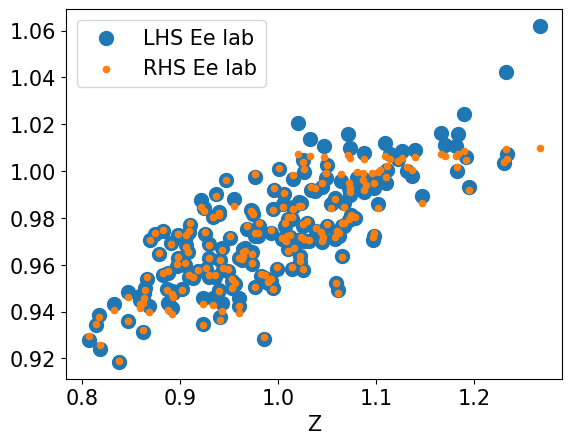

#=================================================================
episode = 13000, loss [log10] = -5.765219688415527
#=================================================================
episode = 14000, loss [log10] = -5.688385486602783
#=================================================================
episode = 15000, loss [log10] = -5.629830837249756
#=================================================================
episode = 16000, loss [log10] = -5.574677467346191


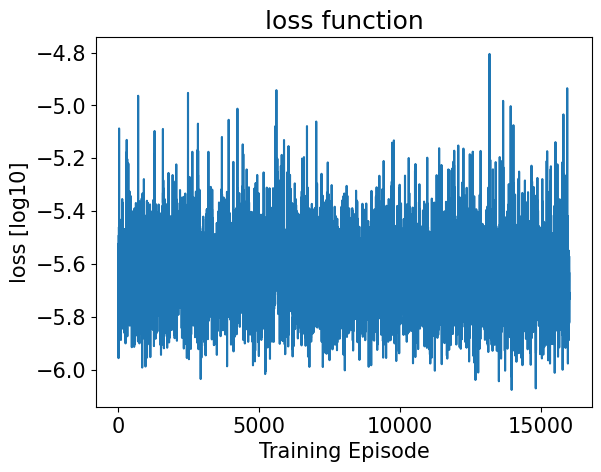

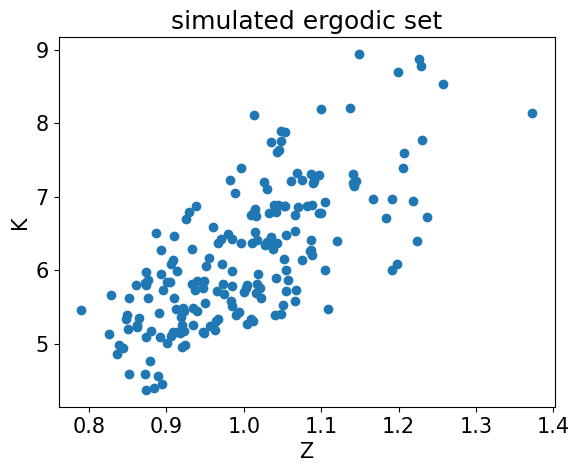

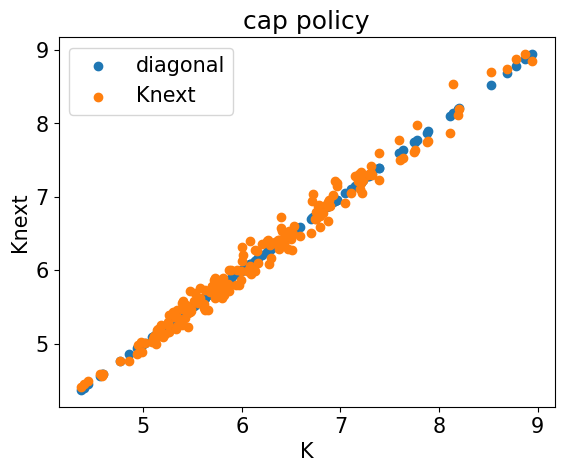

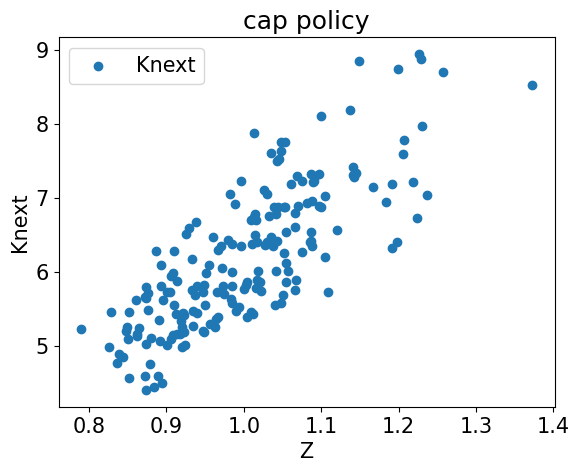

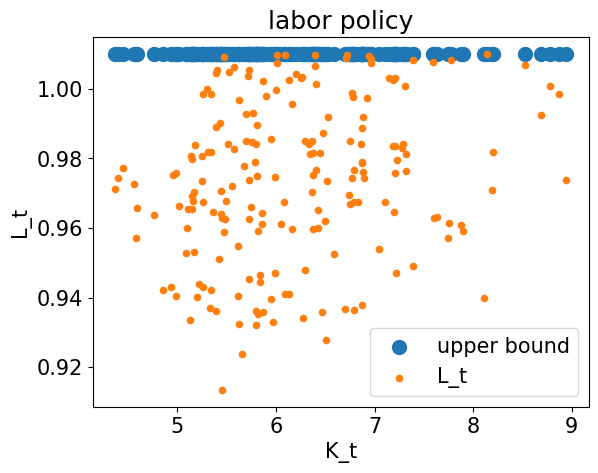

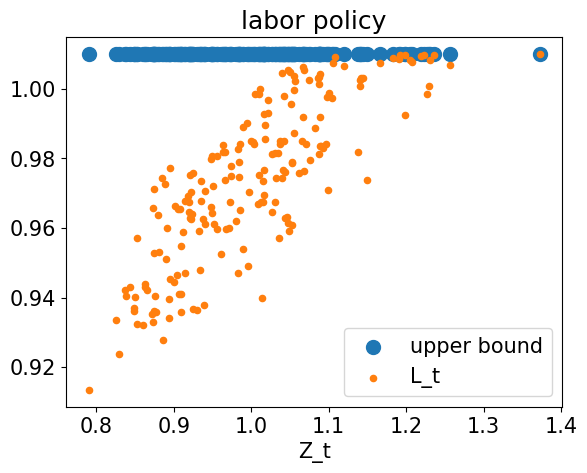

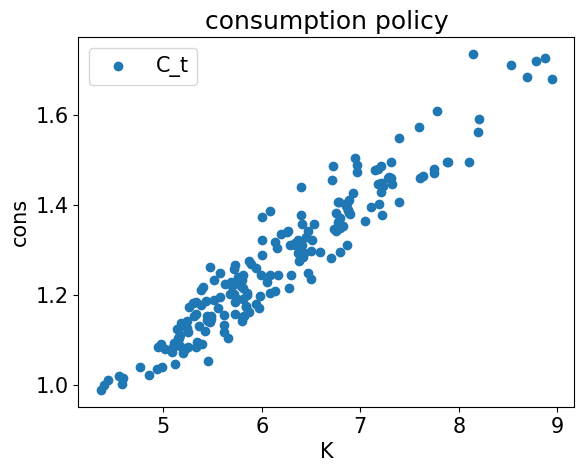

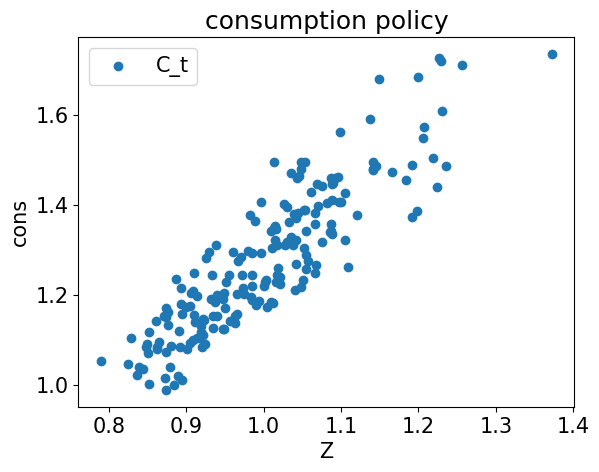

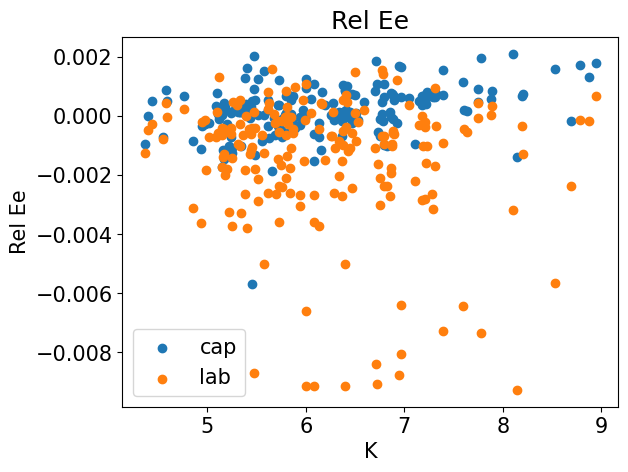

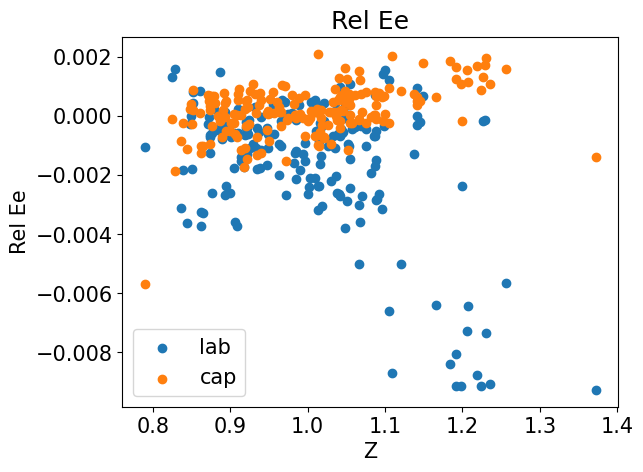

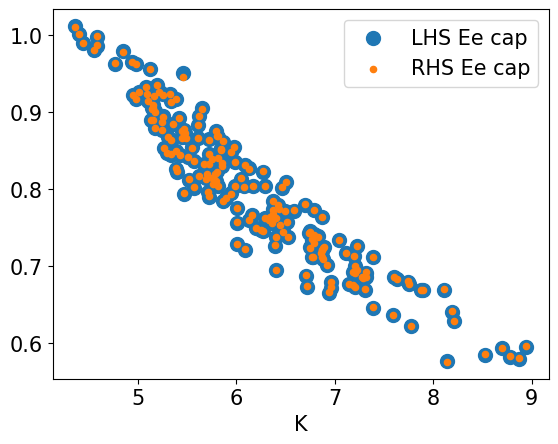

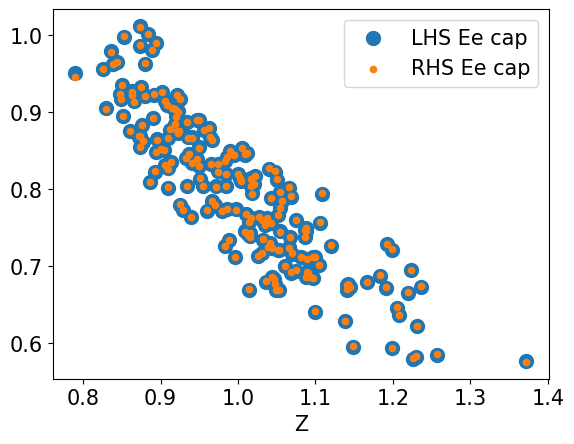

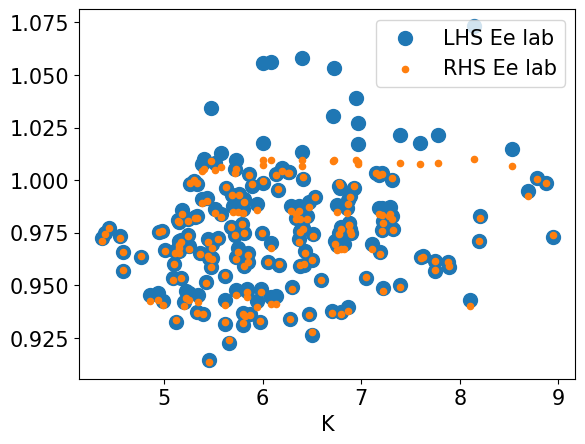

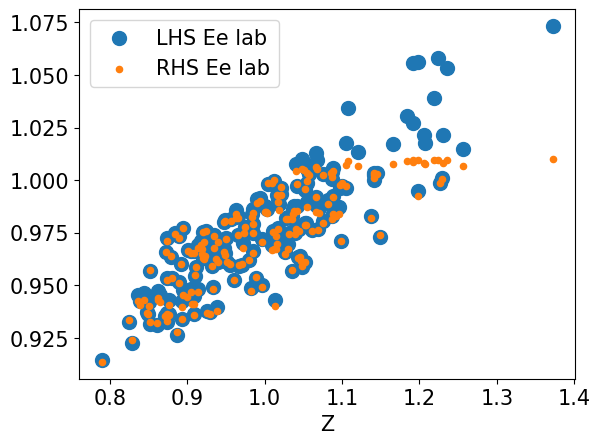

#=================================================================
episode = 17000, loss [log10] = -5.76098108291626
#=================================================================
episode = 18000, loss [log10] = -5.595088958740234
#=================================================================
episode = 19000, loss [log10] = -5.726511478424072
#=================================================================
episode = 20000, loss [log10] = -5.954840183258057


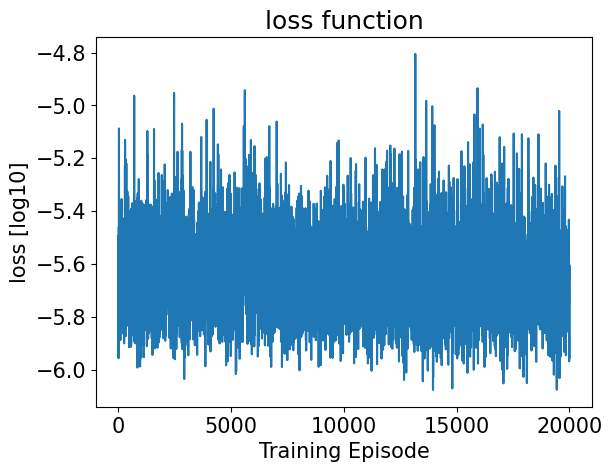

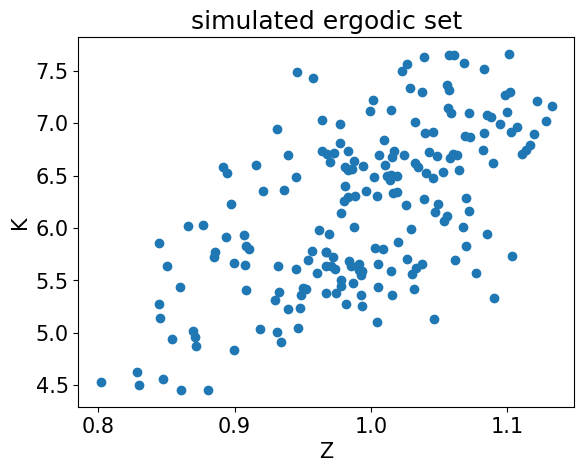

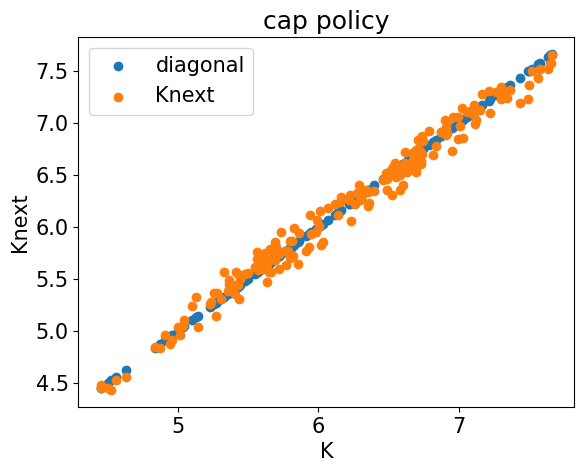

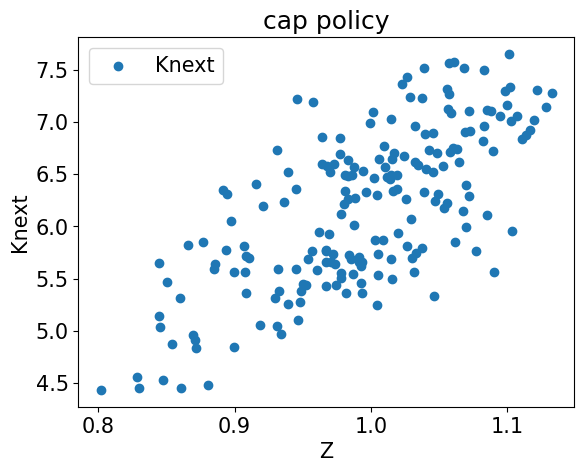

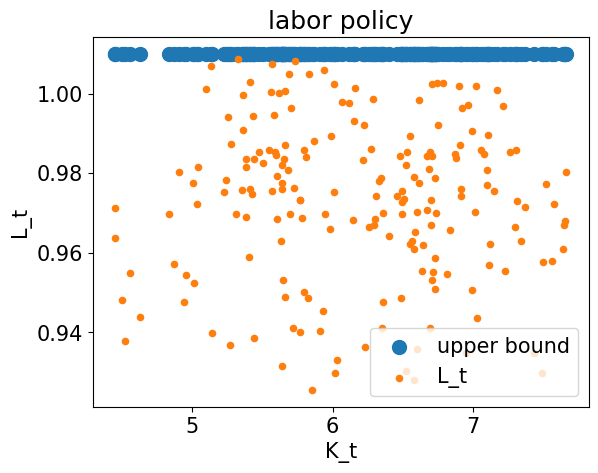

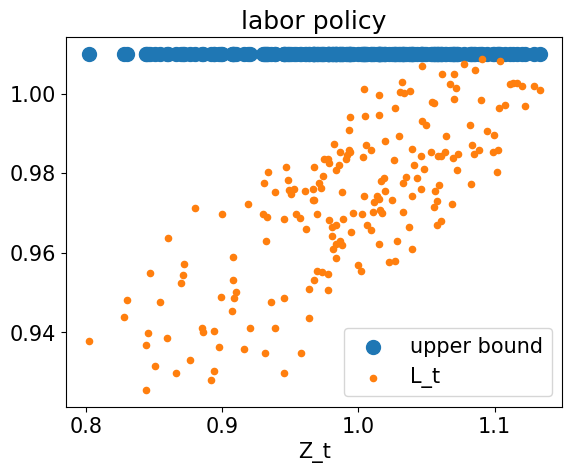

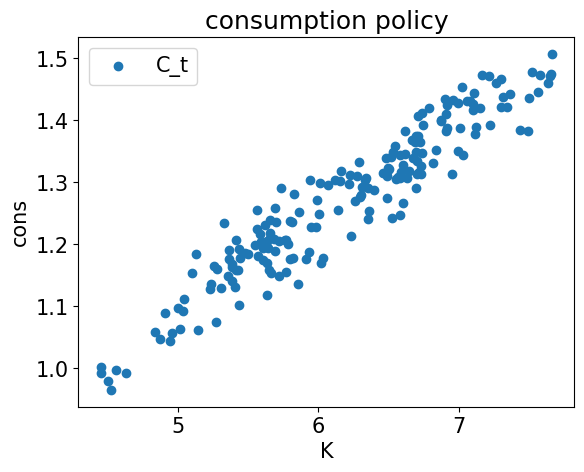

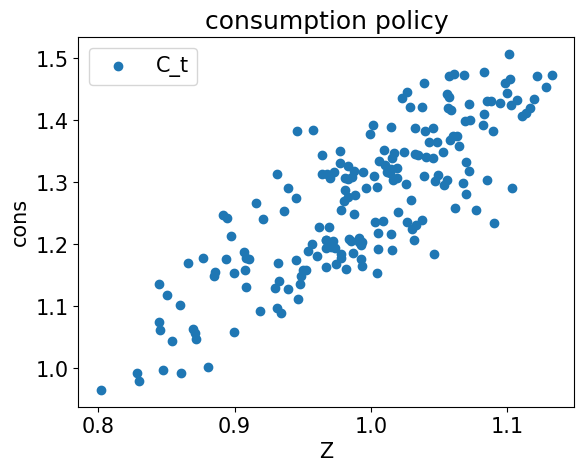

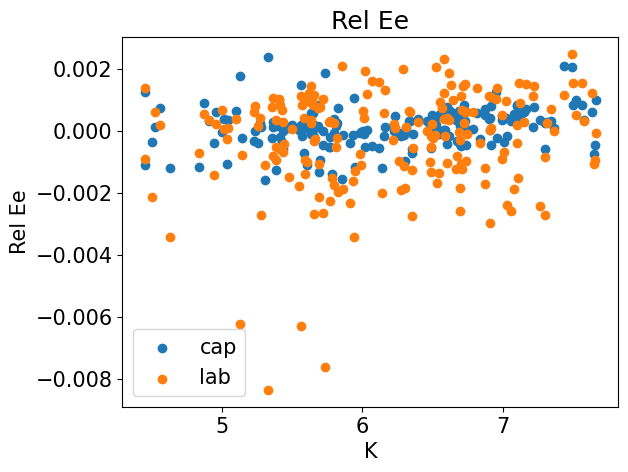

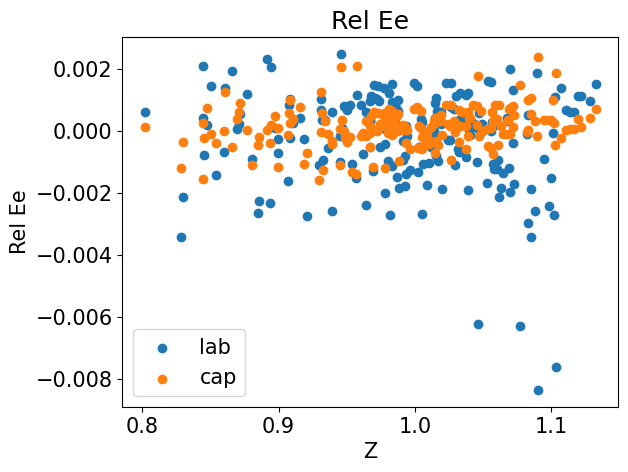

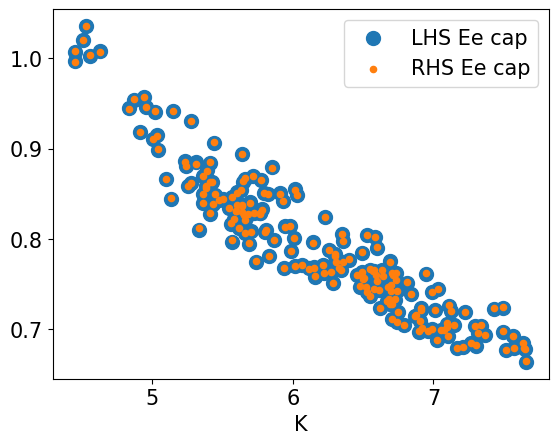

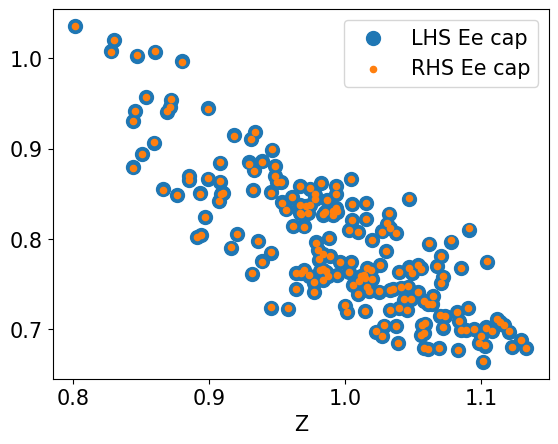

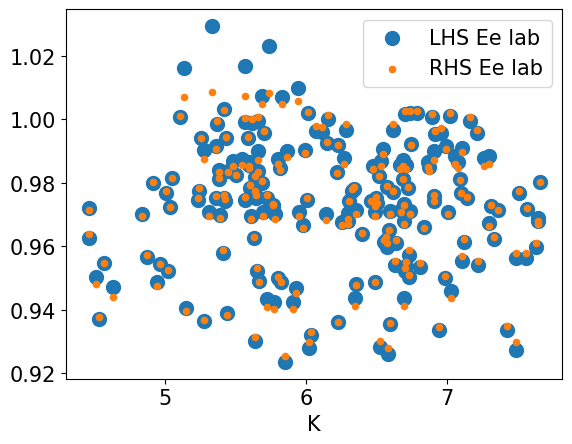

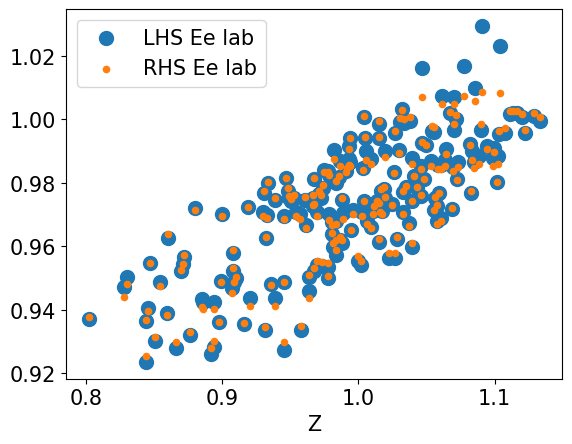

In [135]:
# Keep results for plotting
train_loss = []

num_episodes = 30001

for ep in range(num_episodes):
    # generate training data, now by sampling
    X, X_end = get_training_data_simulation(X_start, nn, n_periods)

    # update X_start
    X_start = X_end
    
    # compute loss and gradients
    loss, grads = grad(X, nn)

    
    # apply gradients
    optimizer.apply_gradients(zip(grads, nn.trainable_variables))
    
    # record loss
    train_loss.append(loss.numpy())
    
    # print progress
    if ep % int(0.05 * num_episodes) == 0:
        print("#=================================================================")
        print("episode = {}, loss [log10] = {}".format(ep, np.log10(loss.numpy())))
        
    if ep % int(0.2 * num_episodes) == 0 or ep == num_episodes - 1:
        cost, errREE_cap, errREE_lab, C_t, K_tplus1, L_t, r_t, w_t, LHS_cap, RHS_cap, LHS_lab, RHS_lab = compute_cost(X, nn)
        
        plt.title("loss function")
        plt.plot(np.log10(np.array(train_loss)))
        plt.xlabel("Training Episode")
        plt.ylabel("loss [log10]")
        plt.show()
        plt.close()
        
        plt.title("simulated ergodic set")
        plt.scatter(X[:, 0], X[:, 1])
        plt.xlabel("Z")
        plt.ylabel("K")
        plt.show()
        plt.close()
        
        
        plt.title("cap policy")
        plt.xlabel("K")
        plt.ylabel("Knext")
        plt.scatter(X[:, 1], X[:, 1], label = "diagonal")
        plt.scatter(X[:, 1], K_tplus1[:, 0], label = "Knext")
        plt.legend()
        plt.show()
        plt.close()

        plt.title("cap policy")
        plt.xlabel("Z")
        plt.ylabel("Knext")
        plt.scatter(X[:, 0], K_tplus1[:, 0], label = "Knext")
        plt.legend()
        plt.show()
        plt.close()
        
           
        plt.title("labor policy")
        plt.xlabel("K_t")
        plt.ylabel("L_t")
        plt.scatter(X[:, 1], 1.01 * np.ones_like(X[:, 1]), s = 100, label = "upper bound")
        plt.scatter(X[:, 1], L_t[:, 0], s = 20, label = "L_t")
        plt.legend()
        plt.show()
        plt.close()

        plt.title("labor policy")
        plt.xlabel("Z_t")
        plt.scatter(X[:, 0], 1.01 * np.ones_like(X[:, 0]), s = 100, label = "upper bound")        
        plt.scatter(X[:, 0], L_t[:, 0], s = 20, label = "L_t")
        plt.legend()
        plt.show()
        plt.close()

        plt.title("consumption policy")
        plt.xlabel("K")
        plt.ylabel("cons")
        plt.scatter(X[:, 1], C_t[:, 0], label="C_t")
        plt.legend()
        plt.show()
        plt.close()

        plt.title("consumption policy")
        plt.xlabel("Z")
        plt.ylabel("cons")
        plt.scatter(X[:, 0], C_t[:, 0], label="C_t")
        plt.legend()
        plt.show()
        plt.close()

        plt.title("Rel Ee")
        plt.xlabel("K")
        plt.ylabel("Rel Ee")
        plt.scatter(X[:, 1], errREE_cap[:, 0], label="cap")
        plt.scatter(X[:, 1], errREE_lab[:, 0], label="lab")
        plt.legend()
        plt.show()
        plt.close()
       
        plt.title("Rel Ee")
        plt.xlabel("Z")
        plt.ylabel("Rel Ee")
        plt.scatter(X[:, 0], errREE_lab[:, 0], label="lab")
        plt.scatter(X[:, 0], errREE_cap[:, 0], label="cap")
        plt.legend()
        plt.show()
        plt.close()
        
        plt.xlabel("K")
        plt.scatter(X[:, 1], LHS_cap[:, 0], s = 100, label="LHS Ee cap")
        plt.scatter(X[:, 1], RHS_cap[:, 0], s = 20, label="RHS Ee cap")
        plt.legend()
        plt.show()
        plt.close()
        
        plt.xlabel("Z")
        plt.scatter(X[:, 0], LHS_cap[:, 0], s = 100, label="LHS Ee cap")
        plt.scatter(X[:, 0], RHS_cap[:, 0], s = 20, label="RHS Ee cap")
        plt.legend()
        plt.show()
        plt.close()
        
        plt.xlabel("K")
        plt.scatter(X[:, 1], LHS_lab[:, 0], s = 100, label="LHS Ee lab")
        plt.scatter(X[:, 1], RHS_lab[:, 0], s = 20, label="RHS Ee lab")
        plt.legend()
        plt.show()
        plt.close()
        
        plt.xlabel("Z")
        plt.scatter(X[:, 0], LHS_lab[:, 0], s = 100, label="LHS Ee lab")
        plt.scatter(X[:, 0], RHS_lab[:, 0], s = 20, label="RHS Ee lab")
        plt.legend()
        plt.show()
        plt.close()

### Exercise 4
In this exercise, we want to consider a life-cycle model, where households live deterministically for $H=6$ periods.  
The firm-side of the economy will remain the same as in the previous exercises.
We can think of one model period as 10 years, so that we model ages 20 to 80.  
We assume that agents can save in capital and that, in the last period of their life, agents consume everything they have.  
Let $h\in \{0, \dots, 5\}$ index the six age-groups, which are alife. 
Let $k_t^h$ denote the capital holding of age-group $h$ in period $t$.  
There is a borrowing constraint, such that $k_t^h\geq 0$.  
We assume that each age-groups supplied their age-dependent efficient units of labor, $l^h$, exogenously.  
In order to avoid modeling a government, we model a smaller amount of efficient units of labor supply during the last two period of life, corresponding to retirement.  
Aggregate capital and labor is given by
\begin{align}
K_t &= \sum_{h\in\mathcal{H}}k_t^h \\
L &= \sum_{h\in\mathcal{H}}l^h.
\end{align}
As before, the return on capital and the wage are given by
\begin{align}
r_t &= \alpha K_t^{\alpha - 1} L^{1 - \alpha}\\
w_t &= (1-\alpha)K_t^\alpha L^{-\alpha}.
\end{align}
The state of the economy is now given by the exogenous shock as well as the distribution of capital across age-groups.  
\begin{align}
\mathbf{x}_t := \begin{pmatrix}Z_t \\ k_t^0 \\ k_t^1 \\ k_t^2 \\ k_t^3 \\ k_t^4 \\ k_t^5 \end{pmatrix}
\end{align}
Except for the last period, households choose how much capital to save for the next period. 
There are hence five policy functions we need to approximate, one for each age group except the last (because we assumed they eat up everything they have).  
\begin{align}
\mathbf{f}(\mathbf{x}_t) = \begin{pmatrix} k_{t+1}^1 \\ k_{t+1}^2 \\ k_{t+1}^3 \\ k_{t+1}^4 \\ k_{t+1}^5 \end{pmatrix}.
\end{align}
Correspondingly, there are five optimality conditions, one for each age-group except the last.  
The optimality condition for age-group $h$ is given by
\begin{align}
\frac{1}{c^h_t} \geq \beta E\left[\frac{1}{c^{h+1}_{t+1}}\left(1 - \delta + r_{t+1}\right)\right]
\end{align}
where
\begin{align}
c_t^h = l^h w_t + k_t^h (1 - \delta + r_t) - k^{h+1}_{t+1}.
\end{align}
We assume that the last age-group eats up everything they have and hence, with a slight abuse of notation $k_{t+1}^6 = 0$.  
Further, we assume that households enter the economy without assets, such that $k_t^0 = 0$.  
The Euler equation above has to hold with equality whenever $k_{t+1}^{h+1}>0$.  
Rewriting the Euler equation in terms of relative consumption errors, we obtain
\begin{align}
0 \geq \frac{1}{c_t^h}\frac{1}{\beta E\left[\frac{1}{c^{h+1}_{t+1}}\left(1 - \delta + r_{t+1}\right)\right]} - 1.
\end{align}
As in exercise 3, we can use the Fischer-Burmeister function to encode the optimality condition into a single equality
\begin{align}
0 &= f^{FB}(a, b)\text{, where}\\
a &= \frac{1}{c_t^h}\frac{1}{\beta E\left[\frac{1}{c^{h+1}_{t+1}}\left(1 - \delta + r_{t+1}\right)\right]} - 1\\
b &= k_{t+1}^{h+1} - 0
\end{align}
Hence we can define our loss function as the sum of the mean squared errors in each of the five optimality conditions.  
To ensure that both, consumption and capital save to the next period, are non-negative we can againuse the sigmoid activation function and approximate the saving rate $s_t^h$ out of total cash-at-hands in the beginning of the period 
\begin{align}
cah_t^h &:= l^h w_t + k_t^h (1 - \delta + r_t)\\
k^{h+1}_{t+1} &= cah_t^h s_t^h.
\end{align}

In [45]:
# we adjust the parameters a bit because now one period corresponds to 10 years
H = 6 # number of age groups
alpha = 0.36  # Capital share in the Cobb-Douglas production function
beta = 0.99 ** 10  # Discount factor
delta = 0.8 # depreciation of capital
sigma_tfp = 0.10 # std. dev. for tfp process innvoations
rho_tfp = 0.9 ** 10 # persistence of tfp process
x_int = x_int_norm * sigma_tfp # adjust the integration nodes

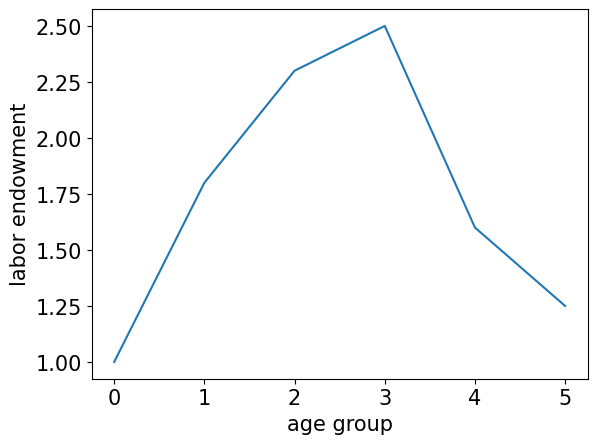

In [46]:
# now we define our labor endowment
l_cycle = tf.constant([1.0, 1.8, 2.3, 2.5, 1.6, 1.25])
# get aggregate labor
L = tf.math.reduce_sum(l_cycle)

plt.plot(l_cycle)
plt.xlabel("age group")
plt.ylabel("labor endowment")
plt.show()

In [47]:
@tf.function
def fischer_burmeister(a, b):
    return (tf.math.abs(a ** 2 + b ** 2 + 1e-13) ** 0.5 - a - b)

In [48]:
# Layer setting
num_input = 1 + H # shock and distribution of asset holdings
num_hidden1 = 10 * num_input
num_hidden2 = 10 * num_input
num_output = H - 1 # savings policy except for last household
layers_dim = [num_input, num_hidden1, num_hidden2, num_output]
print("Dimensions of each layer are {}".format(layers_dim))

Dimensions of each layer are [7, 70, 70, 5]


In [49]:
# we use sigmod in the output layer so output is between 0 and 1
nn = keras.Sequential([
    keras.layers.Dense(num_hidden1, activation='relu', input_shape=(num_input,)),
    keras.layers.Dense(num_hidden2, activation='relu'),
    keras.layers.Dense(num_output, activation = 'sigmoid')
])


Again we start by implementing the term inside the expectation.  
Here, we now have to compute the term for each of the H age groups (technically we do not need it for the first, but we will do it for consistency).

In [77]:
@tf.function
def get_singleinside(X_tplus1, nn):
    n_data = X_tplus1.shape[0] # number of states is on the axis 0
    dim_state = X_tplus1.shape[1] # dimensionality of the state is on axis 1
    
    # read out the state 
    Z_tplus1 = X_tplus1[:, 0 : 1]
    k_tplus1 = X_tplus1[:, 1 : 1 + H]
    
    
    # compute aggregate capital
    K_tplus1 = tf.math.reduce_sum(k_tplus1, axis = 1, keepdims = True)
    
    # compute output
    Y_tplus1 = Z_tplus1 * K_tplus1 ** alpha * L ** (1. - alpha)
    
    # compute the return and wage
    r_tplus1 = alpha * (Y_tplus1 / K_tplus1)
    w_tplus1 = (1 - alpha) * (Y_tplus1 / L)
    
    # compute cash at hand for each age group, the dimensions are (n_data, H) (the age-groups on axis 1, the batch on axis 0)
    cah_tplus1 = l_cycle[tf.newaxis, :] * w_tplus1 + k_tplus1 * (1. - delta + r_tplus1)
    
    
    """
    Exercise:
    obtain 'c_tplus1'.
    The dimensions of 'c_tplus1' should be (n_data, H) (the age-groups on axis 1, the batch on axis 0)
    """
    """
    Solution:
    """
    #=====================================================================
    s_t = nn(X_tplus1)
    s_t = tf.concat([s_t, tf.zeros((n_data, 1))], axis = 1)
    c_tplus1 = (1 - s_t) * cah_tplus1 
    
    #=====================================================================
    
    # compute term inside the expectation
    ret = (1. /  c_tplus1) * (1. - delta + r_tplus1)
    
    return ret

In [79]:
@tf.function
def compute_cost(X, nn):
    """ 
    Compute the mean squared error in the equilibrium conditions.
    """
    n_data = X.shape[0] # number of states is on the axis 0
    dim_state = X.shape[1] # dimensionality of the state is on axis 1
    
    # read out the state
    Z_t = X[:, 0 : 1]
    k_t = X[:, 1 : 1 + H]
    
    # get aggregate capital 
    K_t = tf.math.reduce_sum(k_t, axis = 1, keepdims = True)
    
    # compute output
    Y_t = Z_t * K_t ** alpha * L ** (1 - alpha)

    # compute return and wages
    r_t = alpha * (Y_t / K_t)
    w_t = (1. - alpha) * (Y_t / L)
    
    # compute cah
    cah_t = l_cycle[tf.newaxis, :] * w_t + k_t* (1. - delta + r_t)
    
    # use the neural network to predict the savings rate
    s_t = nn(X)
    # attach a zero for the last age group
    s_t = tf.concat([s_t, tf.zeros((n_data, 1))], axis = 1)
    
    # get the implied savings
    sav_t = cah_t * s_t
    
    # get consumption
    c_t = cah_t - sav_t
    
    # now we have to compute the expectation
    expectation = tf.zeros((n_data, H))
    
    """
    Exercise:
    write a loop that evaluates the term inside the expectation operator.
    Axis 0 should refer to the batch dimension, axis 1 should refer to age-groups 0,..., H - 1 at period t+1.
    """
    """
    Solution:
    """
    #=====================================================================

    # we loop over the integration nodes
    for i in range(n_int):
        # integration weight
        weight_i = w_int[i]
        
        # innovation to the AR(1)
        innovation_i = x_int[i]

        # construct exogenous shock at t+1
        Z_tplus1 = tf.exp(rho_tfp * tf.math.log(Z_t) + innovation_i)
        # construct state at t+1
        X_tplus1 = tf.concat([Z_tplus1, sav_t], axis = 1)


        # compute term inside the expectation
        inside_i = get_singleinside(X_tplus1, nn)

        
        # add term to the expectaion with the appropriate weight
        expectation = expectation + weight_i * inside_i
    
    
    #=====================================================================
    
    # now we have all terms to construct the relative Euler error
    # note that age-goup h in period t will be age-group h+1 in periond t+1
    # Define the relative Euler error
    errREE = fischer_burmeister(1. / (c_t[:, 0 : H - 1] * beta * expectation[:, 1 : H]) - 1., sav_t[:, 0 : H - 1] / c_t[:, 0 : H - 1])
    
    # compute the cost, i.e. the mean square error in the equilibrium conditions
    cost = tf.reduce_mean(errREE ** 2)
    
    # we return some more things for plotting
    LHS = 1. / c_t[:, 0 : H - 1] # LHS of Ee
    RHS = beta * expectation[:, 1 : H] # RHS of Ee

    return cost, errREE, c_t, sav_t, r_t, LHS, RHS, cah_t

In [80]:
X = np.zeros((64, 1 + H))
X[:, 0] = np.exp(np.random.rand(64))
X[:, 1 : 1 + H] = np.exp(np.random.rand(64, H))
X= tf.constant(X, dtype = tf.float32)

In [60]:
X_end = X

In [81]:
compute_cost(X, nn)[0]

2023-08-23 16:49:20.718965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


<tf.Tensor: shape=(), dtype=float32, numpy=1.8923734>

In [82]:
def grad(X, nn):
    with tf.GradientTape() as tape:
        loss_value = compute_cost(X, nn)[0]
    return loss_value, tape.gradient(loss_value, nn.trainable_variables)

learning_rate = 0.0003
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [86]:
@tf.function
def simulate_single_step(X_t, eps_tplus1, nn):
    # function simulates the economy one step forward based on the neural network policy and the innovation
    
    n_data = X_t.shape[0] # number of states is on the axis 0
    dim_state = X_t.shape[1] # dimensionality of the state is on axis 1
    
    # read out the state
    Z_t = X_t[:, 0 : 1]
    k_t = X_t[:, 1 : 1 + H]
    
    # get aggregate capital 
    K_t = tf.math.reduce_sum(k_t, axis = 1, keepdims = True)
    
    # compute output
    Y_t = Z_t * K_t ** alpha * L ** (1 - alpha)

    # compute return and wages
    r_t = alpha * (Y_t / K_t)
    w_t = (1. - alpha) * (Y_t / L)
    
    """
    Exercise:
    obtain the savings 'sav_t'.
    The dimensions of 'sav_t' should be (n_data, H) (the age-groups on axis 1, the batch on axis 0).
    """
    """
    Solution:
    """
    #=====================================================================

    # compute cah
    cah_t = l_cycle[tf.newaxis, :] * w_t + k_t* (1. - delta + r_t)
    
    # use the neural network to predict the savings rate
    s_t = nn(X)
    # attach a zero for the last age group
    s_t = tf.concat([s_t, tf.zeros((n_data, 1))], axis = 1)
    
    # get the implied savings
    sav_t = cah_t * s_t
    
    # get consumption
    c_t = cah_t - sav_t
    
    #=====================================================================
    
    # get tfp in the next period
    Z_tplus1 = tf.exp(rho_tfp * tf.math.log(Z_t) + sigma_tfp * eps_tplus1)    
    
    """
    Exercise:
    Construct the state in the next period 'X_tplus'.
    Keep in mind that the new age-group enters the economy without assets.
    """
    """
    Solution:
    """
    #=====================================================================
    # construct the next state

    X_tplus1 = tf.concat([tf.zeros((n_data, 1)), sav_t[:, :]], axis = 1)

    #=====================================================================

    return X_tplus1

def sim_periods(X_start, nn, num_periods):
    n_tracks = X_start.shape[0] # number of states is on the axis 0
    dim_state = X_start.shape[1] # dimensionality of the state is on axis 1
    
    # create an empty array to store the states
    X_simulation = np.empty((num_periods, n_tracks, dim_state)) # 0 axis: time period, 1 axis: the different trajectories, 2 axis: the different state variables
    
    # draw random innovation
    eps = tf.random.normal((num_periods, n_tracks), dtype = tf.float32)
    
    # set starting state
    X_simulation[0, :, :] = X_start
    
    X_old = X_start
    
    # simulate the periods
    for t in range(1, num_periods):
        eps_use = eps[t, :, tf.newaxis] # newaxis makes sure the shape is n_tracks x 1
        
        X_new = simulate_single_step(X_old, eps_use, nn)
        
        X_simulation[t, :, :] = X_new
        
        X_old = X_new
        
    return X_simulation

def get_training_data_simulation(X_start, nn, n_periods):
    n_tracks = X_start.shape[0]
    n_dim = X_start.shape[1]
    
    # we simulate the model
    X_simulation = sim_periods(X_start, nn, n_periods)
    
    # we read out the last state (so that we can use it as starting poit for the next simulation)
    X_end = np.float32(X_simulation[-1, :, :])
    
    # we reshape the data into (n_tracks * n_periods) x 2 array 
    X_training = np.float32(np.reshape(X_simulation, (n_tracks * n_periods, n_dim)))
    
    return X_training, X_end 

In [87]:
n_periods = 4

n_tracks =  64
n_periods =  4


2023-08-23 16:52:13.635641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-23 16:52:14.291953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_4_grad/StatefulPartitionedCall_4_6' with dtype int32
	 [[{{node gradients/StatefulPartitionedCall_4_grad/StatefulPartitionedCall_4_6}}]]
2023-08-23 16:52:14.306713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_3_grad/StatefulPartitionedCall_3_6' with dtype int32
	 [[{{node gradients/StatefulPartitionedCall_3_grad/StatefulP

#=================================================================
episode = 0, loss [log10] = 0.10852761566638947


2023-08-23 16:52:19.611130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


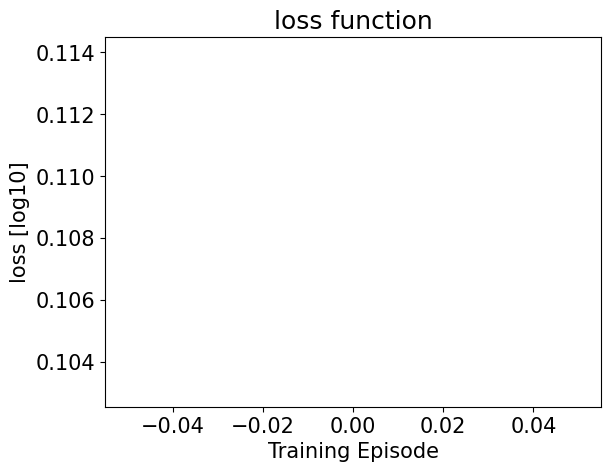

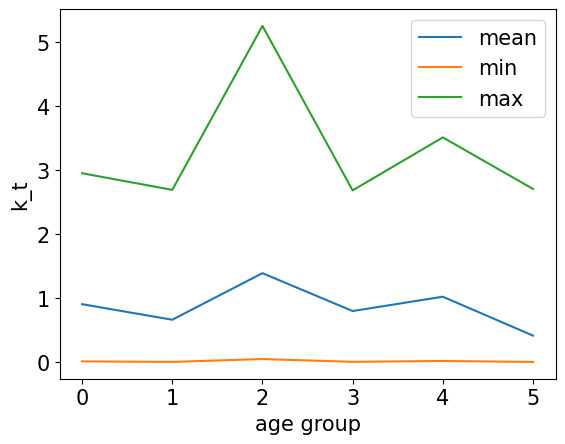

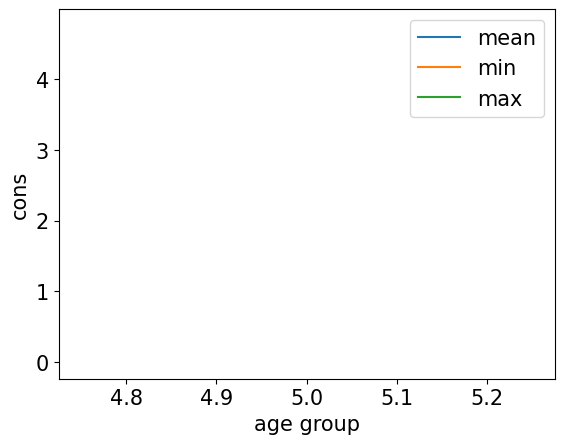

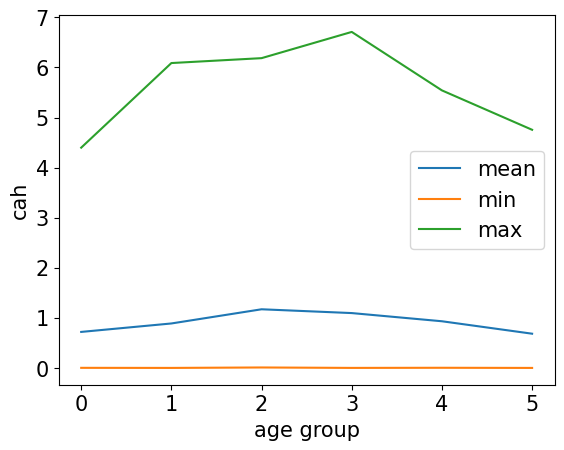

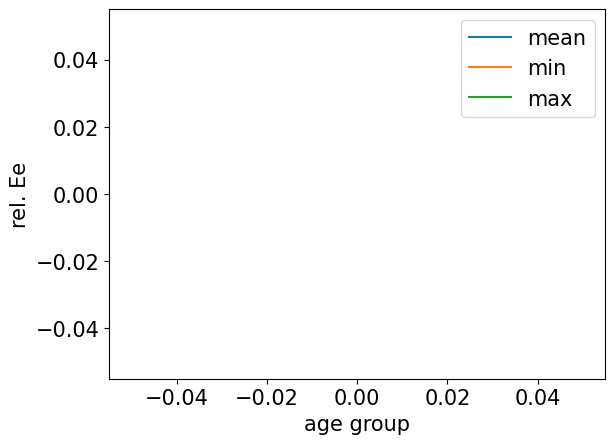

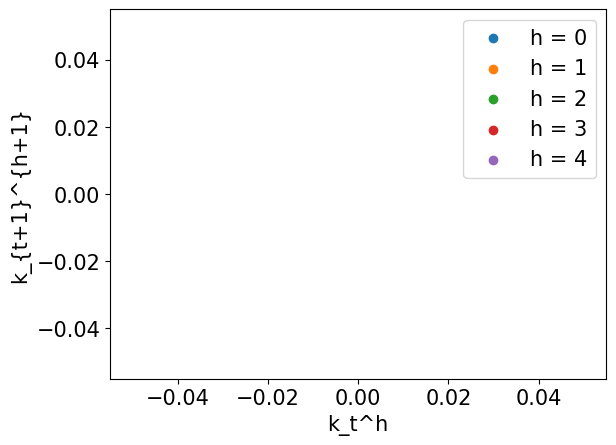

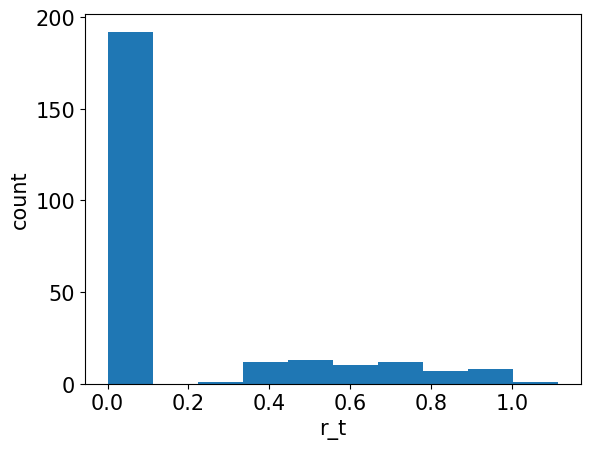

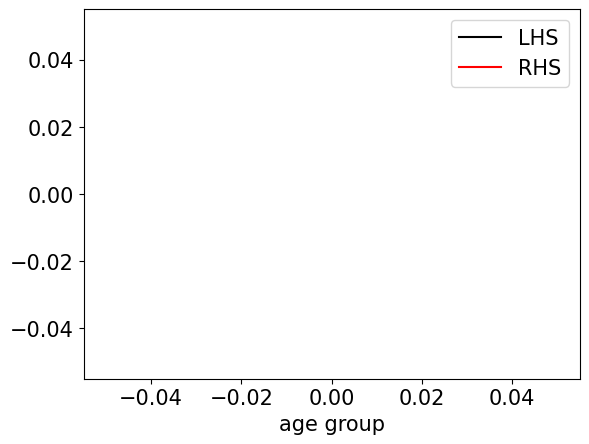

#=================================================================
episode = 1000, loss [log10] = nan
#=================================================================
episode = 2000, loss [log10] = nan
#=================================================================
episode = 3000, loss [log10] = nan
#=================================================================
episode = 4000, loss [log10] = nan


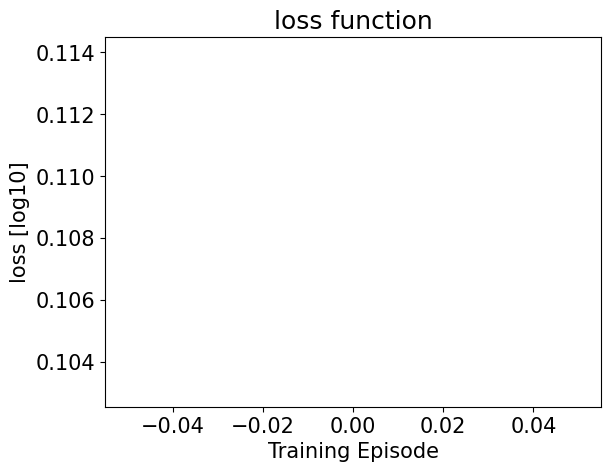

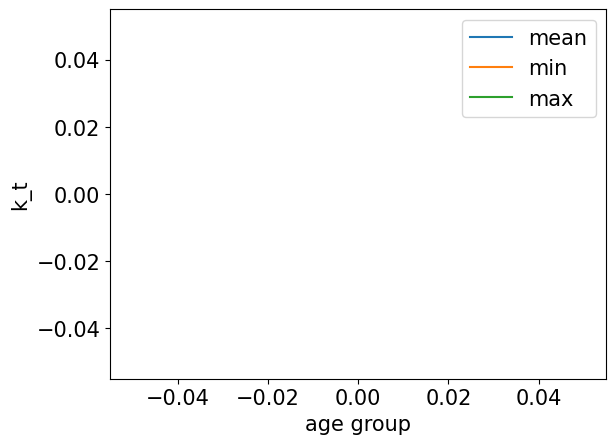

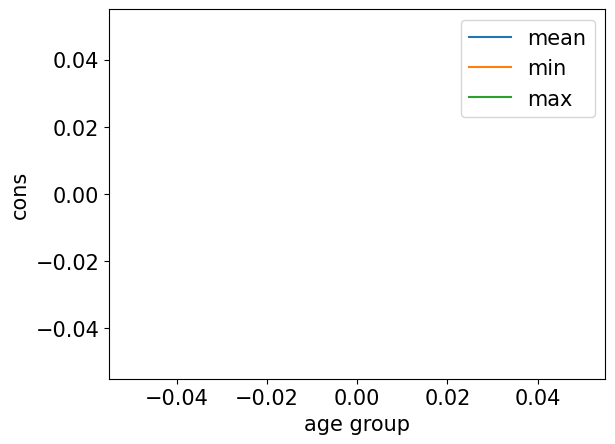

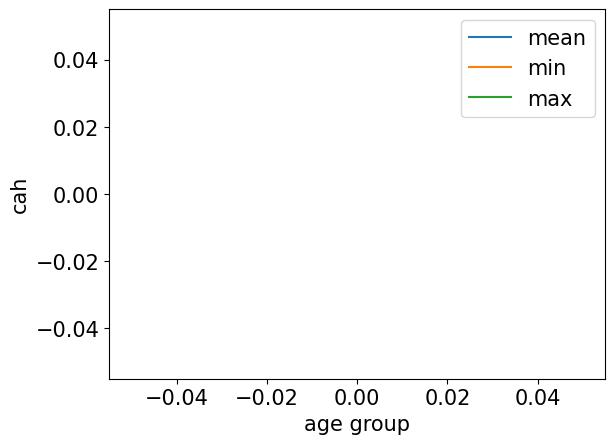

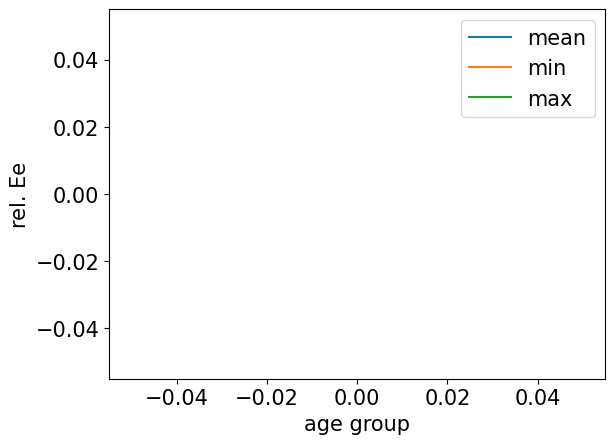

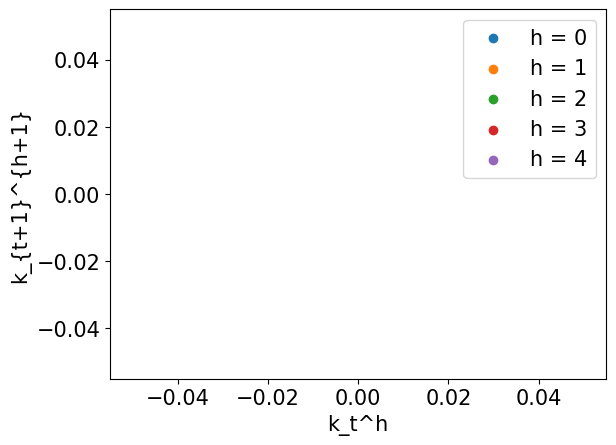

/Users/jason.debacker/anaconda3/envs/dse_env/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/Users/jason.debacker/anaconda3/envs/dse_env/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6764: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

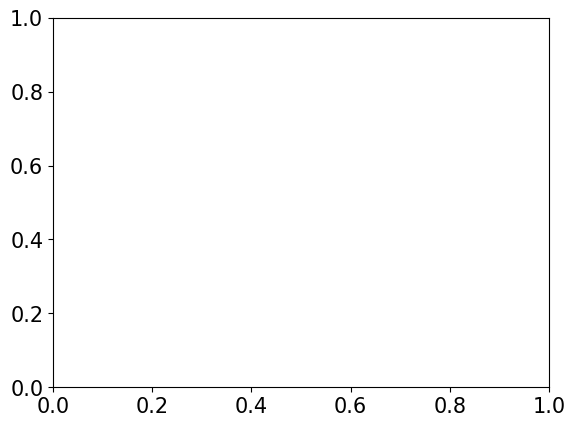

In [88]:
# Keep results for plotting
train_loss = []

num_episodes = 20001

# initialize X_start
X_start = X_end
print("n_tracks = ", X_start.shape[0])
print("n_periods = ", n_periods)

for ep in range(num_episodes):
    # generate training data, now by sampling
    X, X_end = get_training_data_simulation(X_start, nn, n_periods)
    #print(X_end)

    # update X_start
    X_start = X_end
    
    # compute loss and gradients
    loss, grads = grad(X, nn)

    
    # apply gradients
    optimizer.apply_gradients(zip(grads, nn.trainable_variables))
    
    # record loss
    train_loss.append(loss.numpy())
    
    # print progress
    if ep % int(0.05 * num_episodes) == 0:
        print("#=================================================================")
        print("episode = {}, loss [log10] = {}".format(ep, np.log10(loss.numpy())))
        
    if ep % int(0.2 * num_episodes) == 0 or ep == num_episodes - 1:
        cost, errREE, c_t, sav_t, r_t, LHS, RHS, cah_t = compute_cost(X, nn)
        
        plt.title("loss function")
        plt.plot(np.log10(np.array(train_loss)))
        plt.xlabel("Training Episode")
        plt.ylabel("loss [log10]")
        plt.show()
        plt.close()
        
      
        
        
        plt.ylabel("k_t")
        plt.plot(tf.math.reduce_mean(X[:, 1 : 1 + H], axis = 0), label = "mean")
        plt.plot(tf.math.reduce_min(X[:, 1 : 1 + H], axis = 0), label = "min")
        plt.plot(tf.math.reduce_max(X[:, 1 : 1 + H], axis = 0), label = "max")
        plt.legend()
        plt.xlabel("age group")
        plt.show()
        plt.close()
        
        plt.ylabel("cons")
        plt.plot(tf.math.reduce_mean(c_t, axis = 0), label = "mean")
        plt.plot(tf.math.reduce_min(c_t, axis = 0), label = "min")
        plt.plot(tf.math.reduce_max(c_t, axis = 0), label = "max")
        plt.legend()
        plt.xlabel("age group")
        plt.show()
        plt.close()
        
        plt.ylabel("cah")
        plt.plot(tf.math.reduce_mean(cah_t, axis = 0), label = "mean")
        plt.plot(tf.math.reduce_min(cah_t, axis = 0), label = "min")
        plt.plot(tf.math.reduce_max(cah_t, axis = 0), label = "max")
        plt.legend()
        plt.xlabel("age group")
        plt.show()
        plt.close()

        plt.ylabel("rel. Ee")
        plt.plot(tf.math.reduce_mean(errREE, axis = 0), label = "mean")
        plt.plot(tf.math.reduce_min(errREE, axis = 0), label = "min")
        plt.plot(tf.math.reduce_max(errREE, axis = 0), label = "max")
        plt.legend()
        plt.xlabel("age group")
        plt.show()
        plt.close()
        
        
        plt.scatter(X[:, 1], sav_t[:, 0], label = "h = 0")
        plt.scatter(X[:, 2], sav_t[:, 1], label = "h = 1")
        plt.scatter(X[:, 3], sav_t[:, 2], label = "h = 2")
        plt.scatter(X[:, 4], sav_t[:, 3], label = "h = 3")
        plt.scatter(X[:, 5], sav_t[:, 4], label = "h = 4")  
        plt.xlabel("k_t^h")
        plt.ylabel("k_{t+1}^{h+1}")
        plt.legend()
        plt.show()

        
        plt.hist(r_t[:, 0])
        plt.xlabel("r_t")
        plt.ylabel("count")
        plt.show()
        
        plt.plot(tf.math.reduce_mean(LHS, axis = 0), color = "k", label = "LHS")
        plt.plot(tf.math.reduce_min(LHS, axis = 0), color = "k", ls = "--", alpha = 0.3)
        plt.plot(tf.math.reduce_max(LHS, axis = 0), color = "k", ls = "--", alpha = 0.3)
        plt.plot(tf.math.reduce_mean(RHS, axis = 0), color = "r", label = "RHS")
        plt.plot(tf.math.reduce_min(RHS, axis = 0), color = "r", ls = "--", alpha = 0.3)
        plt.plot(tf.math.reduce_max(RHS, axis = 0), color = "r", ls = "--", alpha = 0.3)
        plt.xlabel("age group")
        plt.legend()
        plt.show()
        plt.close()